Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data breast
url_test = "https://raw.githubusercontent.com/jamessaldo/final-task/master/breastCancer_test.data"
url_train =  "https://raw.githubusercontent.com/jamessaldo/final-task/master/breastCancer_train.data"
data_train = pd.read_csv(url_test, header=None)
data_test = pd.read_csv(url_train, header=None)
data_breast = data_train.append(data_test, ignore_index = True)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada data breast cancer:',data_breast.isnull().sum().sum())

Total Missing Value pada data breast cancer: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data breast
data_new_breast = data_breast.drop([24481],axis=1)
scaler = MinMaxScaler()
data_new_breast = scaler.fit_transform(data_new_breast)
data_new_breast = DataFrame(data_new_breast)
data_new_breast['label'] = list(data_breast[24481])
dic = {'non-relapse':0, 'relapse':1}
data_new_breast.replace(dic,inplace=True)

# 2. Define Reusable Function

## FLNN Classifier

In [5]:
def FLNN_Classifier(data_train, data_test, cancer_name, orde):
    start = timeit.default_timer()
    
    x_data_train = data_train.drop(['label'],axis=1)
    y_data_train = data_train['label']
    x_data_test = data_test.drop(['label'],axis=1)
    y_data_test = data_test['label']
    
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

    for x in range(1, orde+1):
        pn = legendre(x)
        y_orde = pn(x_data_train)
        df_train = pd.concat([df_train, y_orde], axis=1)
        
        pn = legendre(x)
        y_orde = pn(x_data_test)
        df_test = pd.concat([df_test, y_orde], axis=1)

    df_train.columns = ["Attribut"+str(i) for i in range(len(df_train.columns))]
    df_train['label'] = y_data_train.reset_index().label
    X_train = df_train.iloc[:, 0:len(df_train.columns)-1].values
    y_train = df_train.iloc[:, len(df_train.columns)-1].values
    
    df_test.columns = ["Attribut"+str(i) for i in range(len(df_test.columns))]
    df_test['label'] = y_data_test.reset_index().label
    X_test = df_test.iloc[:, 0:len(df_test.columns)-1].values
    y_test = df_test.iloc[:, len(df_test.columns)-1].values

    # Melakukan proses klasifikasi FLNN
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_train.columns)-1, kernel_initializer = 'uniform', input_dim = len(df_train.columns)-1))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'mean_squared_error', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    akurasi = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')

    print("Akurasi : ", akurasi)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

    stop = timeit.default_timer()
    print('Running Time: ', stop - start) 
    return akurasi, F1, stop-start

## Genetic Algorithm

In [6]:
# define parameters
mutationRate = 0.01
crossoverRate = 0.8
populationSize = 10
maxGen = 5

def GenerateGene(lengthOfGen):
  genes = [] # menyimpan index feature
  for j in range(lengthOfGen):
    genes.append(random.randint(0,1))
  return genes

def GeneratePopulation(lengthOfGen):
  population = []
  for i in range(populationSize):
    individu = GenerateGene(lengthOfGen)
    population.append(individu)
  return population

def CrossOver(parent_1, parent_2, rate, lengthOfGen): #Random Point Method
  new_pop = [] 
  for i in range((populationSize - 2) // 2):
    if random.random() < rate:
      CP = random.randint(0,lengthOfGen) #CrossPoint
      child = parent_1[0:CP] + parent_2[CP:len(parent_2)]
      new_pop.append(child)
      child = parent_2[0:CP] + parent_1[CP:len(parent_1)]
      new_pop.append(child)
    else:
      new_pop.append(parent_1)
      new_pop.append(parent_2)
  return new_pop

def Mutation(mutant, rate, lengthOfGen):
  for i in range(len(mutant)):
    # memutasi tiap gen yang memiliki kemungkinan < rate(0.1)
    for j in range(lengthOfGen):
      if random.random() <= rate:
        mutant[i][j] = 1 - mutant[i][j]
  return mutant

def ZeroGene(indv): #pengecekan apakah gen isinya kosong atau tidak
  total = 0
  for i in range(len(indv)):
    if indv[i] == 0:
      total += 1
  if len(indv) == total:
    return True
  else:
    return False

def Classification(indv, data_train, data_test, orde): #using Entropy as fitness
  datasetGA_train = pd.DataFrame()
  datasetGA_test = pd.DataFrame()
  idxDatasetGA = 0
  for i in range(len(data_train.columns)-1):
    if indv[i] == 1:
      datasetGA_train[idxDatasetGA] = data_train[i]
      datasetGA_test[idxDatasetGA] = data_test[i]
      idxDatasetGA += 1
  datasetGA_train['label'] = data_train['label']
  datasetGA_test['label'] = data_test['label']
  Acc_score, F1_score, rt = FLNN_Classifier(datasetGA_train, datasetGA_test, "breast cancer", orde)
  totalFeatures = idxDatasetGA+1
  return Acc_score, F1_score, totalFeatures

In [7]:
def GeneticAlgorithm(data_train, data_test, orde):
  start = timeit.default_timer()
  # Initial Population
  lengthOfGen = len(data_train.columns) - 1 # panjang gene = panjang fitur tanpa label

  # fintess evaluation
  bestF1 = 0
  bestAcc = 0
  bestNFeature = len(data_train.columns) - 1
  best_gene = []
  best_gene_2 = []
  population = GeneratePopulation(lengthOfGen) # Generate 1st Generation
  generation = 0 #max generation = 2**len(feature)

  while (generation < maxGen and (bestF1*100) < 90):
    print('Generation :',generation)
    fitness = pd.DataFrame()
    acc = []
    f1score = []
    nFeature = []
    gene = []
    i = 0
    while (i < len(population)):
      if ZeroGene(population[i]) == False:
        print('gene :', population[i])
        accuracy, f1, totalFeatures = Classification(population[i], data_train, data_test, orde) # Count Fitness Value
        acc.append(accuracy)
        f1score.append(f1)
        nFeature.append(totalFeatures)
        gene.append(population[i])
      i += 1

    fitness['gene'] = gene
    fitness['feature'] = nFeature
    fitness['f1_score'] = f1score
    fitness['accuracy'] = acc

    fitness = fitness.sort_values(['f1_score'],ascending=False)
    
    last_bestF1 = bestF1
    last_bestAcc = bestAcc
    last_bestNFeature = bestNFeature
    last_best_gene = best_gene
    last_best_gene_2 = best_gene_2
    
    if last_bestF1 > fitness['f1_score'][fitness.index[0]]:
        bestF1 = last_bestF1
        bestAcc = last_bestAcc
        bestNFeature = last_bestNFeature
        # select parent
        best_gene = last_best_gene
        best_gene_2 = last_best_gene_2
    else:
        bestF1 = fitness['f1_score'][fitness.index[0]]
        bestAcc = fitness['accuracy'][fitness.index[0]]
        bestNFeature = fitness['feature'][fitness.index[0]]
        # select parent
        best_gene = fitness['gene'][fitness.index[0]].copy()
        best_gene_2 = fitness['gene'][fitness.index[1]].copy()

    #Crossover methods: Fixed Point, "Random Point", Alternate Point
    population = CrossOver(best_gene.copy(), best_gene_2.copy(), crossoverRate, lengthOfGen)

    # Mutation
    population = Mutation(population, mutationRate, lengthOfGen)

    # Masukkan best child tadi
    population.append(best_gene)
    population.append(best_gene_2)

    # Print Result
    print('===============================================================================================================================================================================================================')
    print('gen terbaik :', best_gene)
    print('F-1 Score terbaik :',bestF1,' || Akurasi terbaik :',bestAcc,' || jumlah fitur :',bestNFeature)
    print()

    # New Generation
    generation += 1
  listDrop = []
  for i in range(len(data_train.columns)-1):
    if best_gene[i] == 0:
      listDrop.append(data_train.columns[i])
  dataset_GA_train = data_train.drop(listDrop, axis = 1)
  dataset_GA_test = data_test.drop(listDrop, axis = 1)
  stop = timeit.default_timer()
  print('Running Time: ', stop - start)
  return bestAcc, bestF1, bestNFeature, stop-start

# 3. Feature Selection with IG

## breast

In [8]:
# Feature Selection using Mutual Information
def InformationGain(data_train, data_test):
    start = timeit.default_timer()
    data_X_train = data_train.drop(['label'],axis=1)
    data_Y_train = data_train['label']
    
    data_X_test = data_test.drop(['label'],axis=1)
    data_Y_test = data_test['label']

    sel_k_best = SelectKBest(mutual_info_classif, k=100)
    sel_k_best.fit(data_X_train, data_Y_train)
    data_train_X_new = sel_k_best.transform(data_X_train)
    data_test_X_new = sel_k_best.transform(data_X_test)

    breast_IG_train = pd.DataFrame(data_train_X_new)
    breast_IG_train['label'] = data_Y_train
    breast_IG_test = pd.DataFrame(data_test_X_new)
    breast_IG_test['label'] = data_Y_test
    
    print("train: ",breast_IG_train.shape)
    print("test: ",breast_IG_test.shape)
    stop = timeit.default_timer()
    print("Running Time: ", stop-start)
    return breast_IG_train, breast_IG_test, stop-start

# 4. Classification

Train :  [ 0  1  2  3  4  5  6  8 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 35 37 38 39 40 41 42 43 45 46 47 48 50 51 53 54 55 58 60 61
 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 81 82 85 86 87 88 89 90
 91 92 93 94 95] Test :  [ 7  9 10 11 17 28 34 36 44 49 52 56 57 59 62 66 74 83 84 96]
train:  (77, 101)
test:  (20, 101)
Running Time:  23.4174352
breast + IG Orde 2
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7916666666666665
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.71      1.00      0.83        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



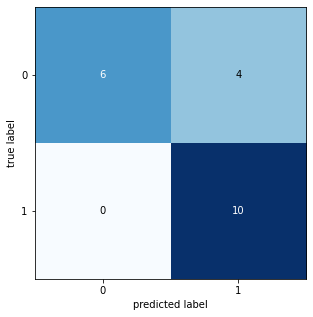

Running Time:  1.684053800000001
breast + IG Orde 3
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7916666666666665
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.71      1.00      0.83        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



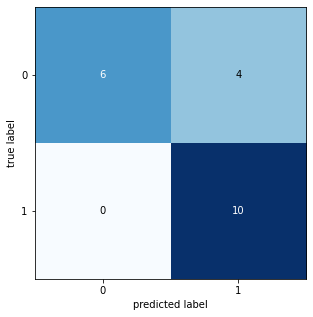

Running Time:  1.6769965999999954
breast + IG Orde 4
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



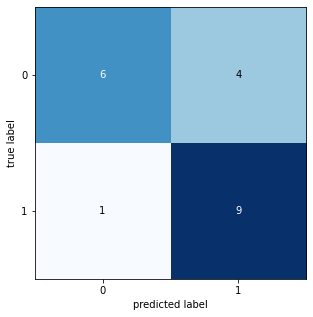

Running Time:  1.6134356999999966
breast + IG + GA Orde 2
Generation : 0
gene : [0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6266666666666667
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.60      0.90      0.72        10

    accuracy                           0.65        20
   macro avg       0.70      0.65      0.63        20
weighted avg       0.70      0.65      0.63        20



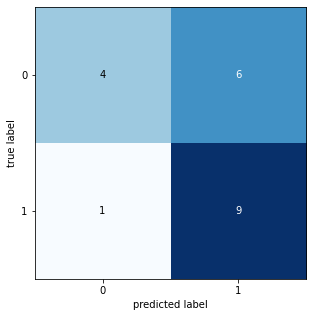

Running Time:  1.5267881000000045
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



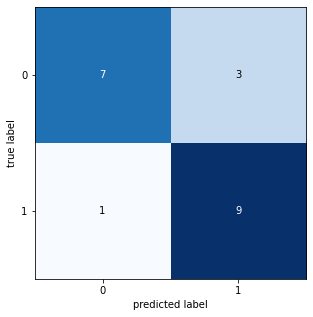

Running Time:  1.5189584000000025
gene : [0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.64      0.90      0.75        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20



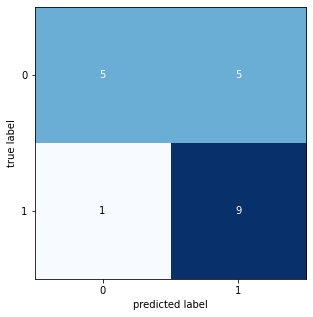

Running Time:  1.5159893999999952
gene : [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333334
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.67      1.00      0.80        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20



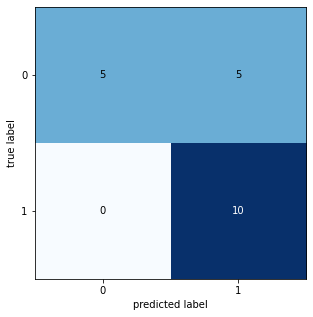

Running Time:  1.5205549000000005
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



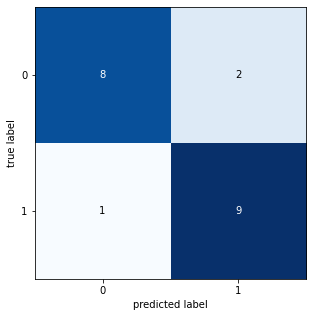

Running Time:  1.5242514999999983
gene : [0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153452
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.62      0.80      0.70        10

    accuracy                           0.65        20
   macro avg       0.66      0.65      0.64        20
weighted avg       0.66      0.65      0.64        20



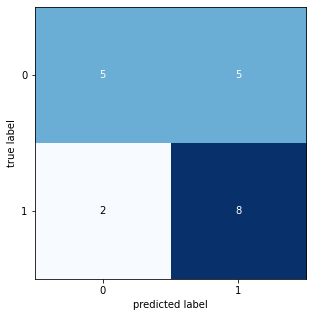

Running Time:  1.6710223999999982
gene : [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



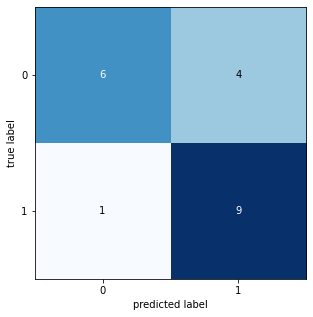

Running Time:  1.5227955000000009
gene : [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7916666666666665
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.71      1.00      0.83        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



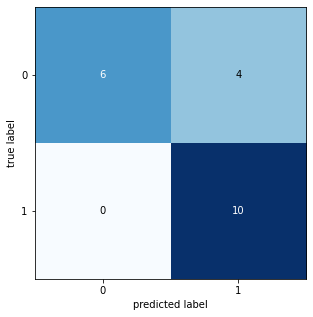

Running Time:  1.5240981000000033
gene : [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333334
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.67      1.00      0.80        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20



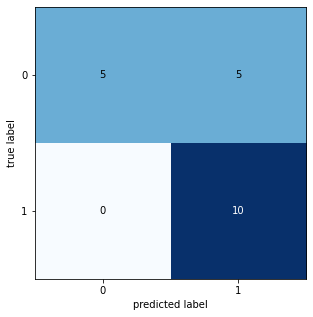

Running Time:  1.5288814999999971
gene : [0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



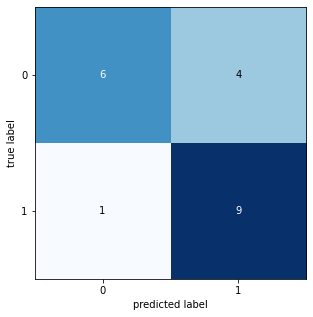

Running Time:  1.5271220999999997
gen terbaik : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 45

Generation : 1
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Sc

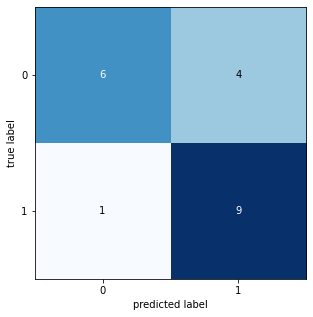

Running Time:  1.5267057000000008
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.64      0.90      0.75        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20



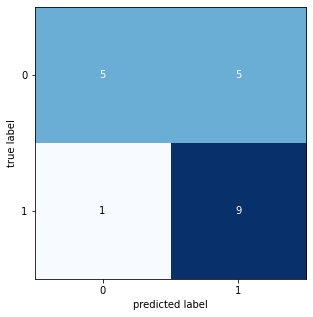

Running Time:  1.5239522999999977
gene : [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



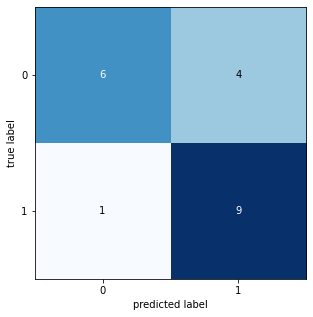

Running Time:  1.5248370999999992
gene : [1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



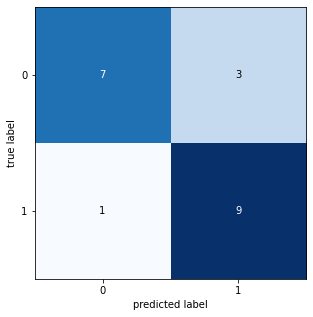

Running Time:  1.7192231999999947
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



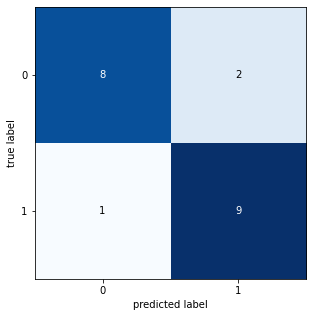

Running Time:  1.5283335000000093
gene : [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



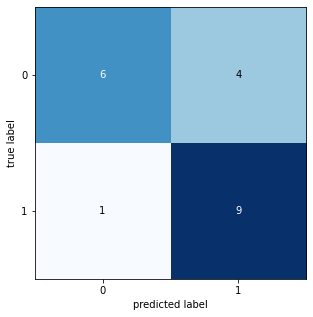

Running Time:  1.519227199999989
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



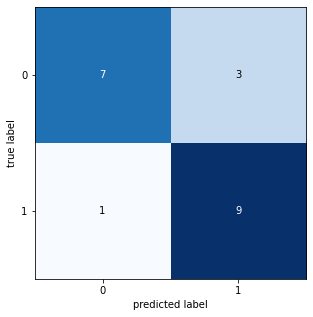

Running Time:  1.527015999999989
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



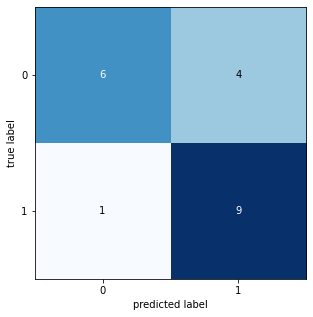

Running Time:  1.5358202000000034
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



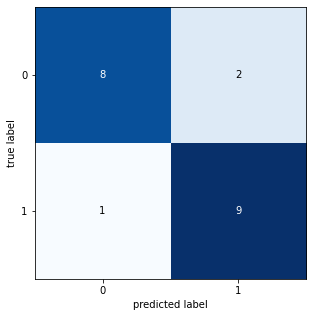

Running Time:  1.5258333999999962
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



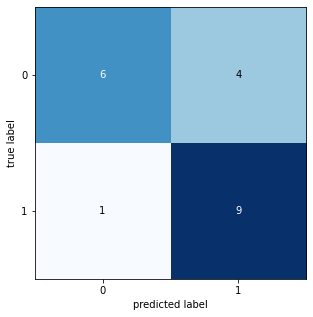

Running Time:  1.5214486999999934
gen terbaik : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 44

Generation : 2
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Sc

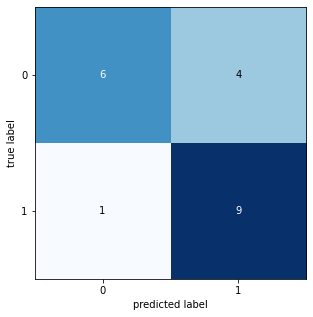

Running Time:  1.5245079000000032
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



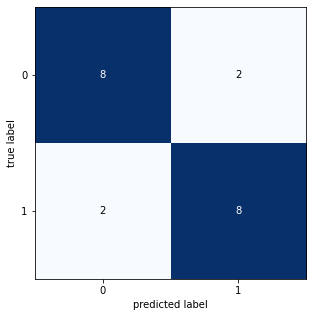

Running Time:  1.7066935999999941
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



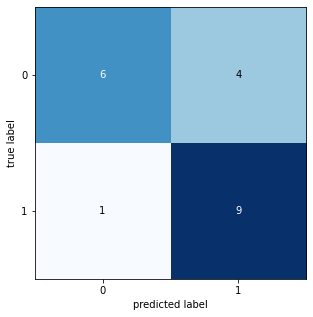

Running Time:  1.5201816000000008
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



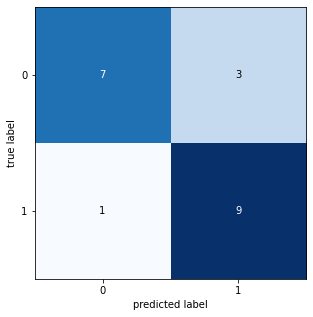

Running Time:  1.5248873000000032
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



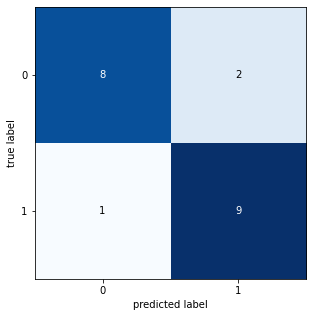

Running Time:  1.520935399999999
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



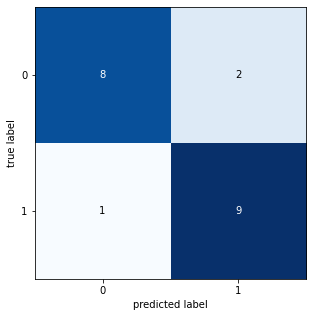

Running Time:  1.5283017999999942
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.73      0.80      0.76        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



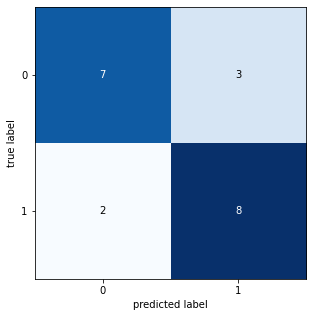

Running Time:  1.5215734999999881
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



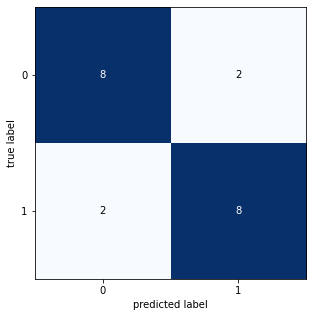

Running Time:  1.5311939999999993
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



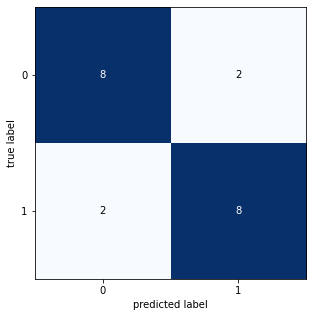

Running Time:  1.5239899999999977
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



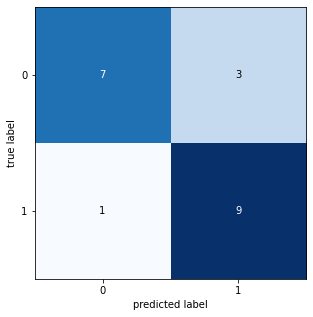

Running Time:  1.696436399999996
gen terbaik : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 44

Generation : 3
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Scor

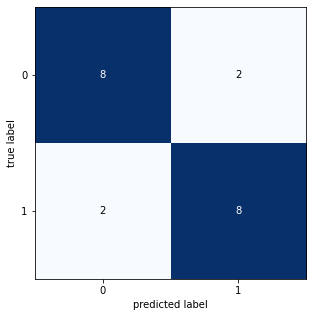

Running Time:  1.5158612999999974
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



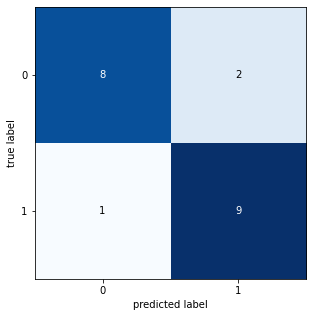

Running Time:  1.5298370000000006
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



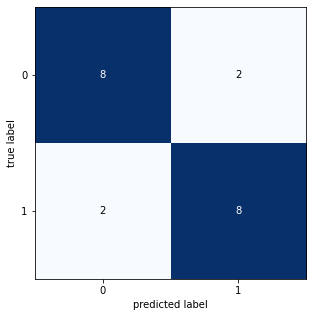

Running Time:  1.5239772999999985
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



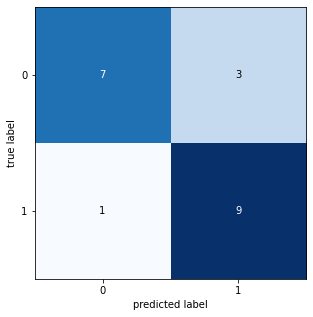

Running Time:  1.5231198000000035
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



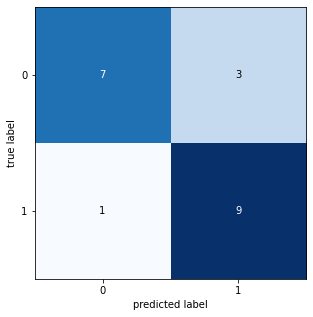

Running Time:  1.5303755000000052
gene : [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6969696969696968
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.67      0.80      0.73        10

    accuracy                           0.70        20
   macro avg       0.71      0.70      0.70        20
weighted avg       0.71      0.70      0.70        20



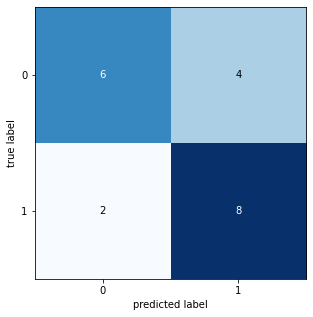

Running Time:  1.5201977000000113
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



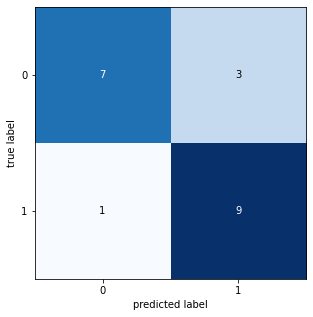

Running Time:  1.519137999999998
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



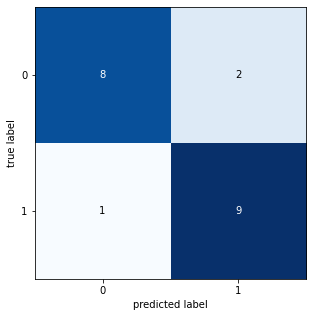

Running Time:  1.713179800000006
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



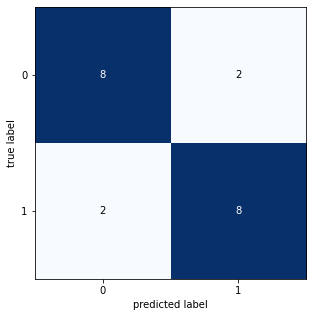

Running Time:  1.5204882000000026
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



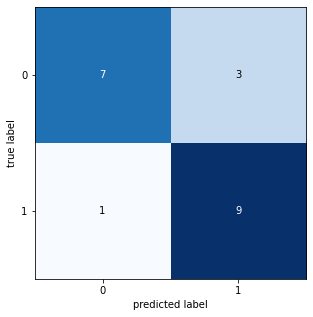

Running Time:  1.5254780000000068
gen terbaik : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 44

Generation : 4
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Sco

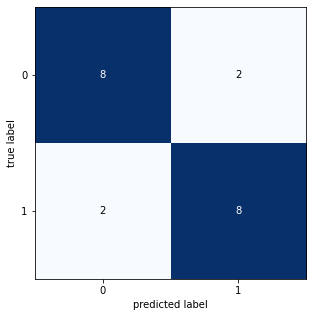

Running Time:  1.5189608999999962
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



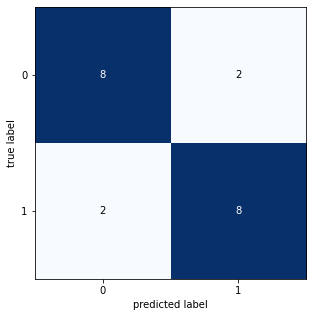

Running Time:  1.5358065000000067
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



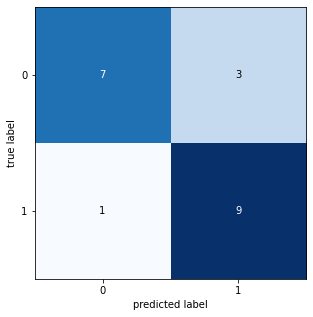

Running Time:  1.526927999999998
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



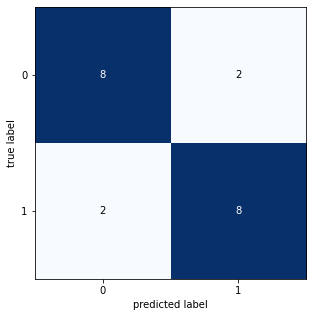

Running Time:  1.5260789000000017
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



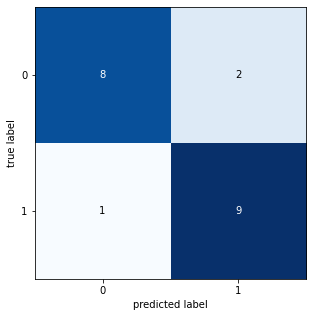

Running Time:  1.5306326000000041
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



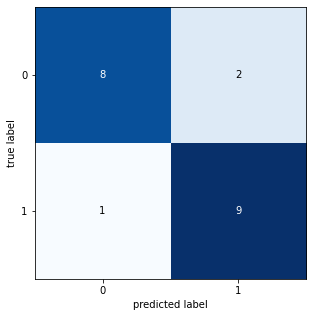

Running Time:  1.7103845000000035
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



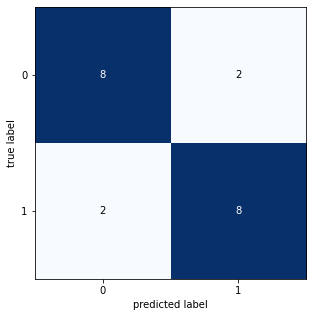

Running Time:  1.5235090000000042
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



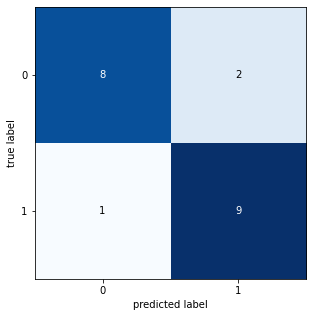

Running Time:  1.5268434999999982
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



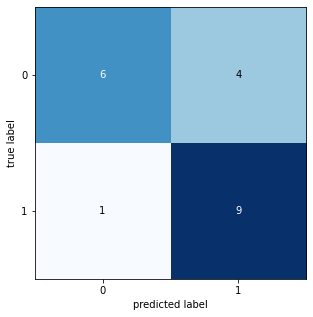

Running Time:  1.5196335999999917
gene : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



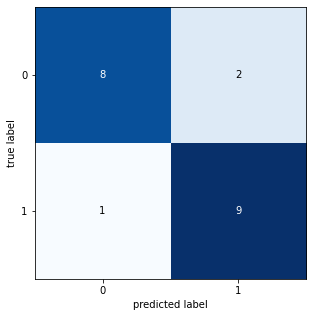

Running Time:  1.5137476999999961
gen terbaik : [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 44

Running Time:  78.1569208
breast + IG + GA Orde 3
Generation : 0
gene : [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 

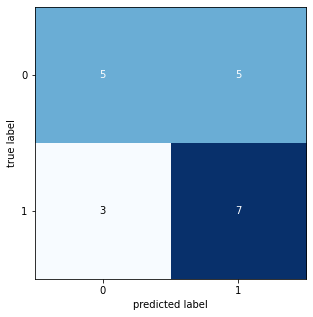

Running Time:  1.5412970999999942
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7916666666666665
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.71      1.00      0.83        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



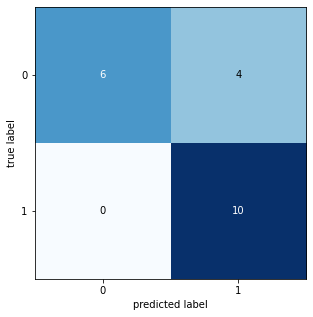

Running Time:  1.5587918000000087
gene : [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6703296703296704
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.62      1.00      0.77        10

    accuracy                           0.70        20
   macro avg       0.81      0.70      0.67        20
weighted avg       0.81      0.70      0.67        20



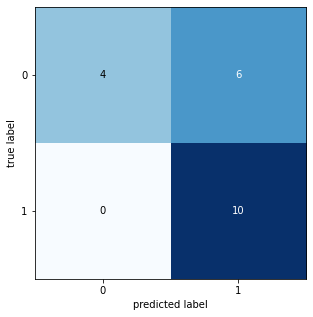

Running Time:  1.5604847999999976
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.77      1.00      0.87        10

    accuracy                           0.85        20
   macro avg       0.88      0.85      0.85        20
weighted avg       0.88      0.85      0.85        20



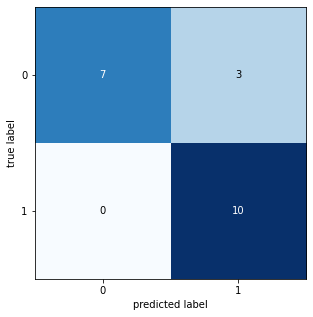

Running Time:  1.7164183000000008
gene : [0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.64      0.70      0.67        10

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



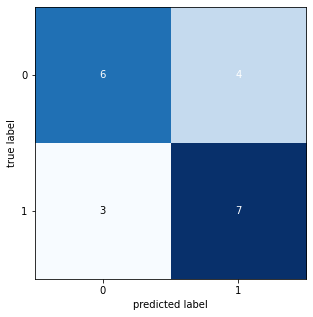

Running Time:  1.53779329999999
gene : [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333334
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.67      1.00      0.80        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20



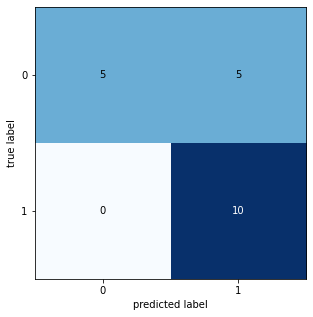

Running Time:  1.5476290999999947
gene : [1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



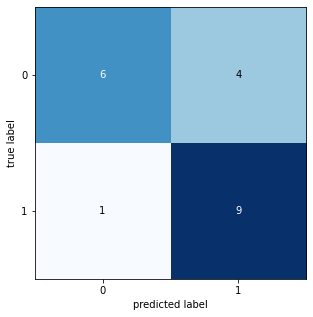

Running Time:  1.551821899999993
gene : [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



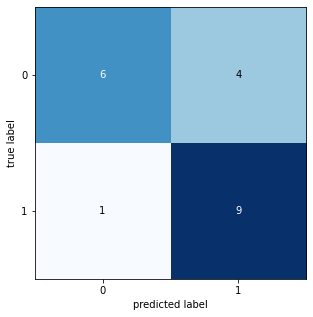

Running Time:  1.5373864000000026
gene : [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.62      0.50      0.56        10

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



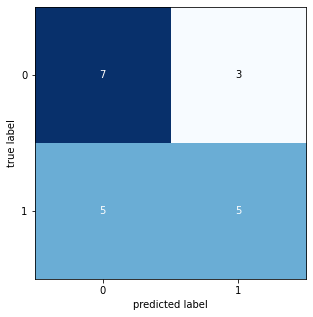

Running Time:  1.5430658999999878
gene : [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.52
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.53      0.80      0.64        10

    accuracy                           0.55        20
   macro avg       0.57      0.55      0.52        20
weighted avg       0.57      0.55      0.52        20



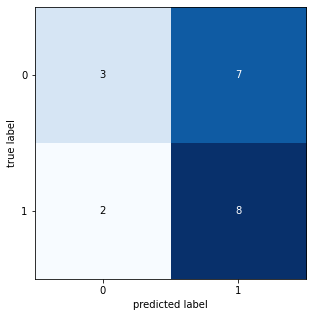

Running Time:  1.5385490000000175
gen terbaik : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
F-1 Score terbaik : 0.8465473145780051  || Akurasi terbaik : 0.85  || jumlah fitur : 55

Generation : 1
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Sc

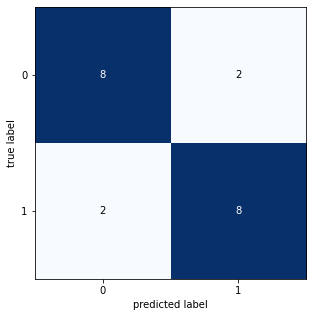

Running Time:  1.7193824000000006
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7916666666666665
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.71      1.00      0.83        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



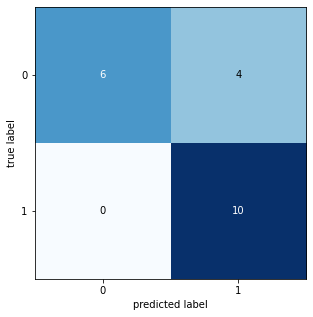

Running Time:  1.5463534999999808
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.64      0.90      0.75        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20



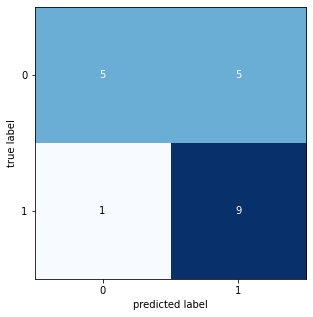

Running Time:  1.5577501000000211
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7916666666666665
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.71      1.00      0.83        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



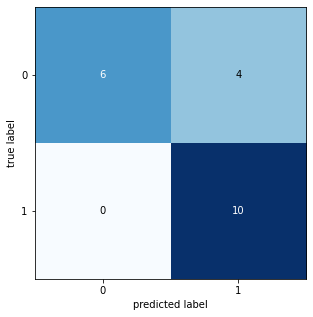

Running Time:  1.5567531000000088
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



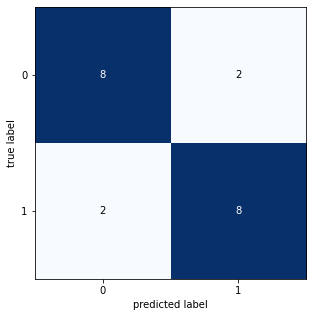

Running Time:  1.5535587999999905
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333334
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.67      1.00      0.80        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20



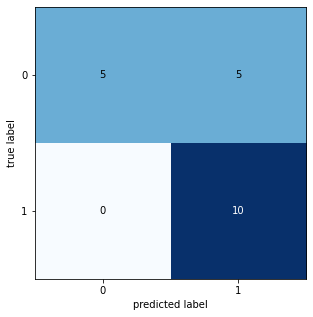

Running Time:  1.5522123000000079
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7916666666666665
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.71      1.00      0.83        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



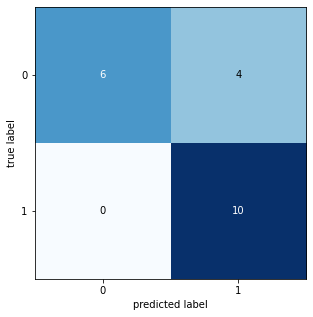

Running Time:  1.5574425000000076
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.64      0.90      0.75        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20



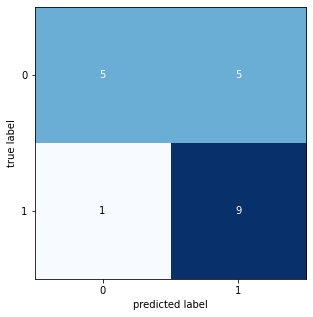

Running Time:  1.5460252000000025
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



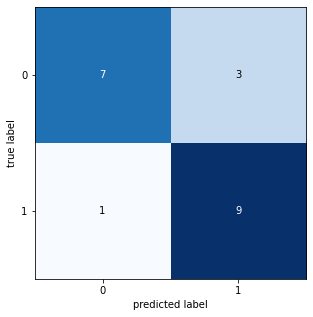

Running Time:  1.7225998000000118
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.77      1.00      0.87        10

    accuracy                           0.85        20
   macro avg       0.88      0.85      0.85        20
weighted avg       0.88      0.85      0.85        20



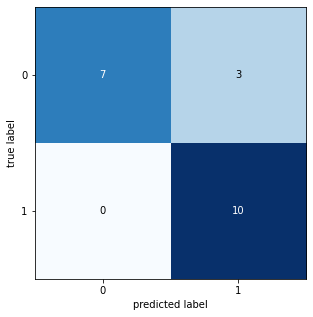

Running Time:  1.5618882999999926
gen terbaik : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.8465473145780051  || Akurasi terbaik : 0.85  || jumlah fitur : 54

Generation : 2
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_S

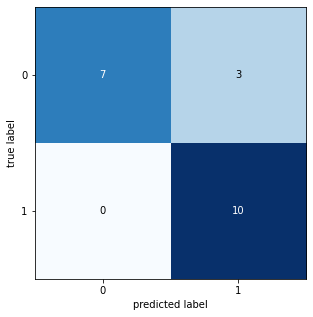

Running Time:  1.5643313000000205
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



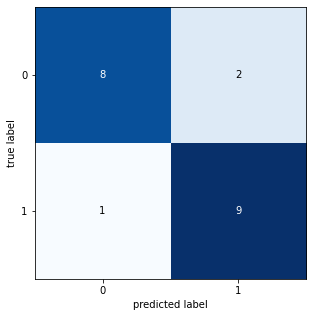

Running Time:  1.5561270000000036
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.77      1.00      0.87        10

    accuracy                           0.85        20
   macro avg       0.88      0.85      0.85        20
weighted avg       0.88      0.85      0.85        20



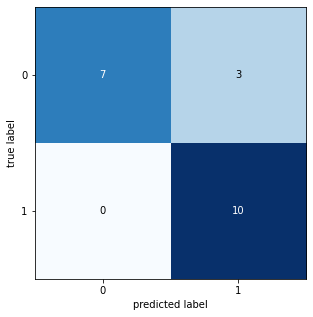

Running Time:  1.5638893999999937
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



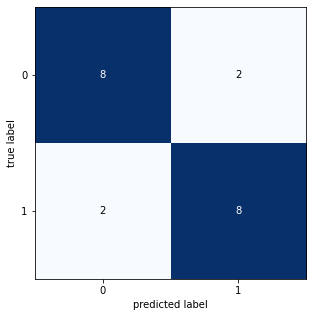

Running Time:  1.5443258999999898
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



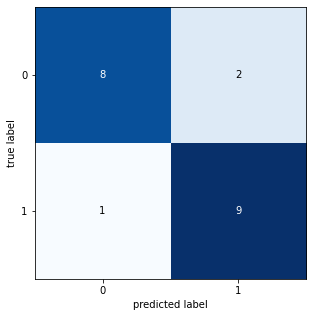

Running Time:  1.54664649999998
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.7916666666666665
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.71      1.00      0.83        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20



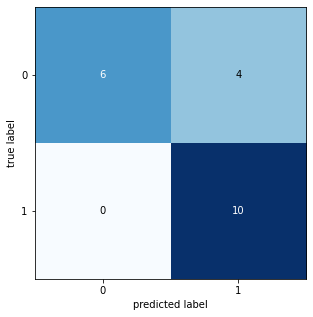

Running Time:  1.5623841999999968
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.77      1.00      0.87        10

    accuracy                           0.85        20
   macro avg       0.88      0.85      0.85        20
weighted avg       0.88      0.85      0.85        20



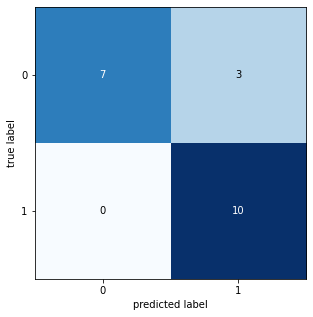

Running Time:  1.7210083999999881
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



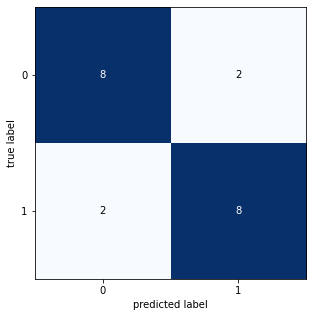

Running Time:  1.5599616000000083
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.77      1.00      0.87        10

    accuracy                           0.85        20
   macro avg       0.88      0.85      0.85        20
weighted avg       0.88      0.85      0.85        20



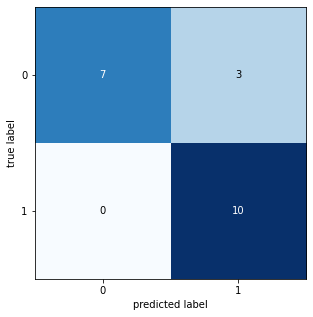

Running Time:  1.5663352999999915
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



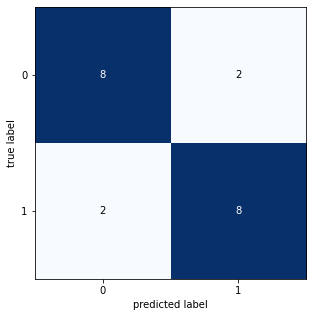

Running Time:  1.5874258999999995
gen terbaik : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 52

Generation : 3
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Sc

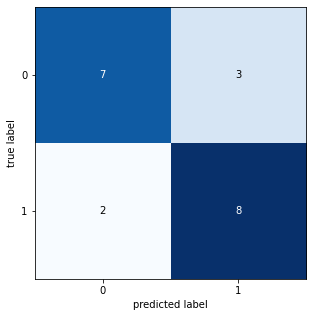

Running Time:  1.5528254000000175
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



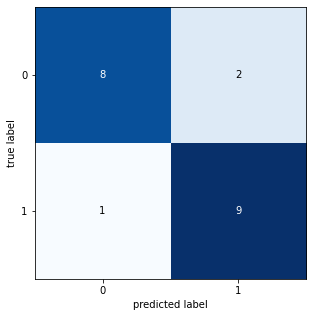

Running Time:  1.543304500000005
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



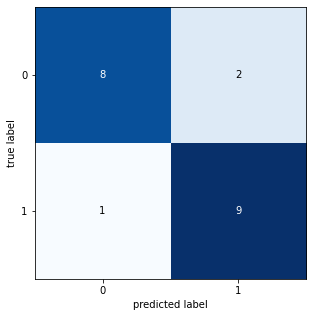

Running Time:  1.5573573000000067
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



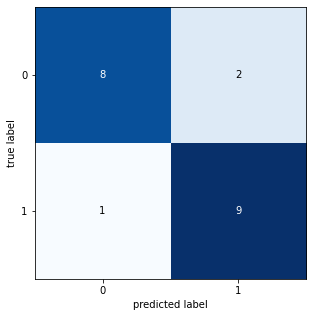

Running Time:  1.5531692000000135
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.8000000000000002
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.80      0.80      0.80        10

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



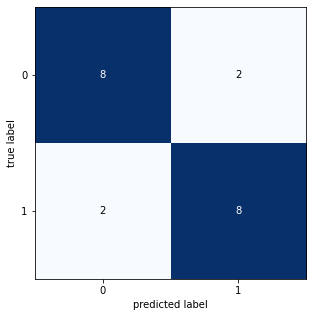

Running Time:  1.732011
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



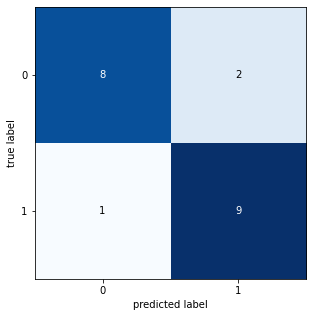

Running Time:  1.5509744999999953
gene : [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



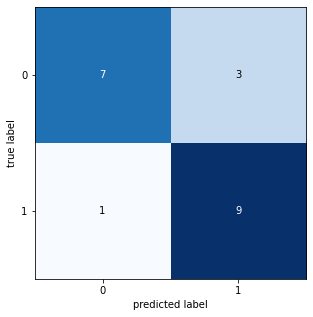

Running Time:  1.5507187999999985
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



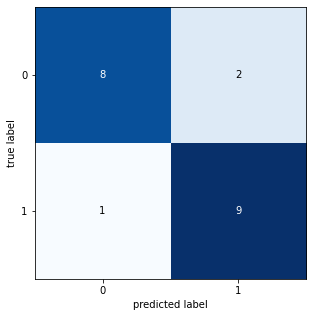

Running Time:  1.5424667999999997
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.73      0.80      0.76        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



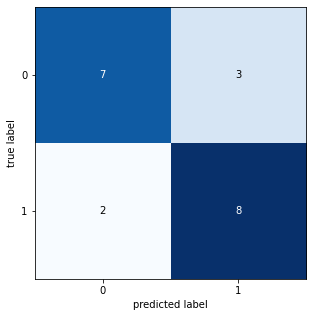

Running Time:  1.5546946999999989
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



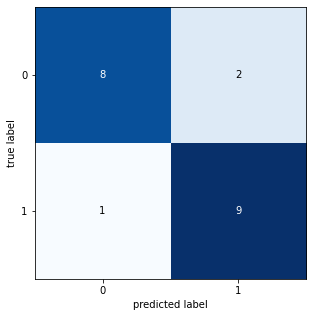

Running Time:  1.546574899999996
gen terbaik : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 48

Generation : 4
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Sco

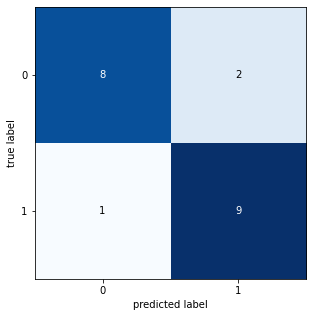

Running Time:  1.5591778999999804
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



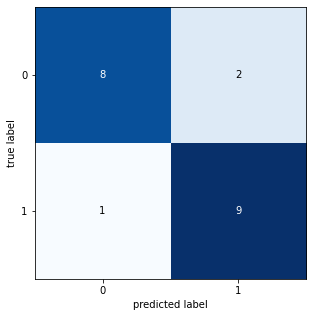

Running Time:  1.550524299999978
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



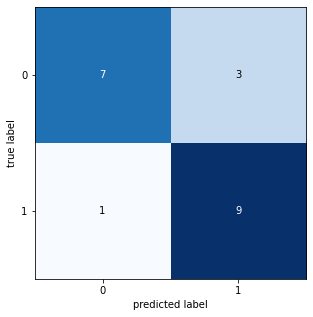

Running Time:  1.7049434999999846
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



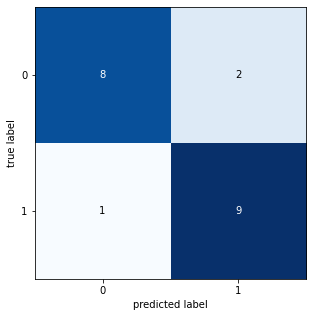

Running Time:  1.5586806999999965
gene : [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153452
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.62      0.80      0.70        10

    accuracy                           0.65        20
   macro avg       0.66      0.65      0.64        20
weighted avg       0.66      0.65      0.64        20



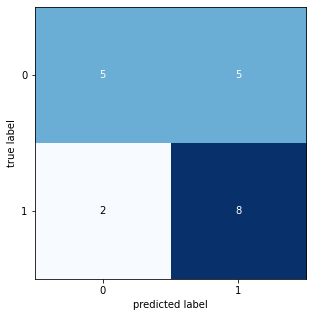

Running Time:  1.548275999999987
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



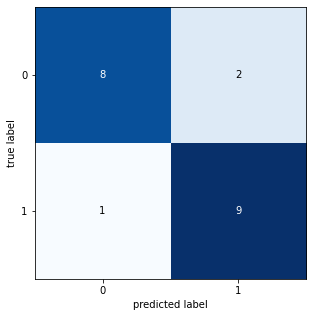

Running Time:  1.5445680999999922
gene : [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



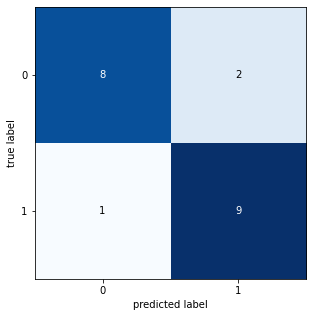

Running Time:  1.548577100000017
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.73      0.80      0.76        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



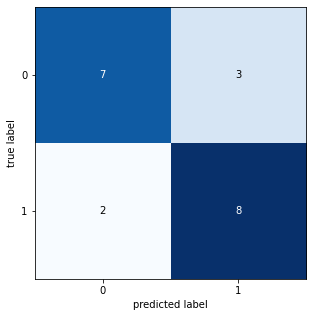

Running Time:  1.5468639000000053
gene : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.64      0.90      0.75        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20



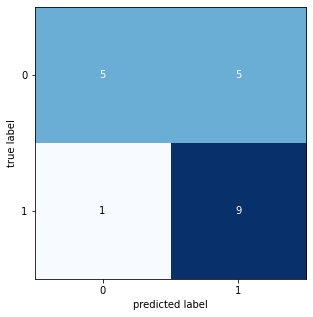

Running Time:  1.5518265999999983
gene : [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



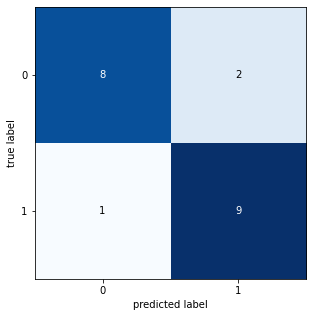

Running Time:  1.5516209000000174
gen terbaik : [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 48

Running Time:  79.60427159999999
breast + IG + GA Orde 4
Generation : 0
gene : [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1

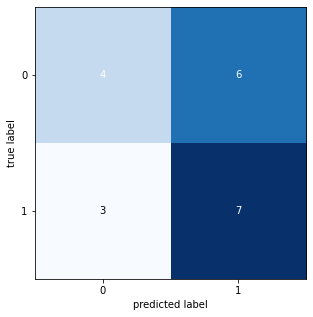

Running Time:  1.7279794000000095
gene : [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6266666666666667
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.60      0.90      0.72        10

    accuracy                           0.65        20
   macro avg       0.70      0.65      0.63        20
weighted avg       0.70      0.65      0.63        20



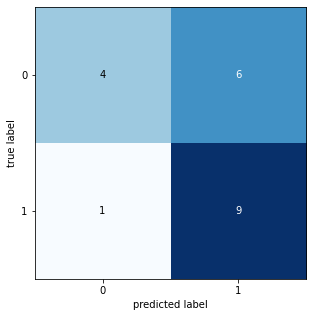

Running Time:  1.5619574000000114
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



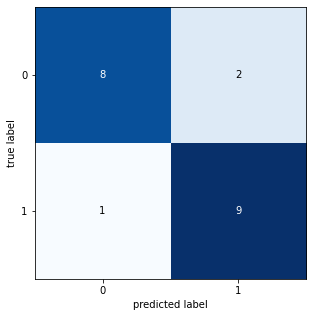

Running Time:  1.5768772000000126
gene : [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



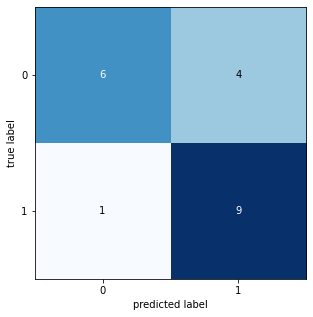

Running Time:  1.5507499999999936
gene : [0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



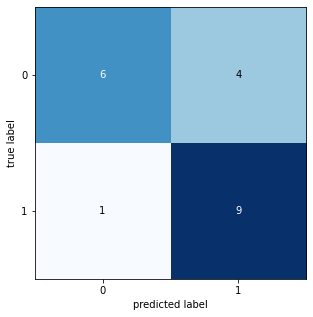

Running Time:  1.576948200000004
gene : [0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966751
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



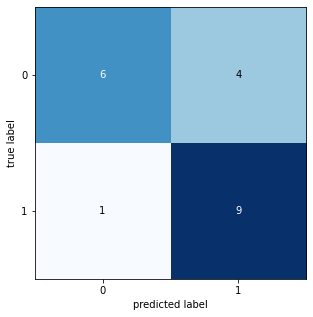

Running Time:  1.55865799999998
gene : [0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153452
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.62      0.80      0.70        10

    accuracy                           0.65        20
   macro avg       0.66      0.65      0.64        20
weighted avg       0.66      0.65      0.64        20



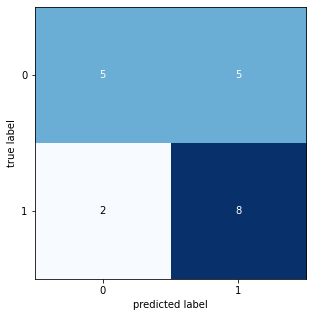

Running Time:  1.5553070999999932
gene : [0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511277
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.55      0.60      0.57        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



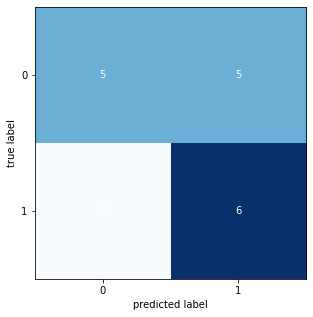

Running Time:  1.7188897999999995
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



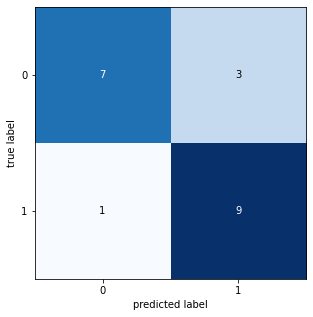

Running Time:  1.5619353999999817
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.64      0.70      0.67        10

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



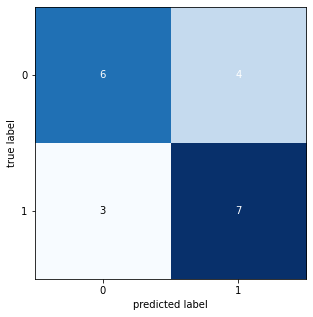

Running Time:  1.5599362000000099
gen terbaik : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 54

Generation : 1
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Sc

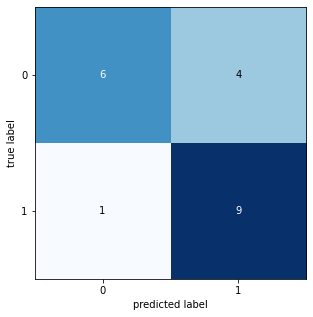

Running Time:  1.5698412000000133
gene : [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



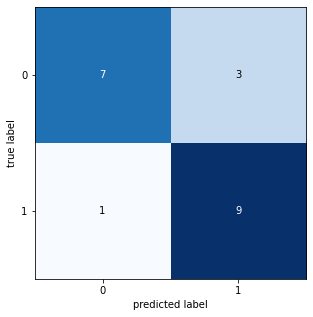

Running Time:  1.5649923999999942
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.77      1.00      0.87        10

    accuracy                           0.85        20
   macro avg       0.88      0.85      0.85        20
weighted avg       0.88      0.85      0.85        20



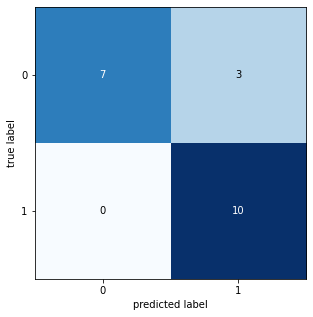

Running Time:  1.5662207999999964
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.89      0.80      0.84        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



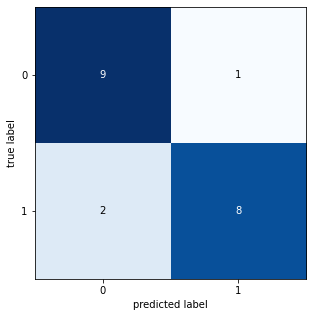

Running Time:  1.573756000000003
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



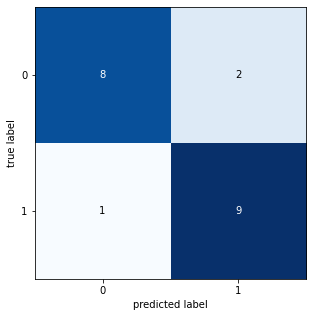

Running Time:  1.561721600000027
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



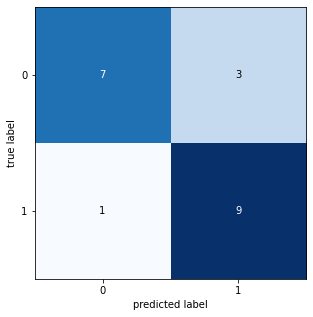

Running Time:  1.7444901000000073
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



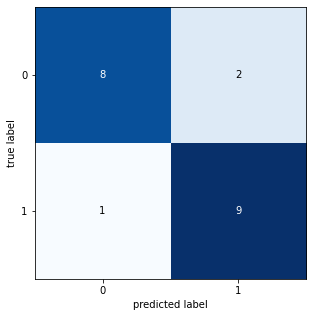

Running Time:  1.5634147000000098
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



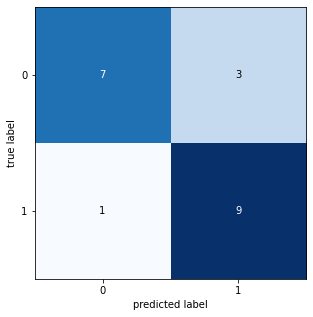

Running Time:  1.5578845000000001
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



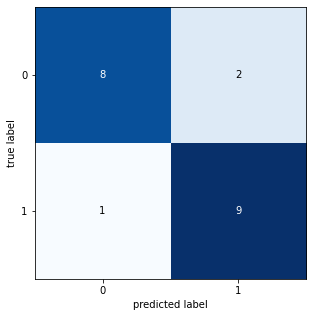

Running Time:  1.5701496999999733
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.75      0.90      0.82        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



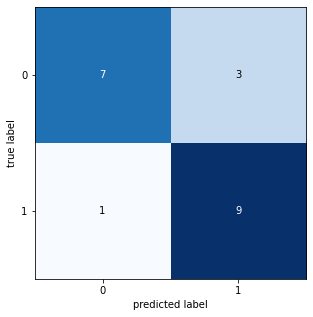

Running Time:  1.5552317000000073
gen terbaik : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 52

Generation : 2
gene : [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Sc

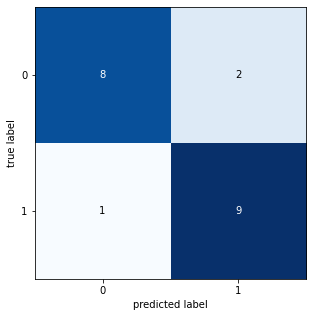

Running Time:  1.5804911000000175
gene : [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.9
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



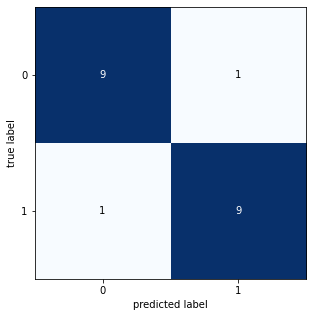

Running Time:  1.5576958000000047
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



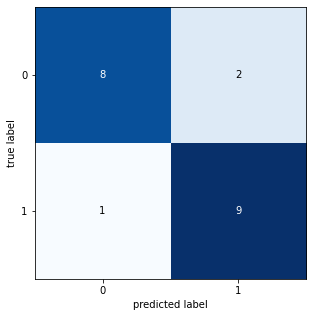

Running Time:  1.5750936999999965
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



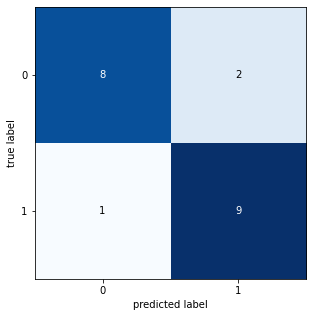

Running Time:  1.7405495000000144
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



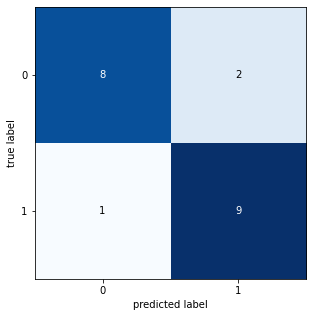

Running Time:  1.5704902999999888
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



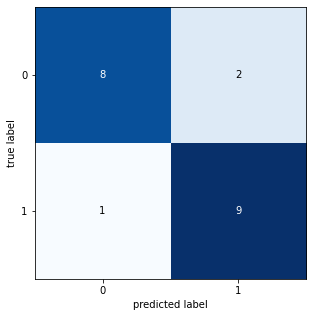

Running Time:  1.569379500000025
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



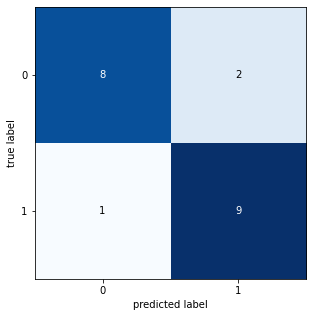

Running Time:  1.5764834999999948
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



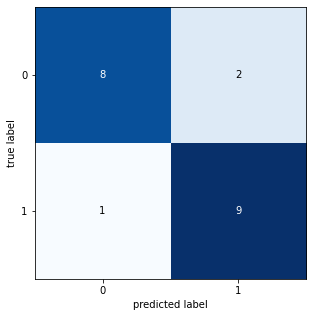

Running Time:  1.5700899999999933
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.73      0.80      0.76        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



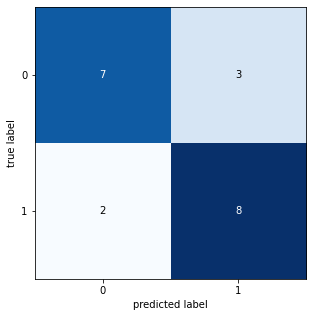

Running Time:  1.5745927999999765
gene : [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



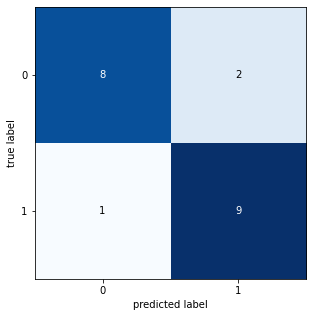

Running Time:  1.5684401000000037
gen terbaik : [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.9  || Akurasi terbaik : 0.9  || jumlah fitur : 51

Running Time:  48.25318709999999
Train :  [ 0  2  3  4  5  7  8  9 10 11 14 15 16 17 19 20 21 22 23 25 26 27 28 30
 31 34 35 36 37 38 39 42 43 44 45 46 47 48 49 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 69 70 72 73 74 75 76 77 80 81 82 83 84 85 86 88 89
 90 91 92 95 96] Test :  [ 1  6 12 13 18 24 29 32 33 40 41 50 67 68 71 78 79 87 93 94]
train:  (77, 101)
test:  (20, 101)
Running Time:  23.876561099999975
breast + IG Orde 2
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

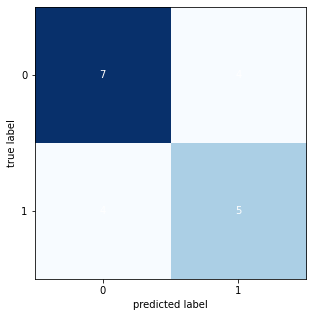

Running Time:  1.7375402999999778
breast + IG Orde 3
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



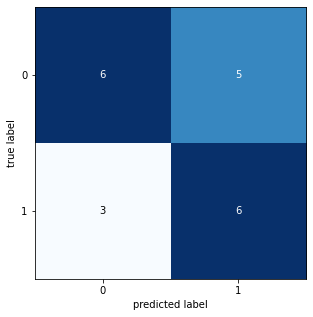

Running Time:  1.6206609000000185
breast + IG Orde 4
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511277
              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.50      0.56      0.53         9

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



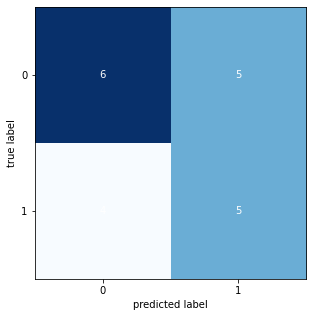

Running Time:  1.6343737999999917
breast + IG + GA Orde 2
Generation : 0
gene : [1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



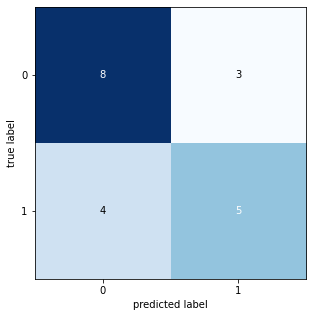

Running Time:  1.5426952999999912
gene : [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511278
              precision    recall  f1-score   support

           0       0.62      0.45      0.53        11
           1       0.50      0.67      0.57         9

    accuracy                           0.55        20
   macro avg       0.56      0.56      0.55        20
weighted avg       0.57      0.55      0.55        20



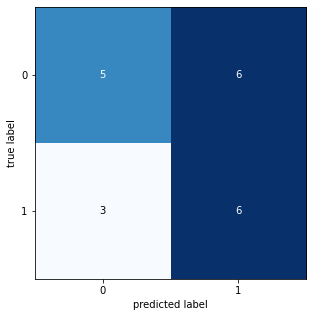

Running Time:  1.537739799999997
gene : [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.56      0.56      0.56         9

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



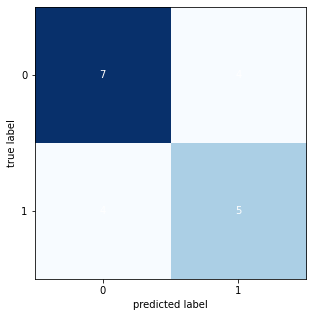

Running Time:  1.5427281000000335
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



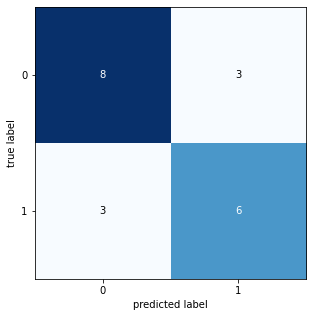

Running Time:  1.5510454999999865
gene : [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.4
F1_Score :  0.3939393939393939
              precision    recall  f1-score   support

           0       0.43      0.27      0.33        11
           1       0.38      0.56      0.45         9

    accuracy                           0.40        20
   macro avg       0.41      0.41      0.39        20
weighted avg       0.41      0.40      0.39        20



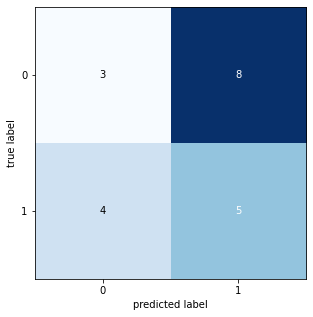

Running Time:  1.713317600000039
gene : [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.56      0.56      0.56         9

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



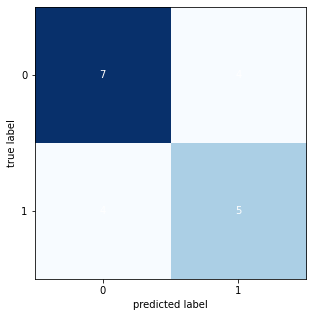

Running Time:  1.5498653000000218
gene : [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511277
              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.50      0.56      0.53         9

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



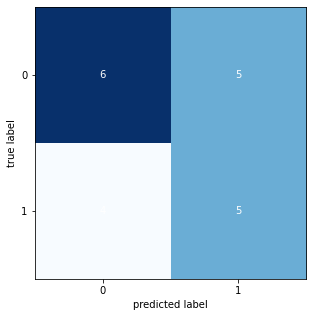

Running Time:  1.5340552999999773
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.56      0.56      0.56         9

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



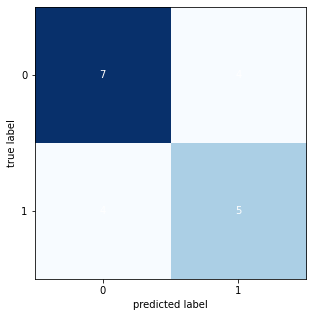

Running Time:  1.5578001000000086
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



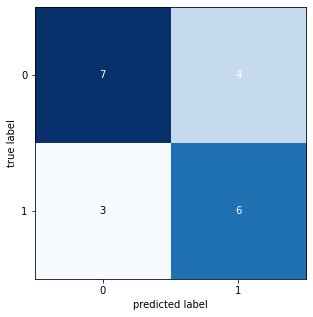

Running Time:  1.5400434000000018
gene : [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



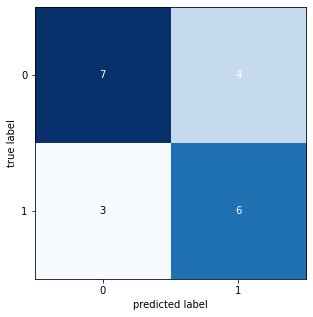

Running Time:  1.554521799999975
gen terbaik : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.696969696969697  || Akurasi terbaik : 0.7  || jumlah fitur : 53

Generation : 1
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Scor

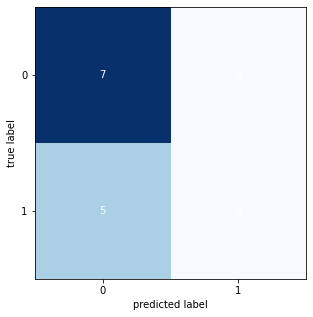

Running Time:  1.5452247000000057
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511278
              precision    recall  f1-score   support

           0       0.62      0.45      0.53        11
           1       0.50      0.67      0.57         9

    accuracy                           0.55        20
   macro avg       0.56      0.56      0.55        20
weighted avg       0.57      0.55      0.55        20



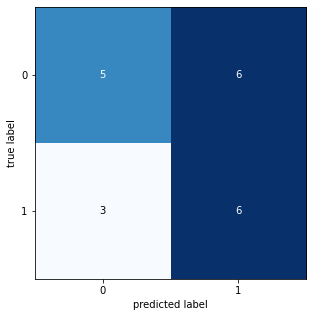

Running Time:  1.5524590000000558
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



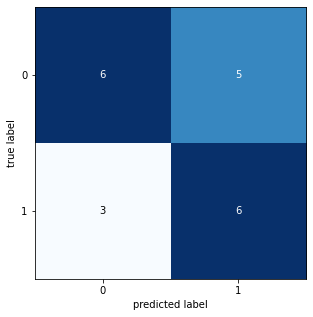

Running Time:  1.7221822999999858
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



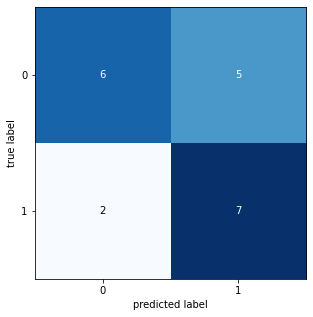

Running Time:  1.5469921000000113
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



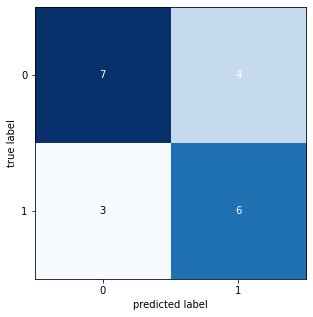

Running Time:  1.5526251000000002
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



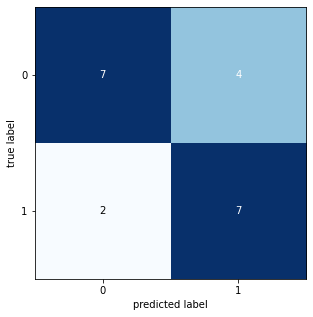

Running Time:  1.5521524000000113
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



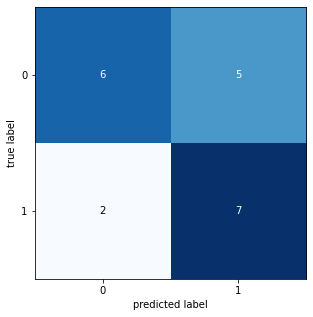

Running Time:  1.5519436999999812
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511278
              precision    recall  f1-score   support

           0       0.62      0.45      0.53        11
           1       0.50      0.67      0.57         9

    accuracy                           0.55        20
   macro avg       0.56      0.56      0.55        20
weighted avg       0.57      0.55      0.55        20



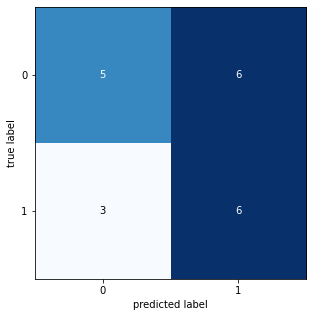

Running Time:  1.5526369000000386
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



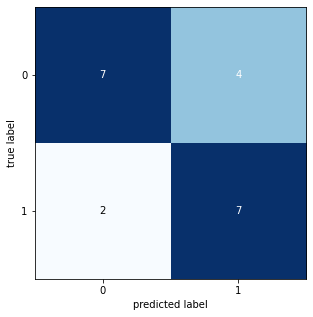

Running Time:  1.5453107999999816
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.56      0.56      0.56         9

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



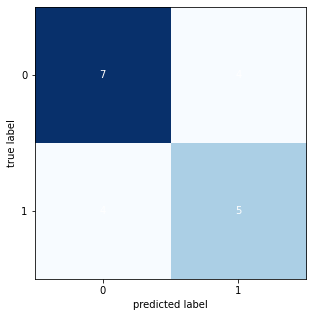

Running Time:  1.5500813000000448
gen terbaik : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.7000000000000001  || Akurasi terbaik : 0.7  || jumlah fitur : 51

Generation : 2
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Sco

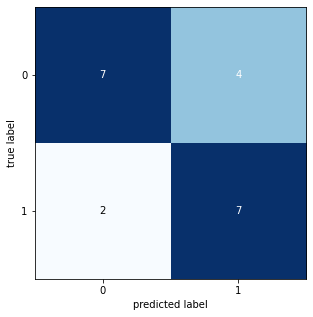

Running Time:  1.7323710000000005
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



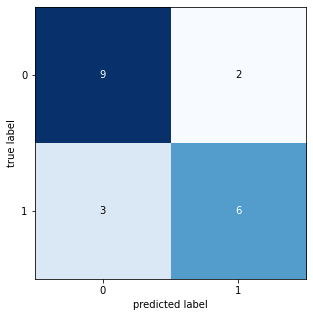

Running Time:  1.5493554999999901
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



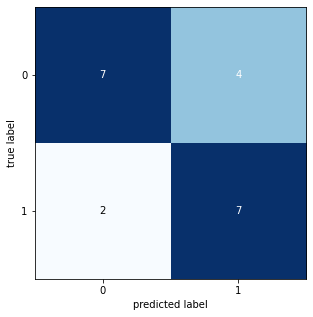

Running Time:  1.5511920000000146
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



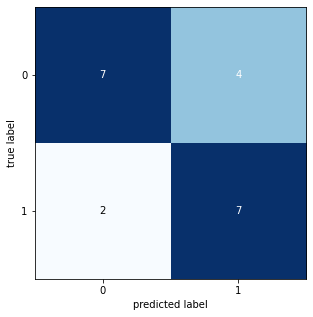

Running Time:  1.5493730999999684
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



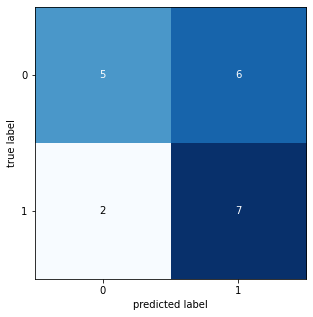

Running Time:  1.5497139999999945
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



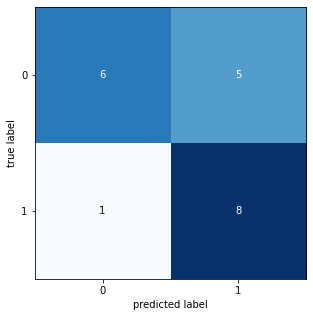

Running Time:  1.5502256999999986
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



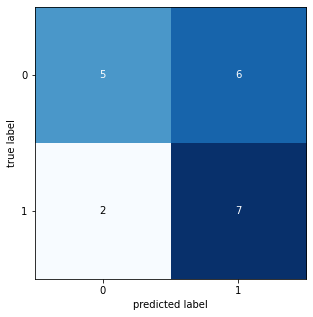

Running Time:  1.5524044000000004
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



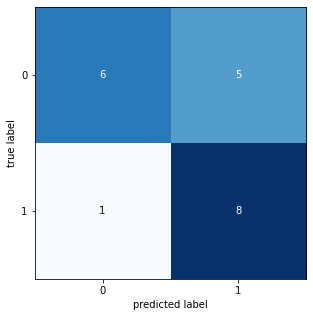

Running Time:  1.5483305999999857
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



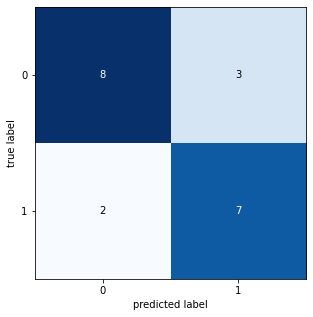

Running Time:  1.7255269999999996
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



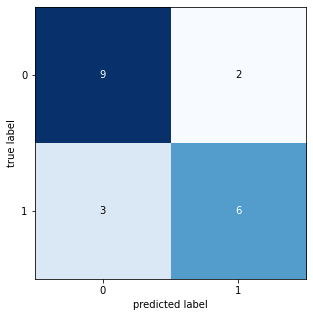

Running Time:  1.5451722999999902
gen terbaik : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.7493734335839599  || Akurasi terbaik : 0.75  || jumlah fitur : 51

Generation : 3
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Sc

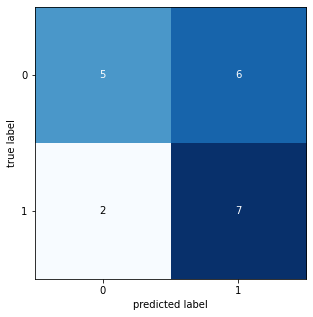

Running Time:  1.5522399000000178
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



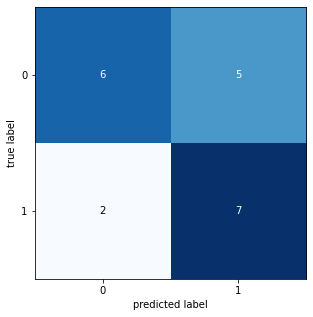

Running Time:  1.5511338000000023
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



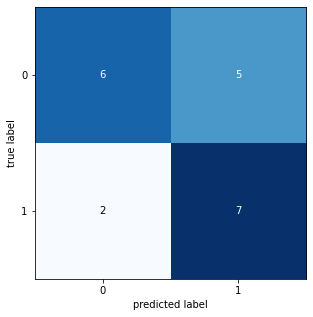

Running Time:  1.5497881999999663
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



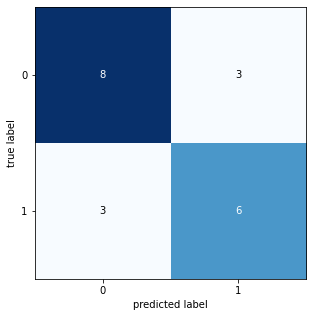

Running Time:  1.5463513999999918
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



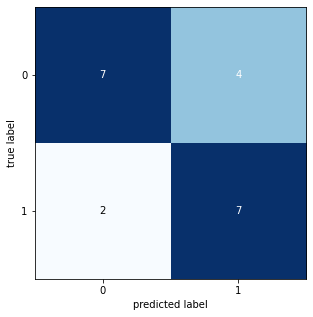

Running Time:  1.5555144999999584
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



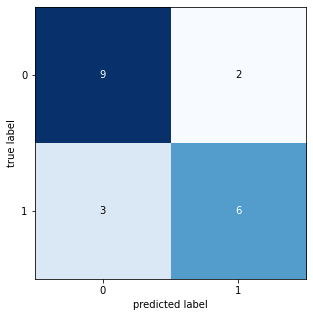

Running Time:  1.5417626999999925
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



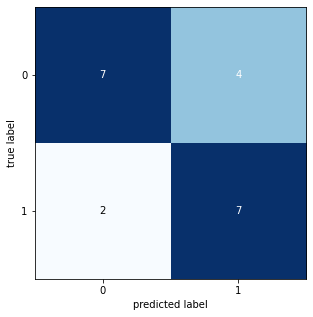

Running Time:  1.7340623999999707
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



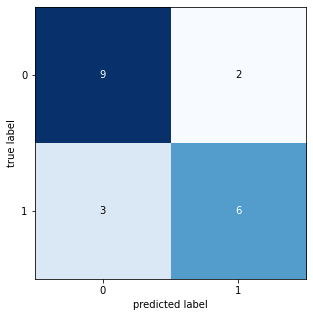

Running Time:  1.5543041000000244
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



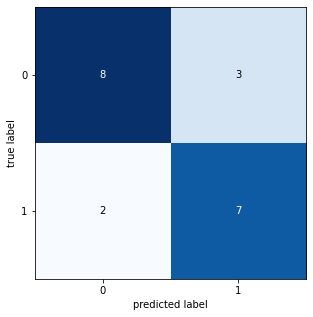

Running Time:  1.5601846000000137
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



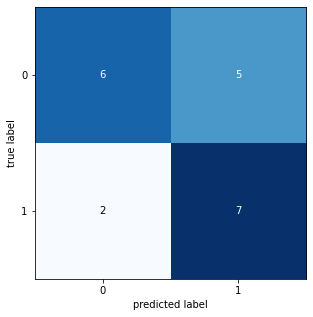

Running Time:  1.5445937000000072
gen terbaik : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.7493734335839599  || Akurasi terbaik : 0.75  || jumlah fitur : 51

Generation : 4
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Sc

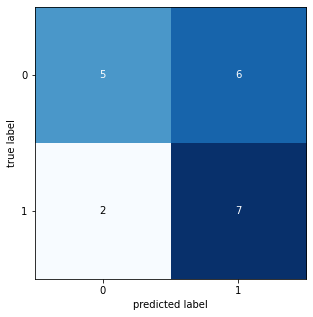

Running Time:  1.554822999999999
gene : [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



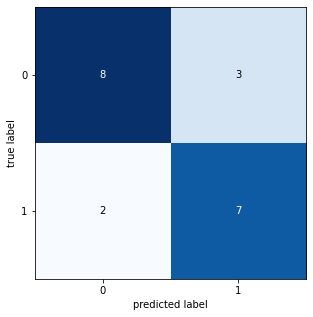

Running Time:  1.5512501000000043
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



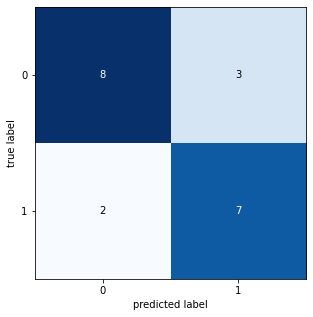

Running Time:  1.5464623999999958
gene : [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



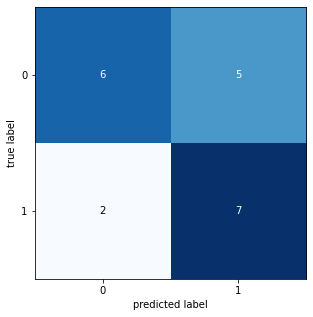

Running Time:  1.5489711999999827
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



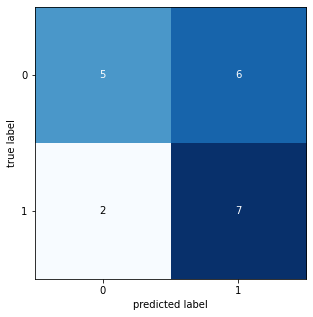

Running Time:  1.7771874000000025
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



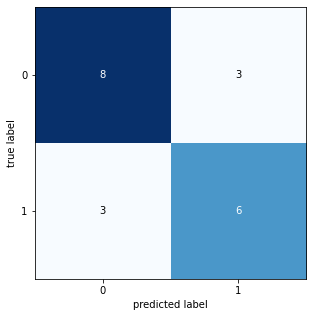

Running Time:  1.5556510000000117
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



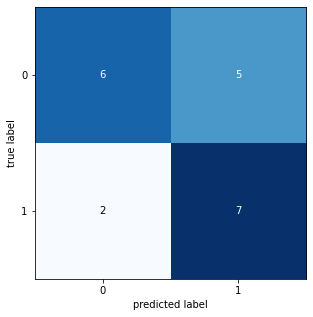

Running Time:  1.546498299999996
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



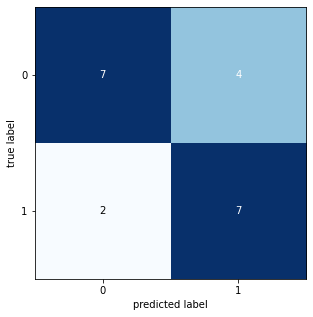

Running Time:  1.5450132999999937
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.7000000000000001
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.64      0.78      0.70         9

    accuracy                           0.70        20
   macro avg       0.71      0.71      0.70        20
weighted avg       0.71      0.70      0.70        20



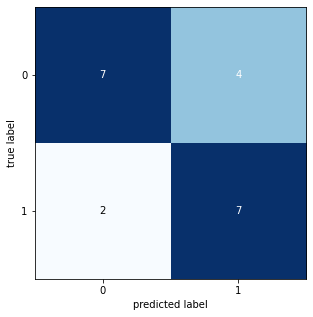

Running Time:  1.552238999999986
gene : [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



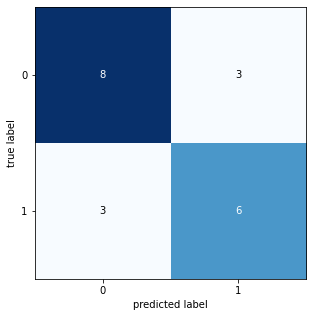

Running Time:  1.5547659000000067
gen terbaik : [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.7493734335839599  || Akurasi terbaik : 0.75  || jumlah fitur : 55

Running Time:  79.57794429999996
breast + IG + GA Orde 3
Generation : 0
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 

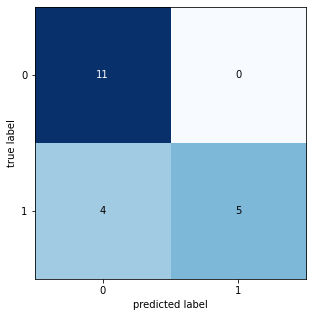

Running Time:  1.5683397999999897
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



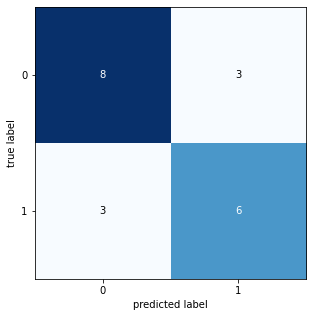

Running Time:  1.559861699999999
gene : [1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511278
              precision    recall  f1-score   support

           0       0.62      0.45      0.53        11
           1       0.50      0.67      0.57         9

    accuracy                           0.55        20
   macro avg       0.56      0.56      0.55        20
weighted avg       0.57      0.55      0.55        20



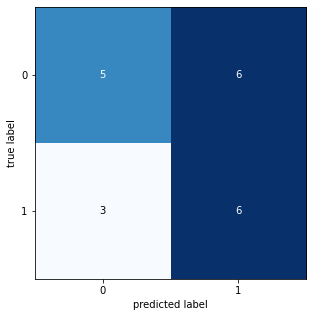

Running Time:  1.7115565999999944
gene : [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511277
              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.50      0.56      0.53         9

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



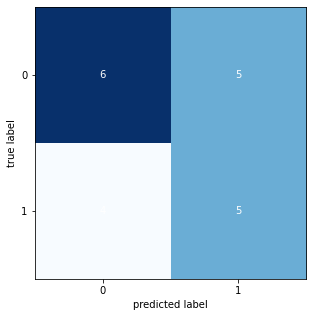

Running Time:  1.5664158000000157
gene : [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



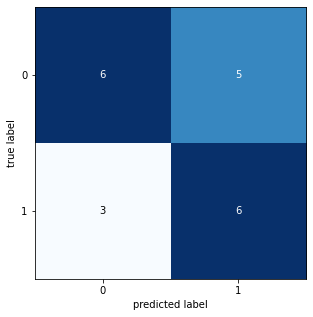

Running Time:  1.5770780000000286
gene : [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



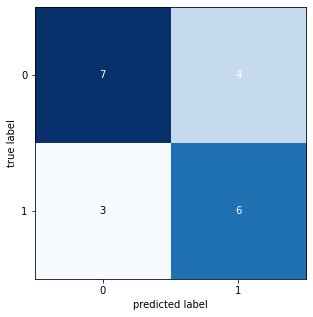

Running Time:  1.5713853000000313
gene : [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



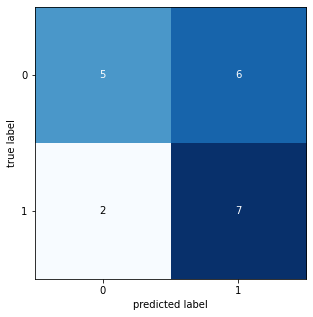

Running Time:  1.5750231999999755
gene : [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



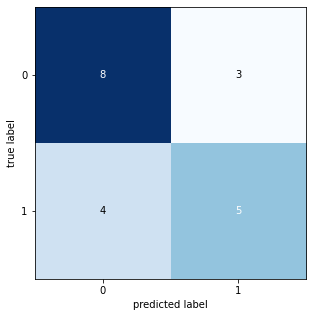

Running Time:  1.5724749999999972
gene : [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



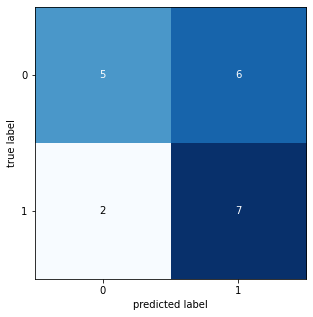

Running Time:  1.5696133000000145
gene : [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.4486215538847118
              precision    recall  f1-score   support

           0       0.50      0.45      0.48        11
           1       0.40      0.44      0.42         9

    accuracy                           0.45        20
   macro avg       0.45      0.45      0.45        20
weighted avg       0.45      0.45      0.45        20



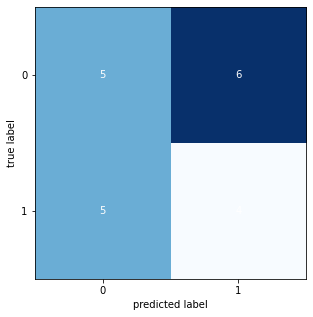

Running Time:  1.7319276999999715
gen terbaik : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.7802197802197801  || Akurasi terbaik : 0.8  || jumlah fitur : 48

Generation : 1
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Sc

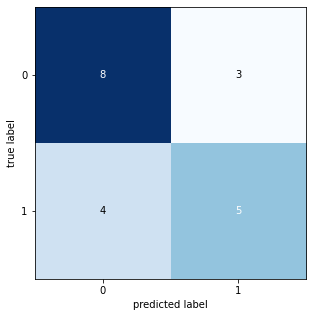

Running Time:  1.566813599999989
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



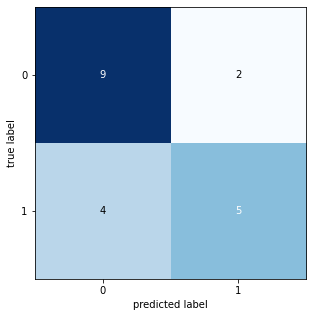

Running Time:  1.570331299999964
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5396419437340154
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.50      0.44      0.47         9

    accuracy                           0.55        20
   macro avg       0.54      0.54      0.54        20
weighted avg       0.55      0.55      0.55        20



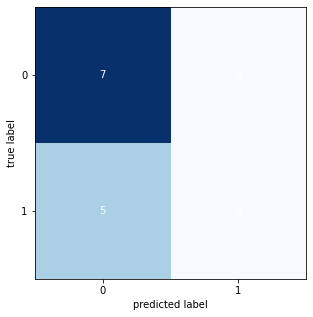

Running Time:  1.5677099999999768
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



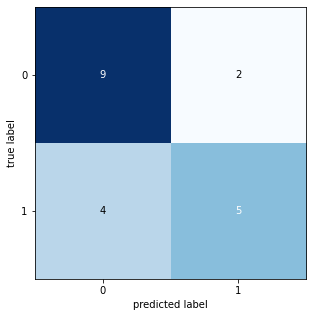

Running Time:  1.567701999999997
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



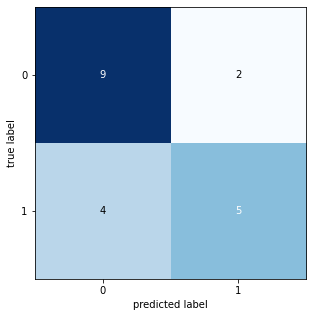

Running Time:  1.5571031000000062
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



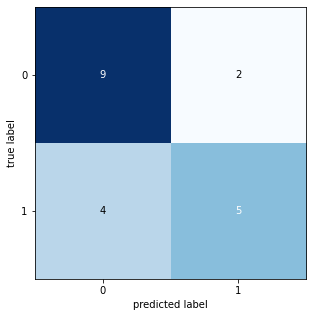

Running Time:  1.559816699999999
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



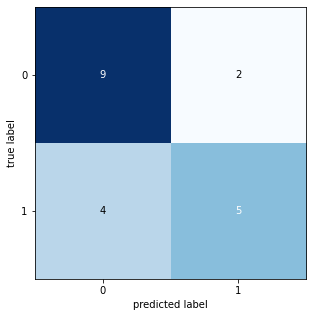

Running Time:  1.5601679000000104
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



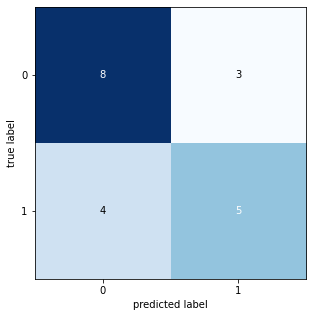

Running Time:  1.732235399999979
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333334
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.83      0.56      0.67         9

    accuracy                           0.75        20
   macro avg       0.77      0.73      0.73        20
weighted avg       0.77      0.75      0.74        20



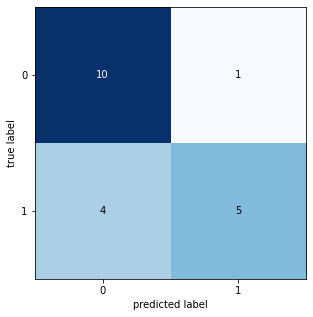

Running Time:  1.5548084999999787
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



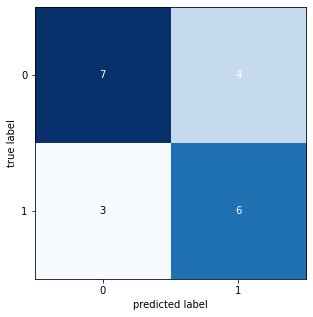

Running Time:  1.5506657000000246
gen terbaik : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.7802197802197801  || Akurasi terbaik : 0.8  || jumlah fitur : 48

Generation : 2
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Sc

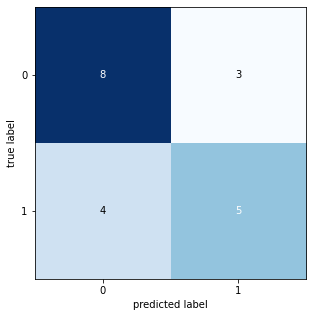

Running Time:  1.5601308000000245
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



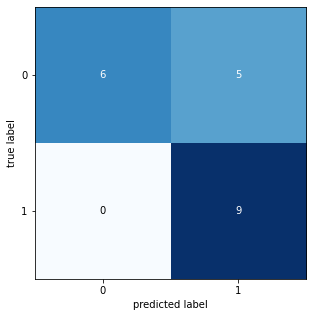

Running Time:  1.5698036999999658
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5833333333333334
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.57      0.44      0.50         9

    accuracy                           0.60        20
   macro avg       0.59      0.59      0.58        20
weighted avg       0.60      0.60      0.59        20



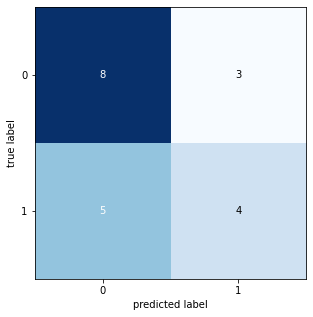

Running Time:  1.5689613000000122
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        11
           1       0.60      0.67      0.63         9

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



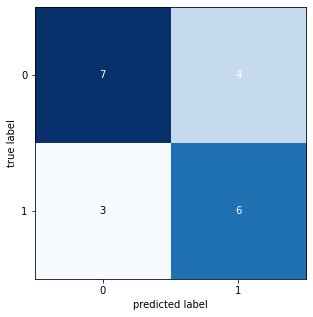

Running Time:  1.5536865999999918
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



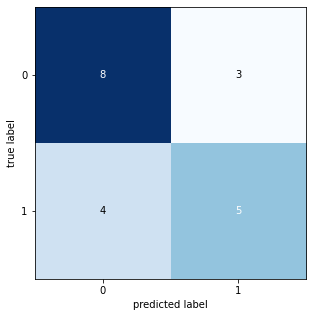

Running Time:  1.5554197000000158
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



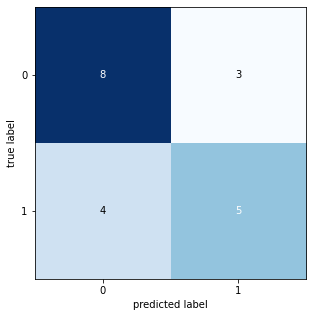

Running Time:  1.7220343000000184
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6703296703296703
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.80      0.44      0.57         9

    accuracy                           0.70        20
   macro avg       0.73      0.68      0.67        20
weighted avg       0.73      0.70      0.68        20



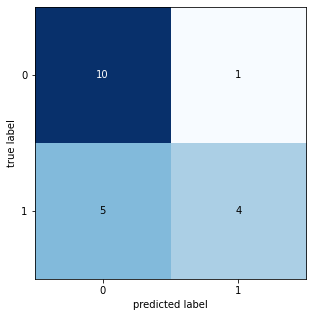

Running Time:  1.5497105000000033
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5833333333333334
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.57      0.44      0.50         9

    accuracy                           0.60        20
   macro avg       0.59      0.59      0.58        20
weighted avg       0.60      0.60      0.59        20



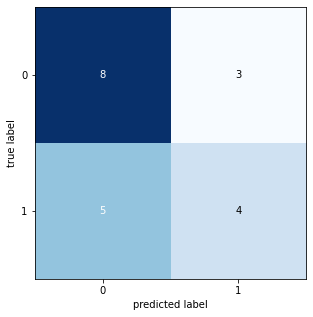

Running Time:  1.5669962999999711
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



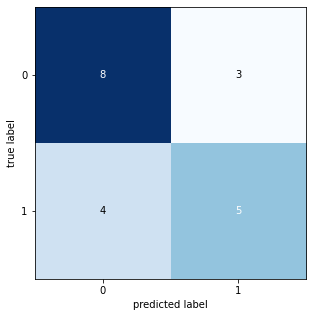

Running Time:  1.5712358000000108
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



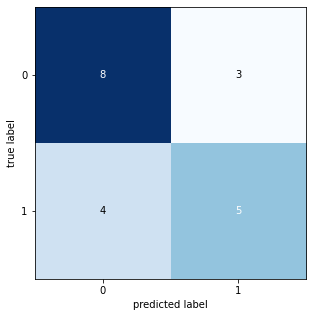

Running Time:  1.563672399999973
gen terbaik : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.7802197802197801  || Akurasi terbaik : 0.8  || jumlah fitur : 48

Generation : 3
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Scor

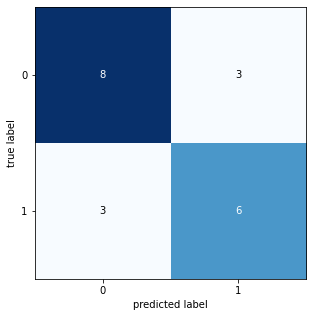

Running Time:  1.5697101999999745
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



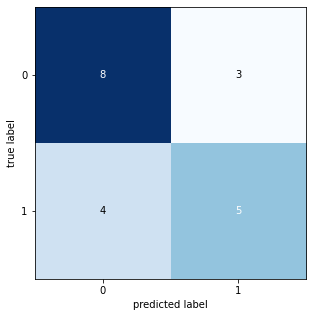

Running Time:  1.5729527000000303
gene : [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6266666666666667
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.67      0.44      0.53         9

    accuracy                           0.65        20
   macro avg       0.65      0.63      0.63        20
weighted avg       0.65      0.65      0.64        20



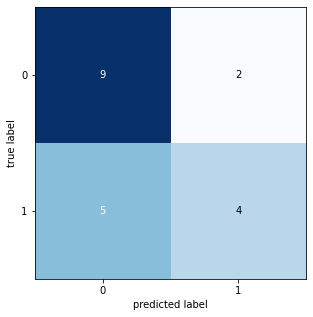

Running Time:  1.5761028999999667
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



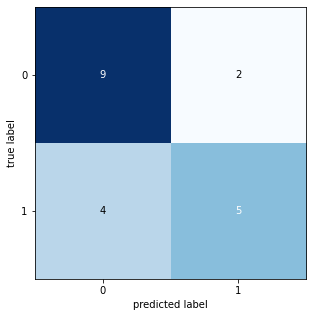

Running Time:  1.7502293000000009
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5833333333333334
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.57      0.44      0.50         9

    accuracy                           0.60        20
   macro avg       0.59      0.59      0.58        20
weighted avg       0.60      0.60      0.59        20



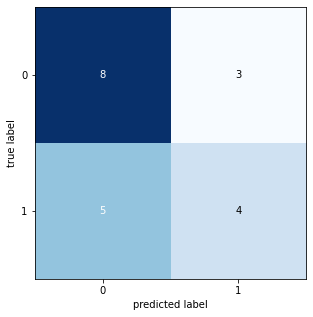

Running Time:  1.5724726999999916
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



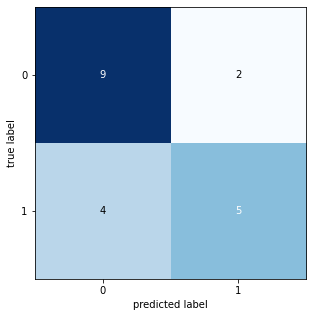

Running Time:  1.567891799999984
gene : [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.56      0.56      0.56         9

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



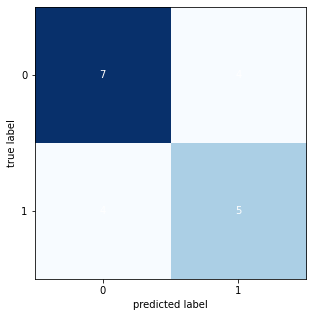

Running Time:  1.5642463000000362
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



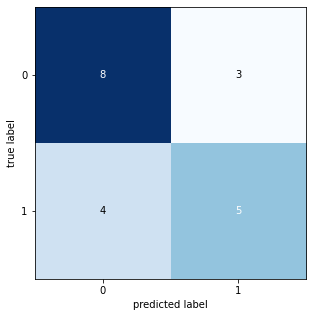

Running Time:  1.554914999999994
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333334
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.83      0.56      0.67         9

    accuracy                           0.75        20
   macro avg       0.77      0.73      0.73        20
weighted avg       0.77      0.75      0.74        20



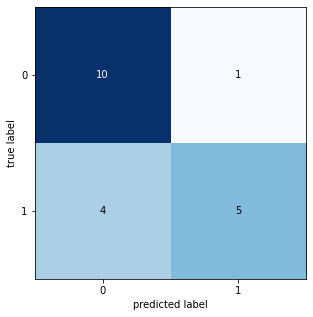

Running Time:  1.5690023000000224
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5833333333333334
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.57      0.44      0.50         9

    accuracy                           0.60        20
   macro avg       0.59      0.59      0.58        20
weighted avg       0.60      0.60      0.59        20



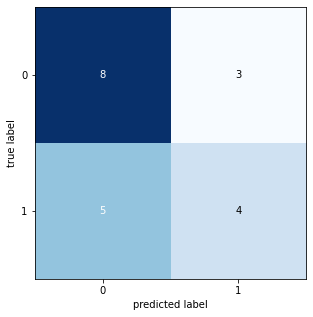

Running Time:  1.5534585000000334
gen terbaik : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.7802197802197801  || Akurasi terbaik : 0.8  || jumlah fitur : 48

Generation : 4
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Sco

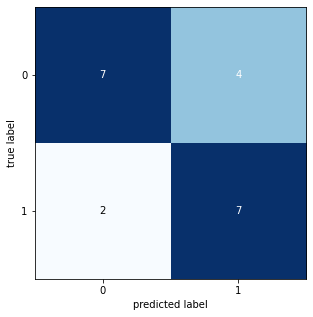

Running Time:  1.5747291000000132
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



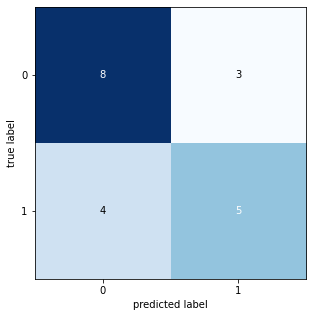

Running Time:  1.738486000000023
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875000000000001
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.71      0.56      0.63         9

    accuracy                           0.70        20
   macro avg       0.70      0.69      0.69        20
weighted avg       0.70      0.70      0.69        20



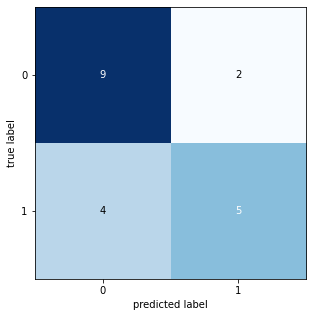

Running Time:  1.5598729999999819
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



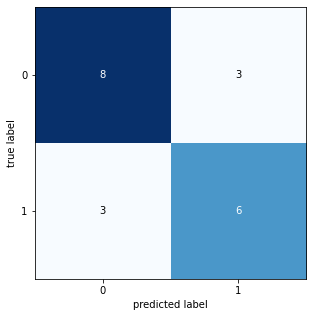

Running Time:  1.570357300000012
gene : [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5833333333333334
              precision    recall  f1-score   support

           0       0.62      0.73      0.67        11
           1       0.57      0.44      0.50         9

    accuracy                           0.60        20
   macro avg       0.59      0.59      0.58        20
weighted avg       0.60      0.60      0.59        20



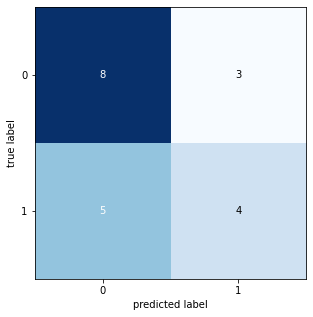

Running Time:  1.5614559999999642
gene : [1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



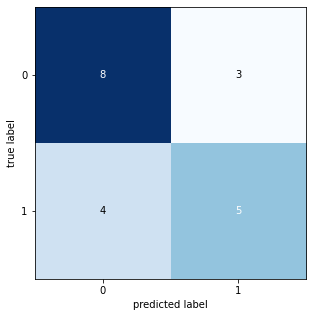

Running Time:  1.561933100000033
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333334
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.83      0.56      0.67         9

    accuracy                           0.75        20
   macro avg       0.77      0.73      0.73        20
weighted avg       0.77      0.75      0.74        20



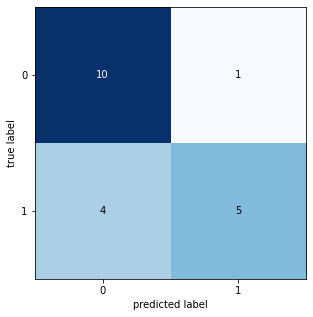

Running Time:  1.5603437999999983
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



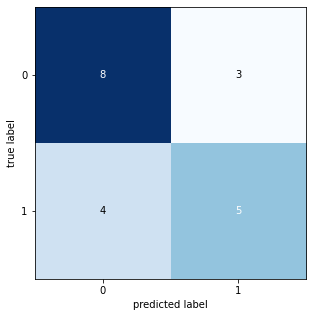

Running Time:  1.5760237000000075
gene : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



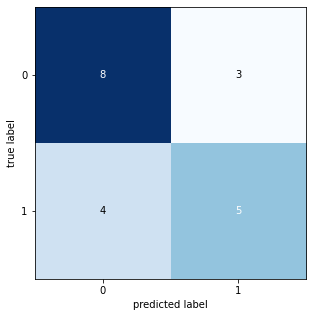

Running Time:  1.560061399999995
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.67      0.67      0.67         9

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20



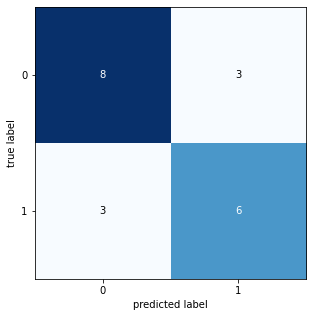

Running Time:  1.770923699999969
gen terbaik : [1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.7802197802197801  || Akurasi terbaik : 0.8  || jumlah fitur : 48

Running Time:  80.39336909999997
breast + IG + GA Orde 4
Generation : 0
gene : [0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 

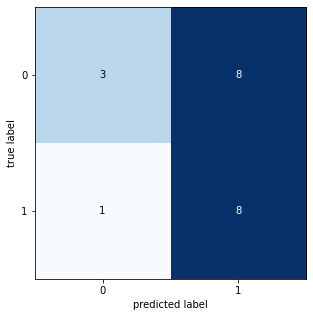

Running Time:  1.5869398999999476
gene : [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.4486215538847118
              precision    recall  f1-score   support

           0       0.50      0.45      0.48        11
           1       0.40      0.44      0.42         9

    accuracy                           0.45        20
   macro avg       0.45      0.45      0.45        20
weighted avg       0.45      0.45      0.45        20



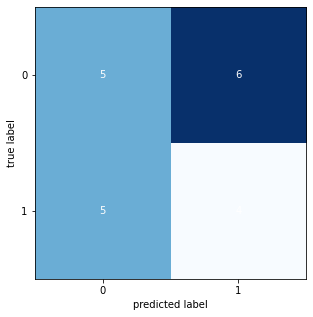

Running Time:  1.5715457999999671
gene : [0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511278
              precision    recall  f1-score   support

           0       0.62      0.45      0.53        11
           1       0.50      0.67      0.57         9

    accuracy                           0.55        20
   macro avg       0.56      0.56      0.55        20
weighted avg       0.57      0.55      0.55        20



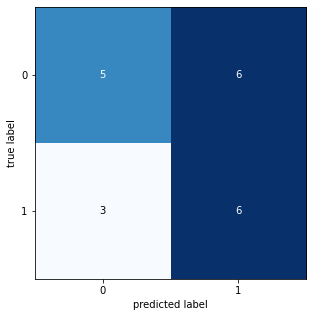

Running Time:  1.5944326000000046
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



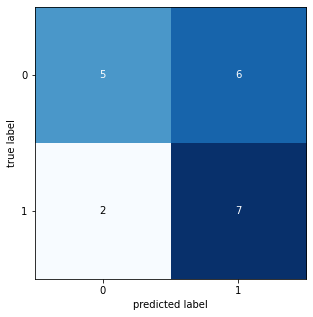

Running Time:  1.585719900000015
gene : [1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



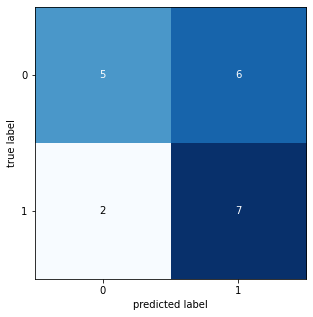

Running Time:  1.5852394000000345
gene : [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.5
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        11
           1       0.45      0.56      0.50         9

    accuracy                           0.50        20
   macro avg       0.51      0.51      0.50        20
weighted avg       0.51      0.50      0.50        20



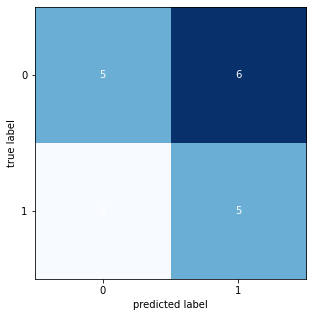

Running Time:  1.5976394000000482
gene : [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



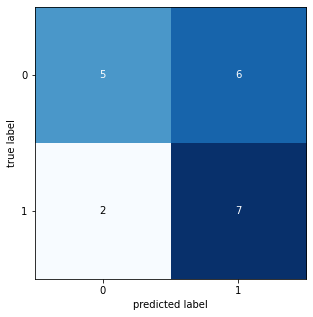

Running Time:  1.7218380999999567
gene : [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.5
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        11
           1       0.45      0.56      0.50         9

    accuracy                           0.50        20
   macro avg       0.51      0.51      0.50        20
weighted avg       0.51      0.50      0.50        20



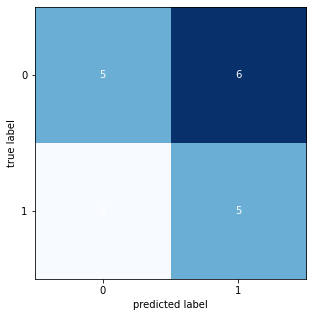

Running Time:  1.5969910999999684
gene : [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5396419437340154
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.50      0.78      0.61         9

    accuracy                           0.55        20
   macro avg       0.58      0.57      0.54        20
weighted avg       0.59      0.55      0.53        20



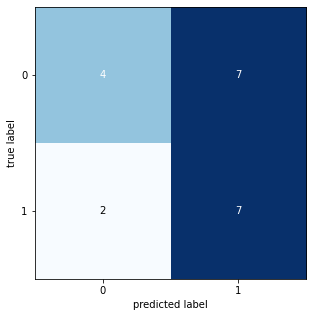

Running Time:  1.5816003999999566
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



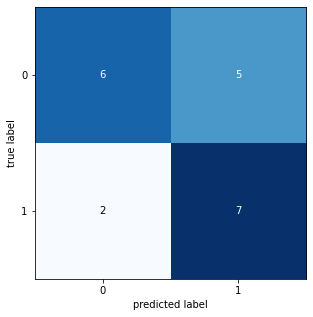

Running Time:  1.5890509999999836
gen terbaik : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1]
F-1 Score terbaik : 0.6491228070175439  || Akurasi terbaik : 0.65  || jumlah fitur : 48

Generation : 1
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_S

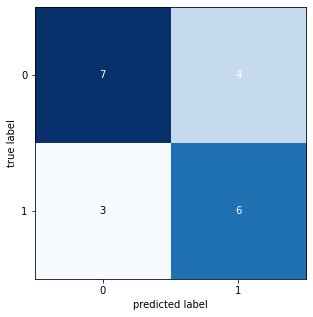

Running Time:  1.5737192999999934
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.494949494949495
              precision    recall  f1-score   support

           0       0.57      0.36      0.44        11
           1       0.46      0.67      0.55         9

    accuracy                           0.50        20
   macro avg       0.52      0.52      0.49        20
weighted avg       0.52      0.50      0.49        20



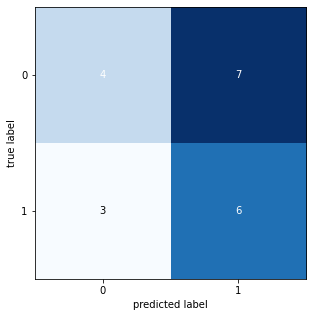

Running Time:  1.5917045999999573
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.57      0.89      0.70         9

    accuracy                           0.65        20
   macro avg       0.70      0.67      0.64        20
weighted avg       0.72      0.65      0.64        20



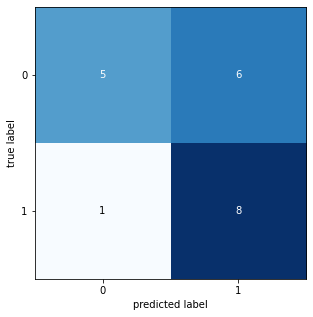

Running Time:  1.5874147000000107
gene : [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5
F1_Score :  0.494949494949495
              precision    recall  f1-score   support

           0       0.57      0.36      0.44        11
           1       0.46      0.67      0.55         9

    accuracy                           0.50        20
   macro avg       0.52      0.52      0.49        20
weighted avg       0.52      0.50      0.49        20



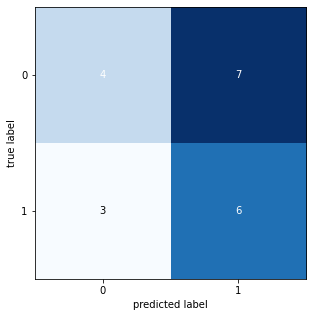

Running Time:  1.5821596000000113
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



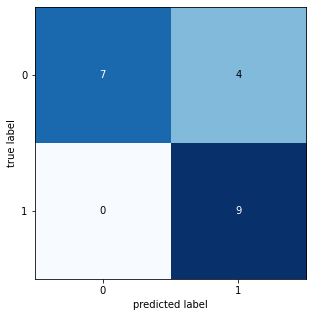

Running Time:  1.7746252999999683
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.45
F1_Score :  0.4486215538847118
              precision    recall  f1-score   support

           0       0.50      0.36      0.42        11
           1       0.42      0.56      0.48         9

    accuracy                           0.45        20
   macro avg       0.46      0.46      0.45        20
weighted avg       0.46      0.45      0.45        20



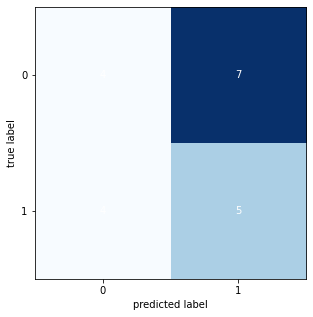

Running Time:  1.5728230999999937
gene : [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5488721804511277
              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.50      0.56      0.53         9

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



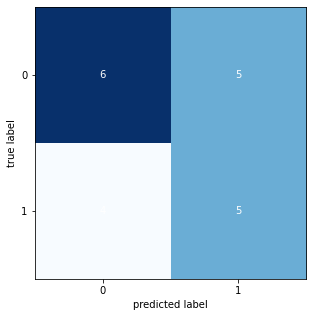

Running Time:  1.5721467999999845
gene : [1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5396419437340154
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.50      0.78      0.61         9

    accuracy                           0.55        20
   macro avg       0.58      0.57      0.54        20
weighted avg       0.59      0.55      0.53        20



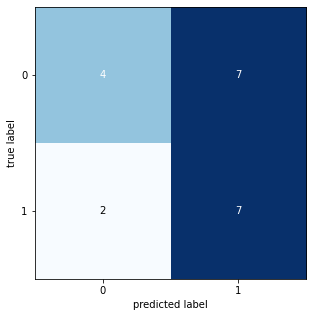

Running Time:  1.5730919000000085
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6491228070175439
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.58      0.78      0.67         9

    accuracy                           0.65        20
   macro avg       0.67      0.66      0.65        20
weighted avg       0.68      0.65      0.65        20



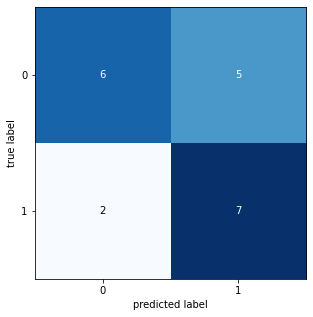

Running Time:  1.5736201000000278
gene : [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.55
F1_Score :  0.5396419437340154
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.50      0.78      0.61         9

    accuracy                           0.55        20
   macro avg       0.58      0.57      0.54        20
weighted avg       0.59      0.55      0.53        20



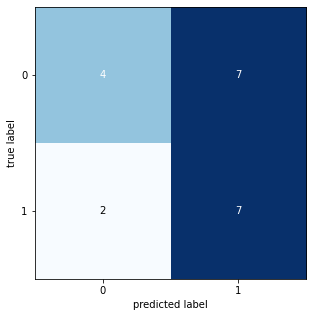

Running Time:  1.5741413999999736
gen terbaik : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.797979797979798  || Akurasi terbaik : 0.8  || jumlah fitur : 49

Generation : 2
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Scor

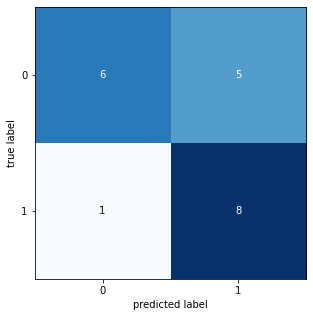

Running Time:  1.5726472999999714
gene : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.80      0.89      0.84         9

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20



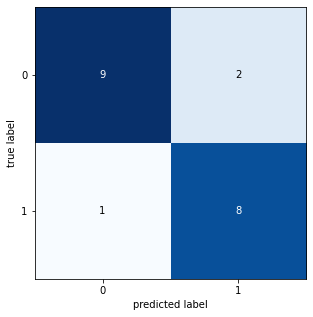

Running Time:  1.5667349999999942
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



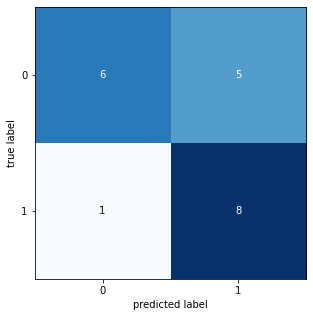

Running Time:  1.7619311999999923
gene : [0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



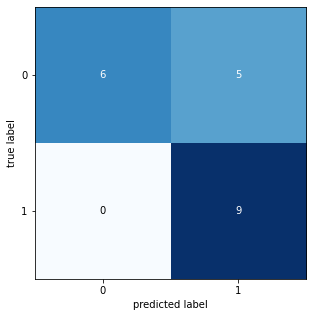

Running Time:  1.5661146999999573
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



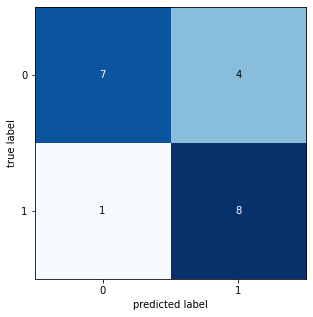

Running Time:  1.5754790999999955
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.65
F1_Score :  0.6419437340153453
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.57      0.89      0.70         9

    accuracy                           0.65        20
   macro avg       0.70      0.67      0.64        20
weighted avg       0.72      0.65      0.64        20



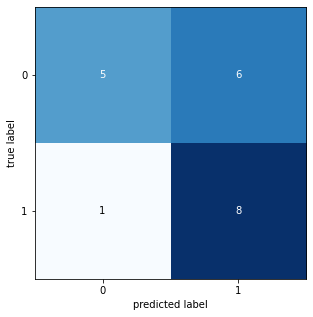

Running Time:  1.5792294999999967
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



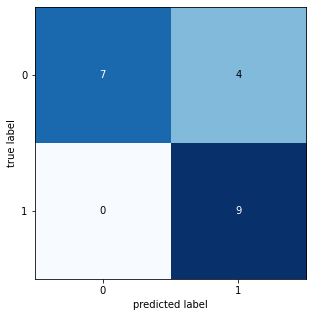

Running Time:  1.5641833000000247
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



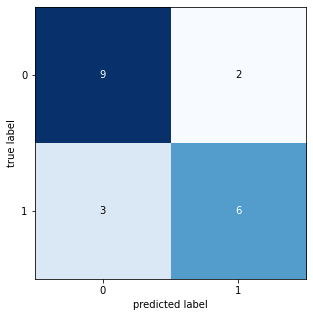

Running Time:  1.5795181999999954
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



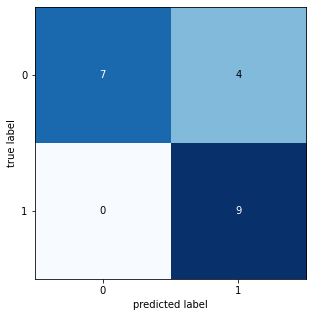

Running Time:  1.563592299999982
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.6
              precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.55      0.67      0.60         9

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20



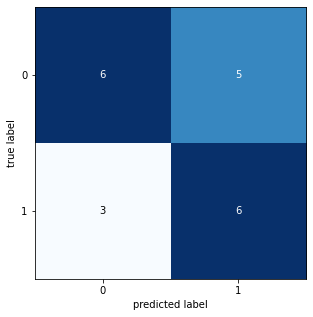

Running Time:  1.568995099999995
gen terbaik : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 49

Generation : 3
gene : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Scor

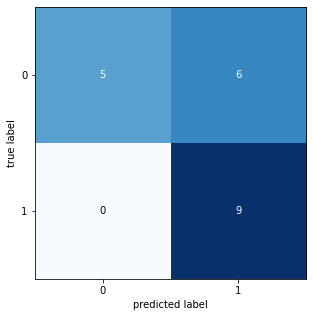

Running Time:  1.755498399999965
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



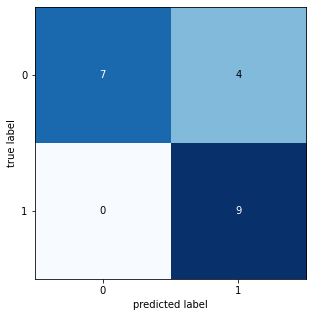

Running Time:  1.5678908000000433
gene : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



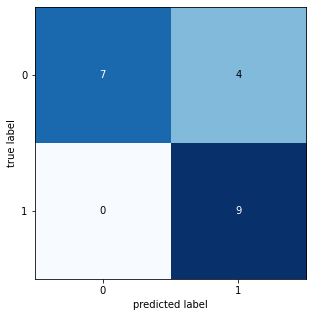

Running Time:  1.6486595999999736
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



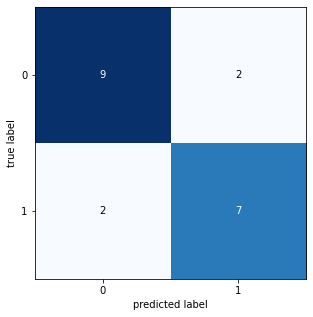

Running Time:  1.5753675000000271
gene : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333334
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.83      0.56      0.67         9

    accuracy                           0.75        20
   macro avg       0.77      0.73      0.73        20
weighted avg       0.77      0.75      0.74        20



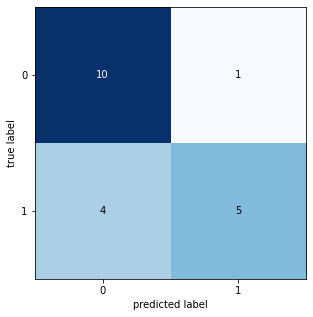

Running Time:  1.573635299999978
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.88      0.64      0.74        11
           1       0.67      0.89      0.76         9

    accuracy                           0.75        20
   macro avg       0.77      0.76      0.75        20
weighted avg       0.78      0.75      0.75        20



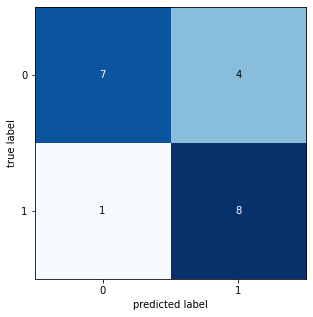

Running Time:  1.577792200000033
gene : [0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.696969696969697
              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.62      0.89      0.73         9

    accuracy                           0.70        20
   macro avg       0.74      0.72      0.70        20
weighted avg       0.75      0.70      0.69        20



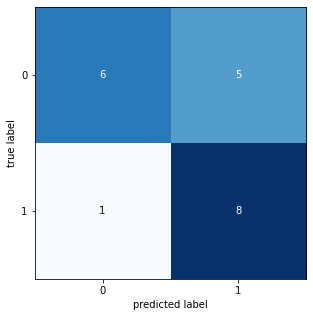

Running Time:  1.5759924000000183
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



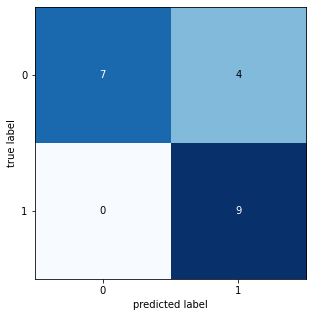

Running Time:  1.573317099999997
gene : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.849624060150376
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.75      1.00      0.86         9

    accuracy                           0.85        20
   macro avg       0.88      0.86      0.85        20
weighted avg       0.89      0.85      0.85        20



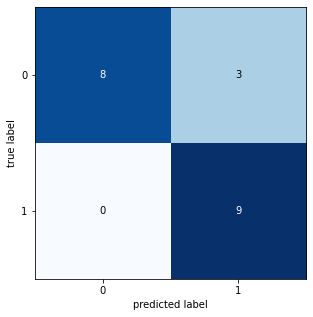

Running Time:  1.7671902999999816
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.75      0.67      0.71         9

    accuracy                           0.75        20
   macro avg       0.75      0.74      0.74        20
weighted avg       0.75      0.75      0.75        20



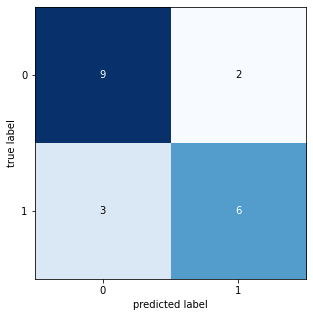

Running Time:  1.5739872000000332
gen terbaik : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.849624060150376  || Akurasi terbaik : 0.85  || jumlah fitur : 49

Generation : 4
gene : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Sco

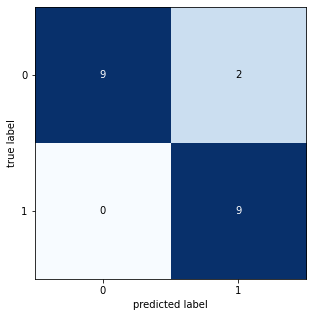

Running Time:  1.5835208999999963
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7493734335839599
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.70      0.78      0.74         9

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.76      0.75      0.75        20



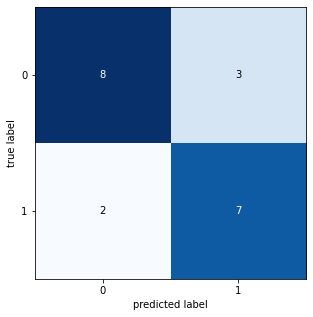

Running Time:  1.5746095999999739
gene : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.9
F1_Score :  0.9
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.82      1.00      0.90         9

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.90        20
weighted avg       0.92      0.90      0.90        20



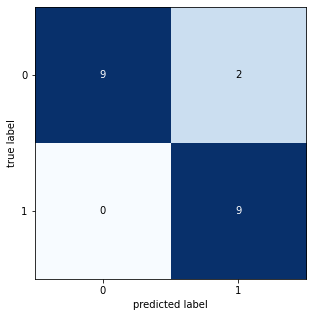

Running Time:  1.5771945000000187
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7333333333333334
              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       0.83      0.56      0.67         9

    accuracy                           0.75        20
   macro avg       0.77      0.73      0.73        20
weighted avg       0.77      0.75      0.74        20



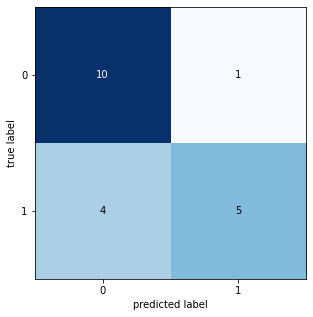

Running Time:  1.579767400000037
gene : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.75
F1_Score :  0.7442455242966752
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.64      1.00      0.78         9

    accuracy                           0.75        20
   macro avg       0.82      0.77      0.74        20
weighted avg       0.84      0.75      0.74        20



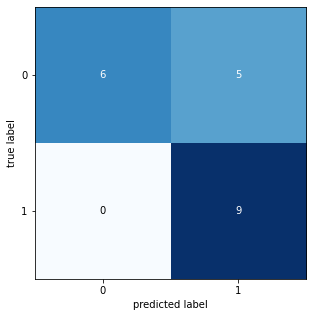

Running Time:  1.5692846999999688
gene : [0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.595959595959596
              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.54      0.78      0.64         9

    accuracy                           0.60        20
   macro avg       0.63      0.62      0.60        20
weighted avg       0.64      0.60      0.59        20



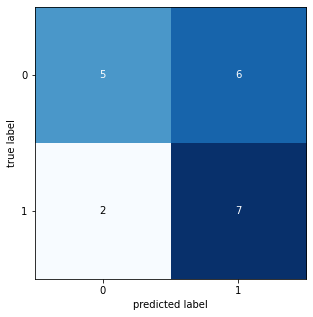

Running Time:  1.5676864999999793
gene : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.85
F1_Score :  0.8465473145780051
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.88      0.78      0.82         9

    accuracy                           0.85        20
   macro avg       0.85      0.84      0.85        20
weighted avg       0.85      0.85      0.85        20



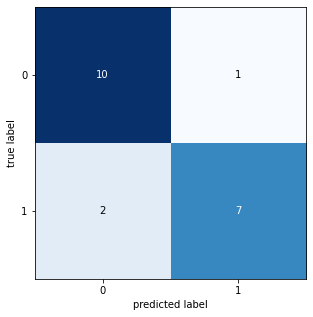

Running Time:  1.766144899999972
gene : [0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6
F1_Score :  0.5833333333333335
              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.53      0.89      0.67         9

    accuracy                           0.60        20
   macro avg       0.67      0.63      0.58        20
weighted avg       0.68      0.60      0.58        20



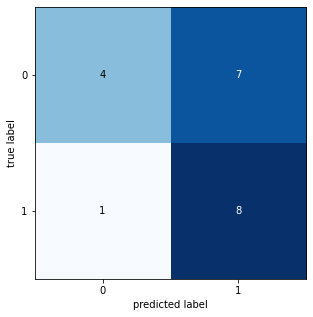

Running Time:  1.567244399999936
gene : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7
F1_Score :  0.6875
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.60      1.00      0.75         9

    accuracy                           0.70        20
   macro avg       0.80      0.73      0.69        20
weighted avg       0.82      0.70      0.68        20



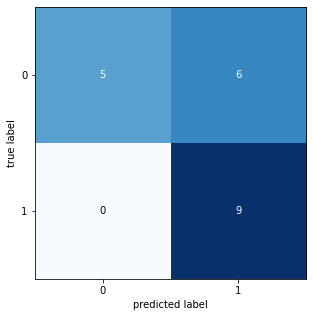

Running Time:  1.583947099999932
gene : [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Y_Test : [1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8
F1_Score :  0.797979797979798
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.69      1.00      0.82         9

    accuracy                           0.80        20
   macro avg       0.85      0.82      0.80        20
weighted avg       0.86      0.80      0.80        20



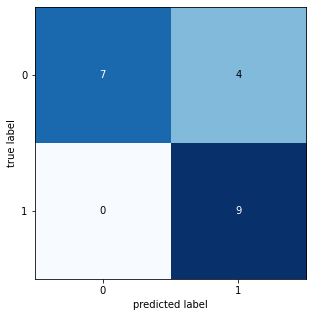

Running Time:  1.5762330999999676
gen terbaik : [0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]
F-1 Score terbaik : 0.9  || Akurasi terbaik : 0.9  || jumlah fitur : 47

Running Time:  80.94978139999995
Train :  [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 26
 28 29 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 56
 57 59 60 62 65 66 67 68 69 71 74 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 91 92 93 94 96] Test :  [ 2 20 25 27 30 31 37 39 47 58 61 63 64 70 72 73 75 89 95]
train:  (78, 101)
test:  (19, 101)
Running Time:  23.824901000000068
breast + IG Orde 2
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

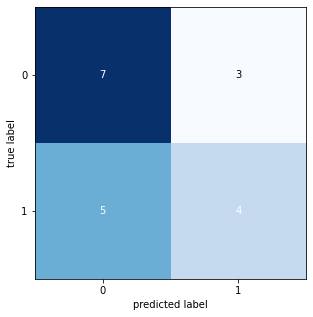

Running Time:  1.5499562999999625
breast + IG Orde 3
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



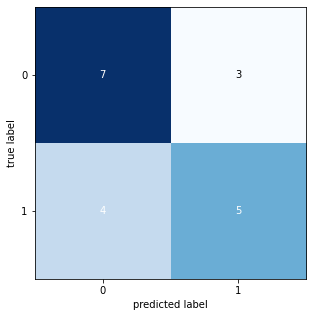

Running Time:  1.6121212999998988
breast + IG Orde 4
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



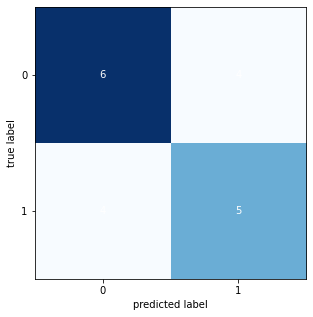

Running Time:  1.6256782000000385
breast + IG + GA Orde 2
Generation : 0
gene : [0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.4602272727272727
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.43      0.33      0.38         9

    accuracy                           0.47        19
   macro avg       0.46      0.47      0.46        19
weighted avg       0.47      0.47      0.46        19



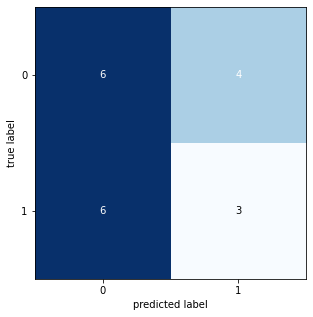

Running Time:  1.7206964999999173
gene : [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5043478260869565
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.50      0.33      0.40         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.50        19
weighted avg       0.52      0.53      0.51        19



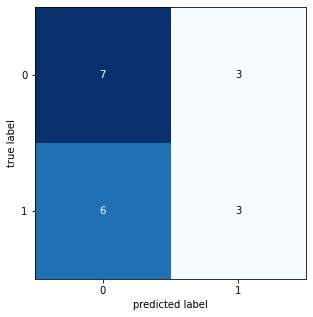

Running Time:  1.5245457999999417
gene : [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



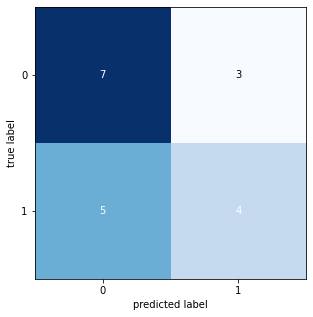

Running Time:  1.552590900000041
gene : [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613445
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.50      0.44      0.47         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



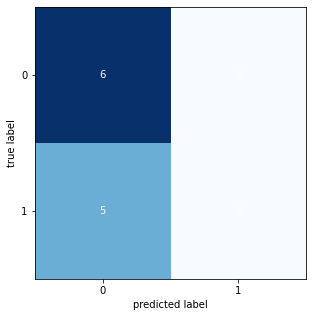

Running Time:  1.5495345000000498
gene : [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.4602272727272727
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.43      0.33      0.38         9

    accuracy                           0.47        19
   macro avg       0.46      0.47      0.46        19
weighted avg       0.47      0.47      0.46        19



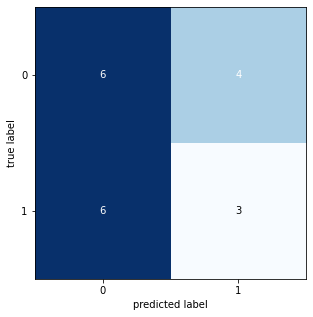

Running Time:  1.5458188000000064
gene : [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613445
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.50      0.44      0.47         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



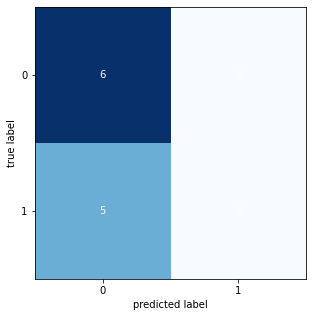

Running Time:  1.5541507000000365
gene : [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5043478260869565
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.50      0.33      0.40         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.50        19
weighted avg       0.52      0.53      0.51        19



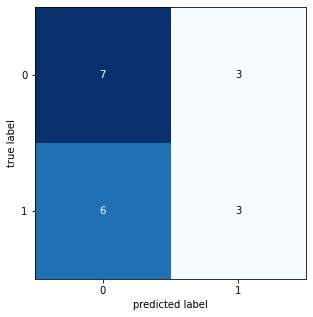

Running Time:  1.5508273000000372
gene : [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



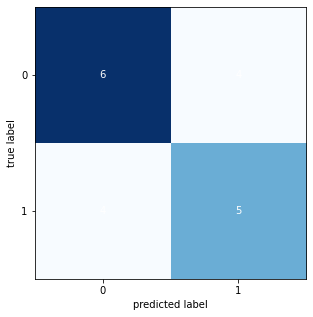

Running Time:  1.6963817000000745
gene : [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



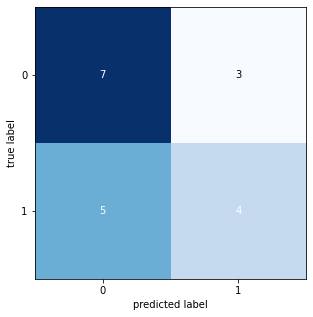

Running Time:  1.5436521999999968
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



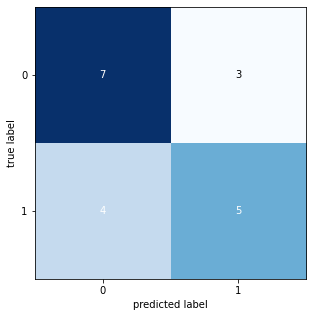

Running Time:  1.5386564000000362
gen terbaik : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
F-1 Score terbaik : 0.6274509803921569  || Akurasi terbaik : 0.631578947368421  || jumlah fitur : 36

Generation : 1
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi

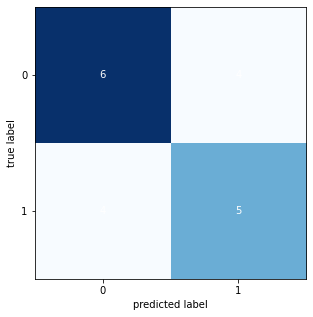

Running Time:  1.5485515999999961
gene : [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613445
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.50      0.44      0.47         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



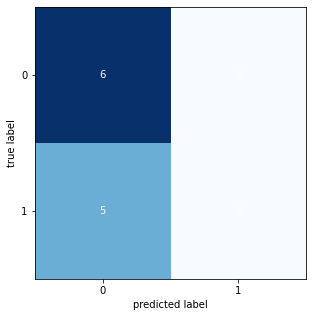

Running Time:  1.556443100000024
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



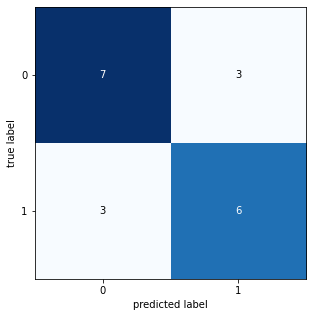

Running Time:  1.545044100000041
gene : [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



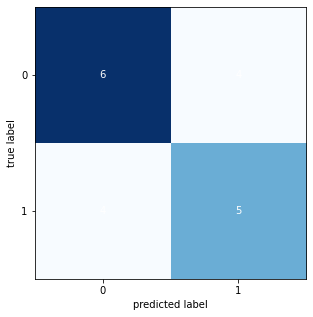

Running Time:  1.5568691000000854
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



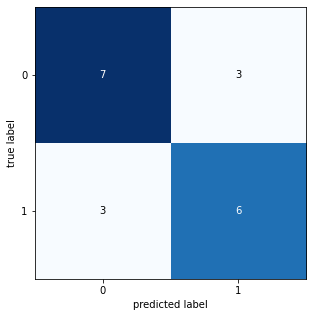

Running Time:  1.5436786999999867
gene : [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



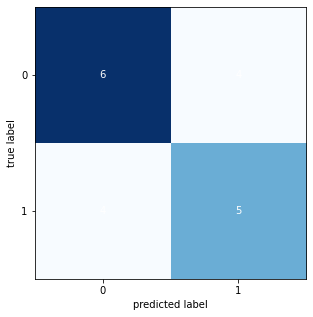

Running Time:  1.7256504000000632
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



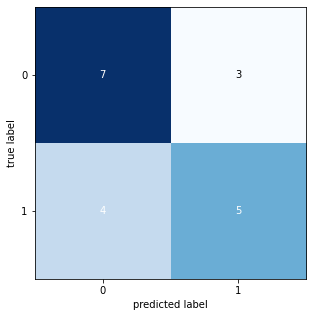

Running Time:  1.549846099999968
gene : [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



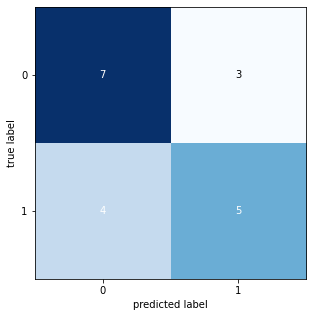

Running Time:  1.5536035000000084
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



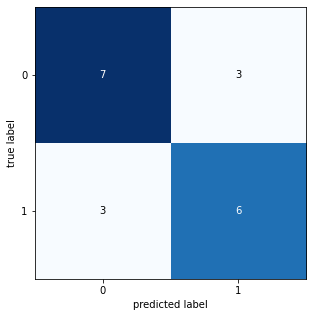

Running Time:  1.5516968999999108
gene : [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



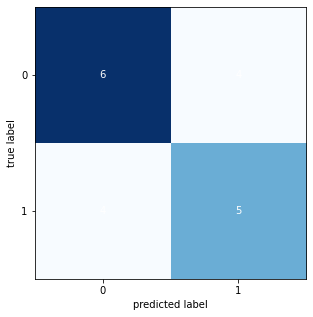

Running Time:  1.5558763999999883
gen terbaik : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 36

Generation : 2
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akuras

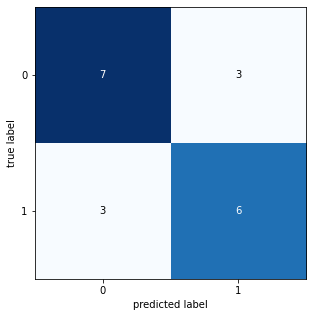

Running Time:  1.5448461000000862
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



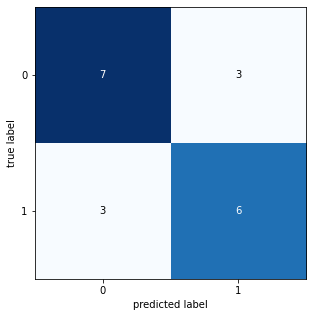

Running Time:  1.543192500000032
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



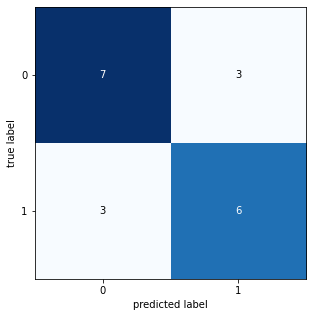

Running Time:  1.5494346000000405
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



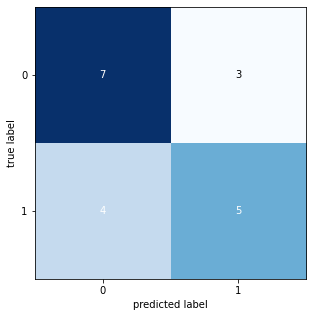

Running Time:  1.7241331000000173
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



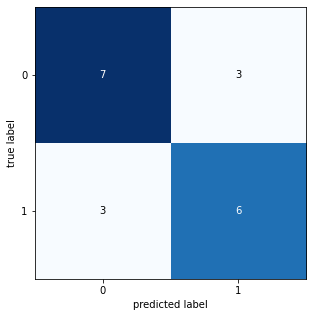

Running Time:  1.54374329999996
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



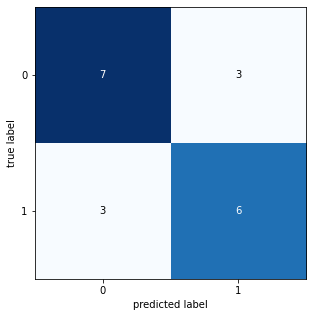

Running Time:  1.5503888000000643
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



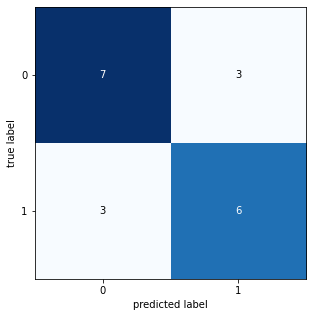

Running Time:  1.5498495000000503
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



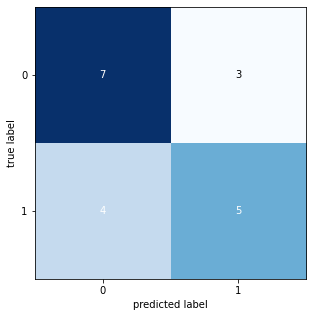

Running Time:  1.5399605999999721
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



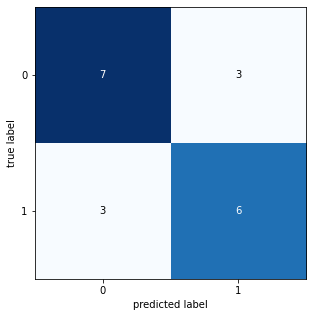

Running Time:  1.545597300000054
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



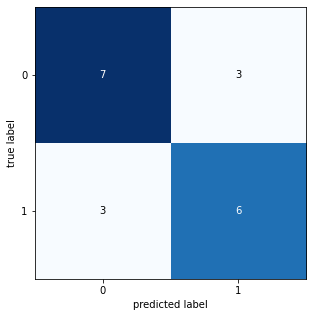

Running Time:  1.5613763000000063
gen terbaik : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 38

Generation : 3
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akuras

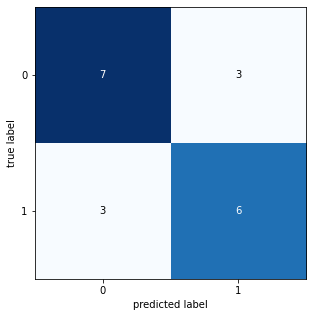

Running Time:  1.5492593999999826
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



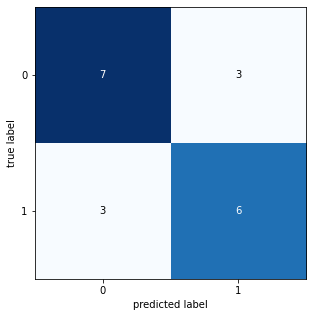

Running Time:  1.7274231999999756
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



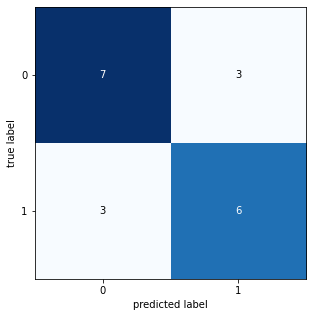

Running Time:  1.543243099999927
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



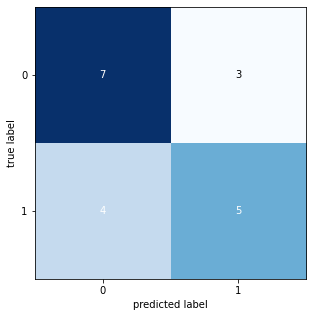

Running Time:  1.5389394999999695
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



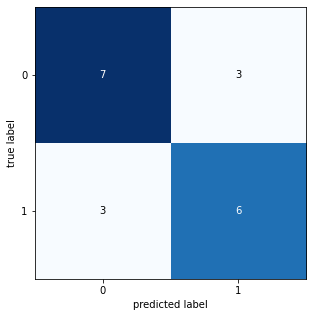

Running Time:  1.5474739
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



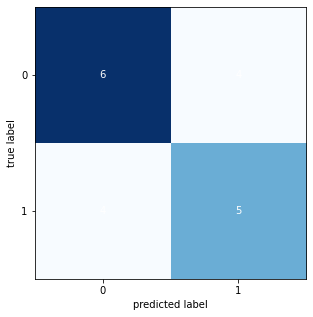

Running Time:  1.536716599999977
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



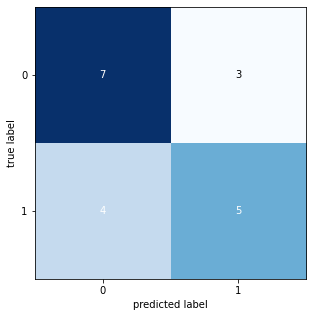

Running Time:  1.5418288000000757
gene : [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



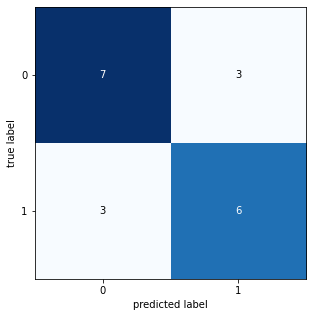

Running Time:  1.545293900000047
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



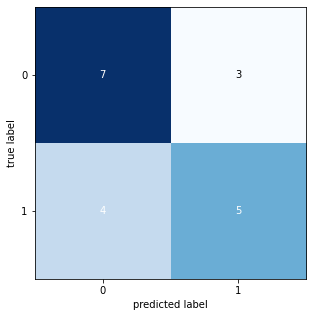

Running Time:  1.5418575999999575
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



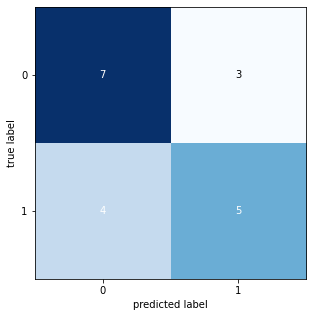

Running Time:  1.7282896000000392
gen terbaik : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 37

Generation : 4
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akuras

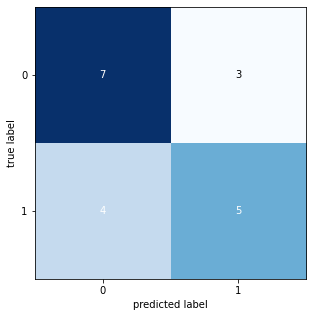

Running Time:  1.5464238000000705
gene : [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



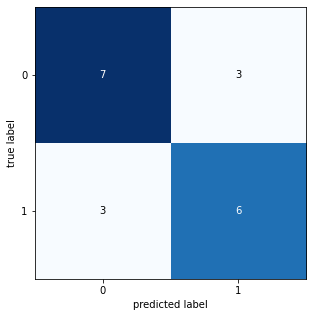

Running Time:  1.553401000000008
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



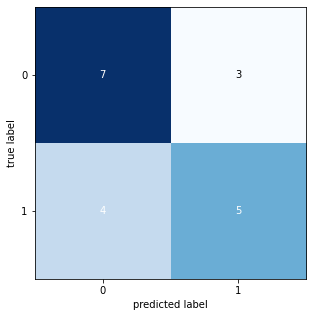

Running Time:  1.5452397000000246
gene : [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



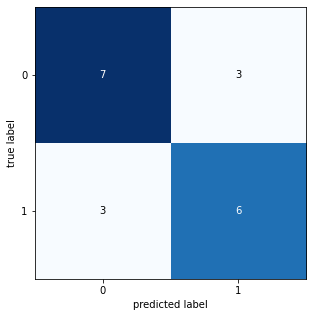

Running Time:  1.545443500000033
gene : [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



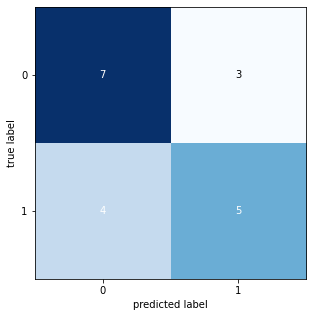

Running Time:  1.5482752000000346
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



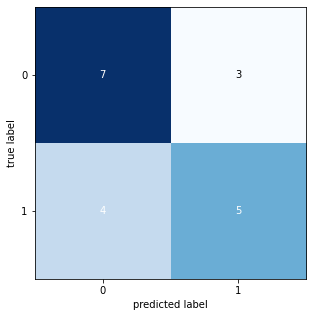

Running Time:  1.5487059000000727
gene : [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



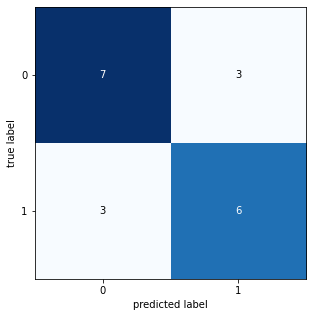

Running Time:  1.5522135999999591
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



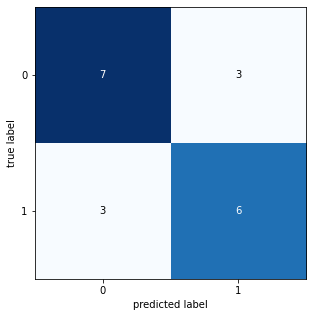

Running Time:  1.7194471000000249
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



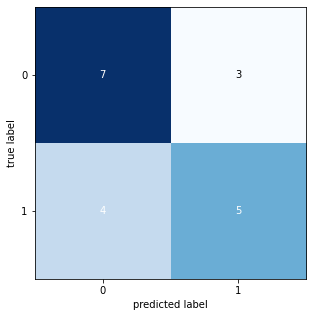

Running Time:  1.5488395999999511
gene : [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



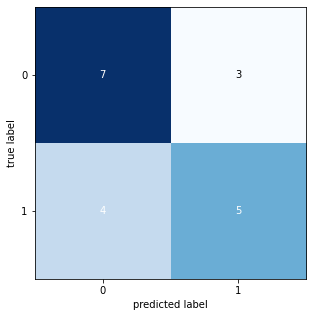

Running Time:  1.553586600000017
gen terbaik : [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 43

Running Time:  79.36641380000003
breast + IG + GA Orde 3
Generation : 0
gene : [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]

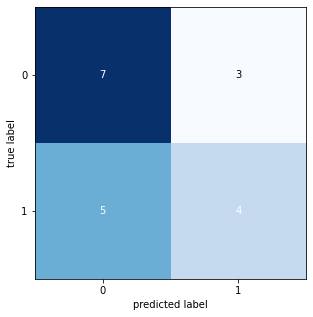

Running Time:  1.5797364999999672
gene : [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



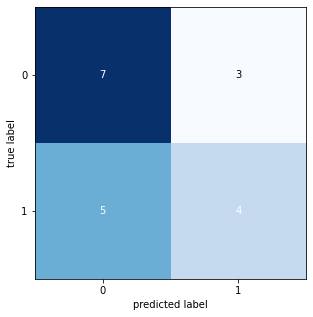

Running Time:  1.5711992999999893
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



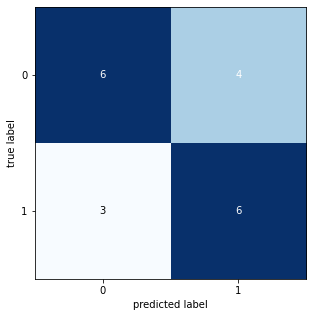

Running Time:  1.5608001000000513
gene : [0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



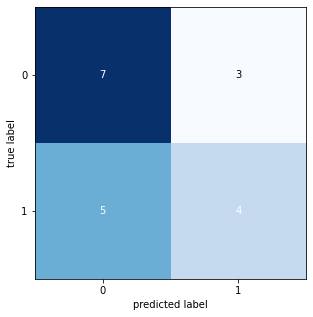

Running Time:  1.5871826999999712
gene : [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5043478260869565
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.50      0.33      0.40         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.50        19
weighted avg       0.52      0.53      0.51        19



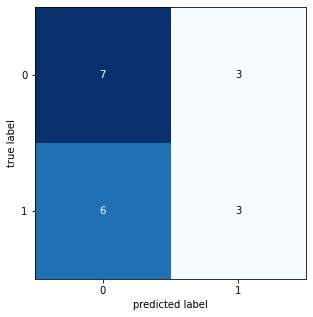

Running Time:  1.694734799999992
gene : [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



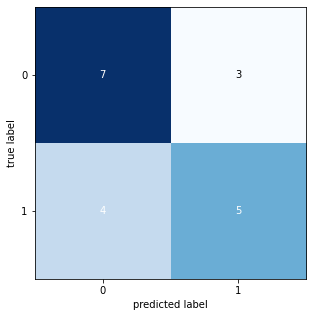

Running Time:  1.559152900000072
gene : [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



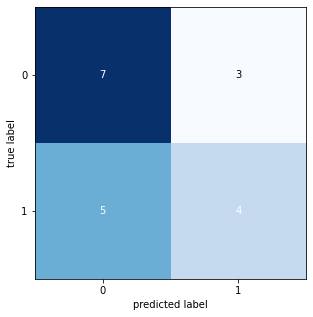

Running Time:  1.56314569999995
gene : [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.4602272727272727
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.43      0.33      0.38         9

    accuracy                           0.47        19
   macro avg       0.46      0.47      0.46        19
weighted avg       0.47      0.47      0.46        19



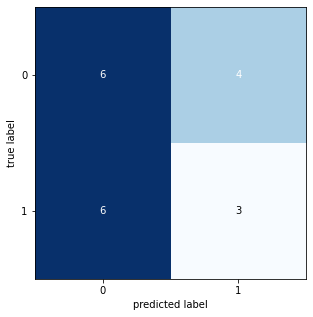

Running Time:  1.5768123000000287
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



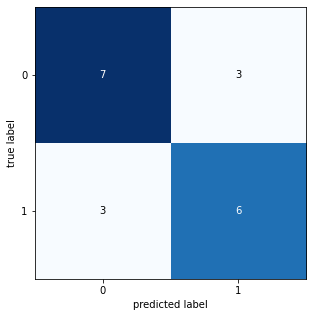

Running Time:  1.5568514999999934
gene : [1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5043478260869565
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.50      0.33      0.40         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.50        19
weighted avg       0.52      0.53      0.51        19



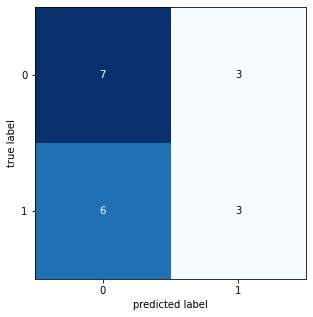

Running Time:  1.5800742999999784
gen terbaik : [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 48

Generation : 1
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akuras

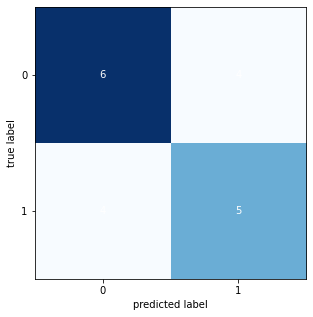

Running Time:  1.5548189000001003
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



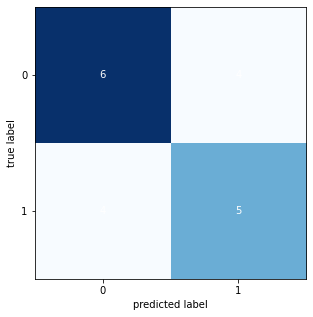

Running Time:  1.5677299000000176
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



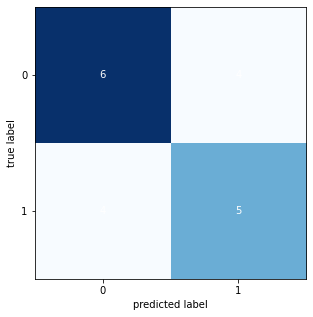

Running Time:  1.719794400000069
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



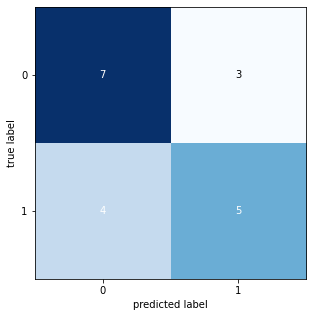

Running Time:  1.5627981999999747
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



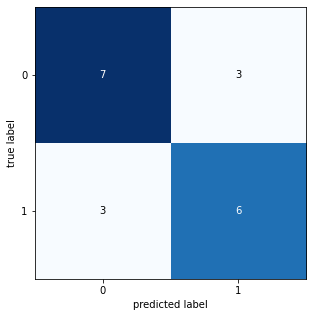

Running Time:  1.5541655000000674
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



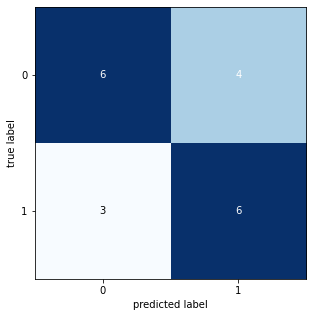

Running Time:  1.557982700000025
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613445
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.50      0.44      0.47         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



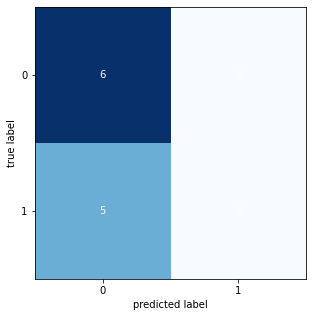

Running Time:  1.5539628999999877
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



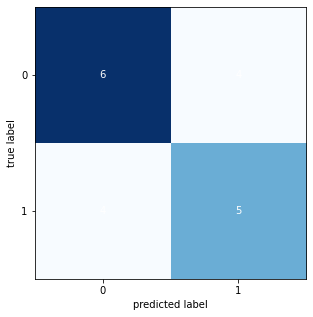

Running Time:  1.5617738999999347
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



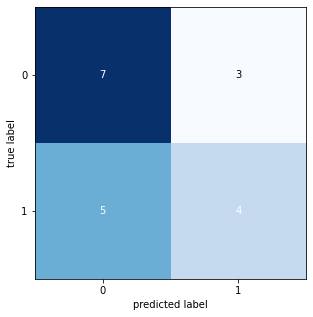

Running Time:  1.5708844000000681
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



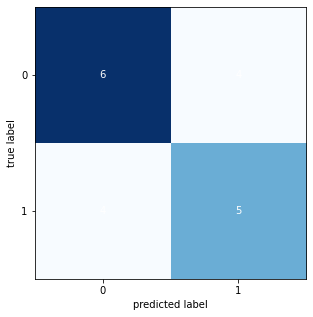

Running Time:  1.5609130999999934
gen terbaik : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 47

Generation : 2
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akuras

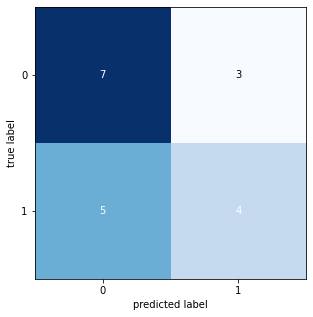

Running Time:  1.7290707999999313
gene : [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613445
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.50      0.44      0.47         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



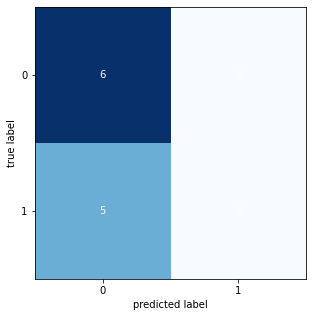

Running Time:  1.5598104000000603
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



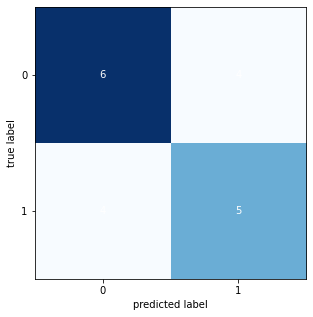

Running Time:  1.5726133000000573
gene : [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



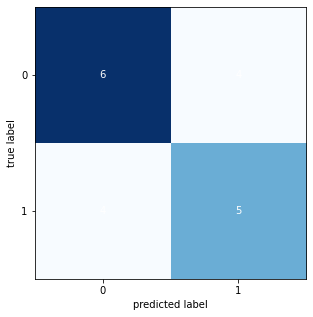

Running Time:  1.5669361999999865
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



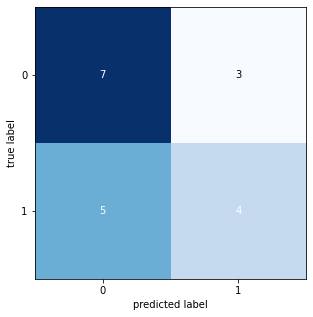

Running Time:  1.56839930000001
gene : [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



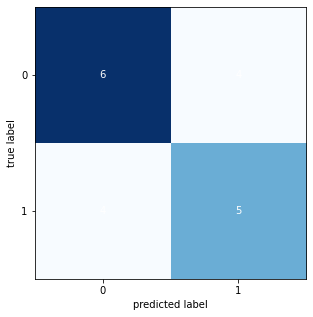

Running Time:  1.569168999999988
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



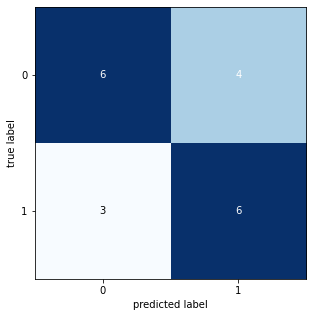

Running Time:  1.5607003999999733
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



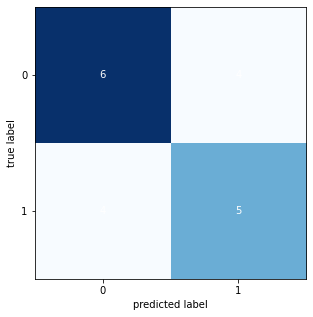

Running Time:  1.5575839999999062
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



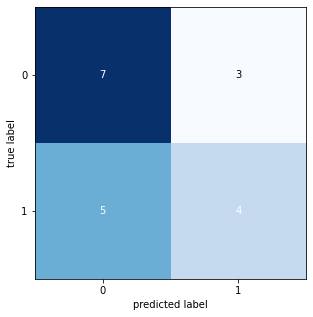

Running Time:  1.7380803000000924
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



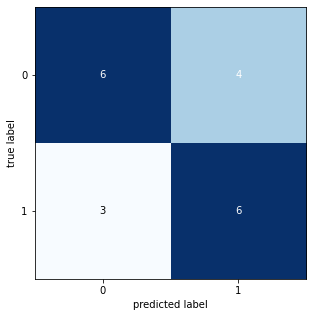

Running Time:  1.5626051999998936
gen terbaik : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 47

Generation : 3
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akuras

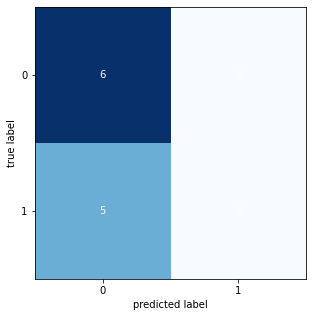

Running Time:  1.56577070000003
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



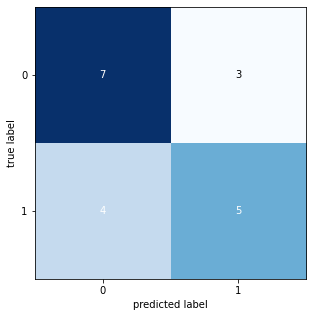

Running Time:  1.5665346000000682
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



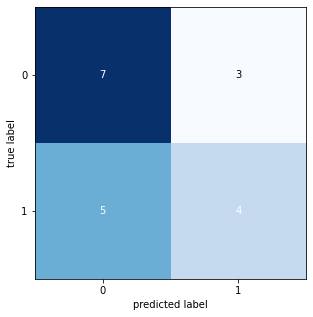

Running Time:  1.555022699999995
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



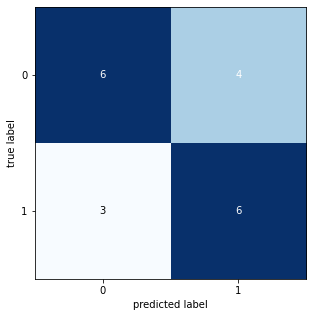

Running Time:  1.568008500000019
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



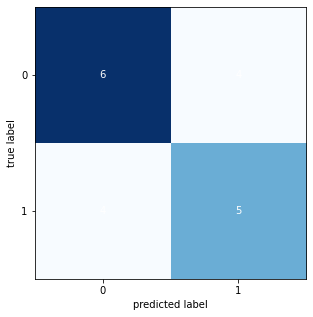

Running Time:  1.5677322000000231
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



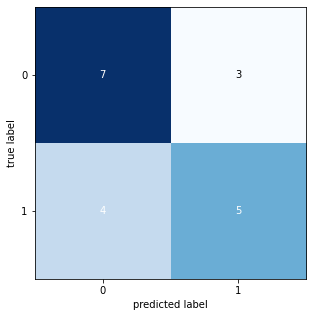

Running Time:  1.565727200000083
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



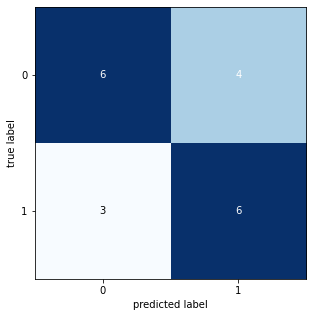

Running Time:  1.7354943000000276
gene : [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



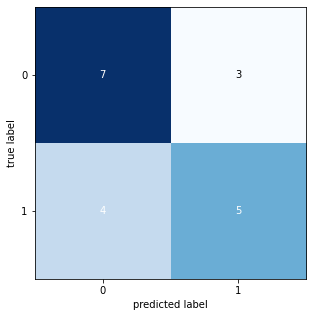

Running Time:  1.5592425999999477
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



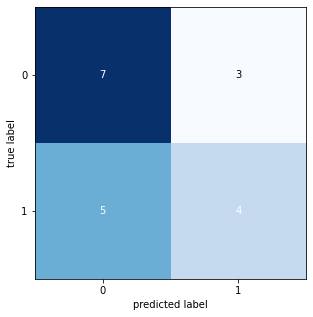

Running Time:  1.559648100000004
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



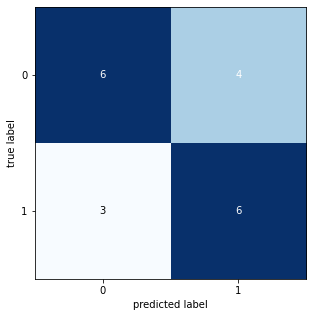

Running Time:  1.5639322000000675
gen terbaik : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 47

Generation : 4
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akuras

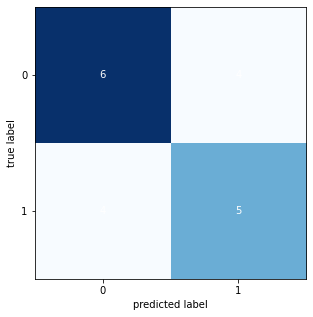

Running Time:  1.5696490000000267
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



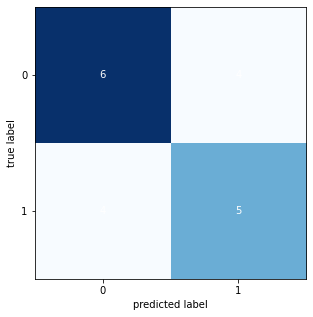

Running Time:  1.5608877999999322
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613445
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.50      0.44      0.47         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



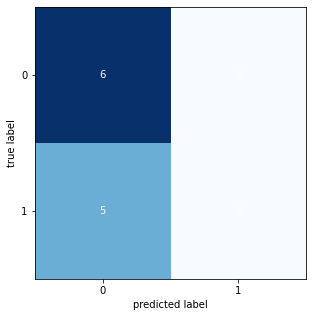

Running Time:  1.569125700000086
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



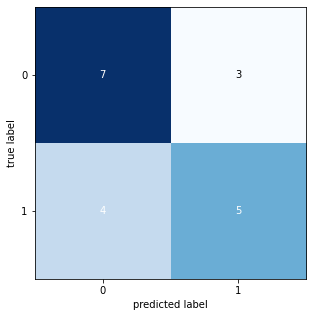

Running Time:  1.5601219999999785
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



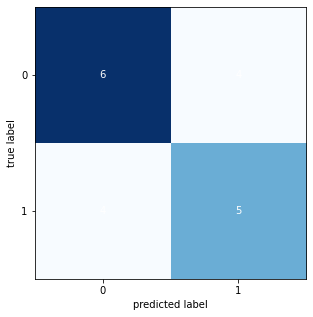

Running Time:  1.7449960000000146
gene : [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613445
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.50      0.44      0.47         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



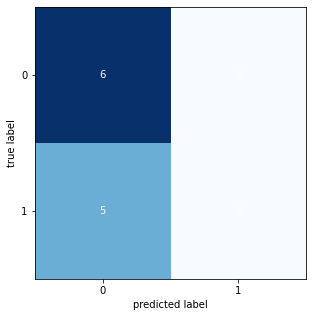

Running Time:  1.5569050999999945
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



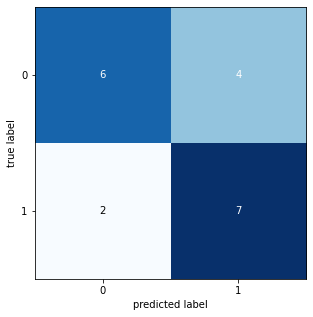

Running Time:  1.5644916999999623
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



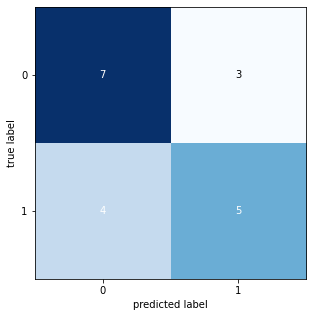

Running Time:  1.583914699999923
gene : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



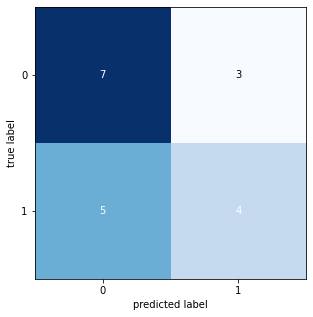

Running Time:  1.5765011999999388
gene : [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



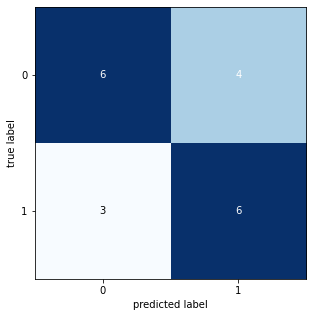

Running Time:  1.5686201000000892
gen terbaik : [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 49

Running Time:  80.16787160000001
breast + IG + GA Orde 4
Generation : 0
gene : [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

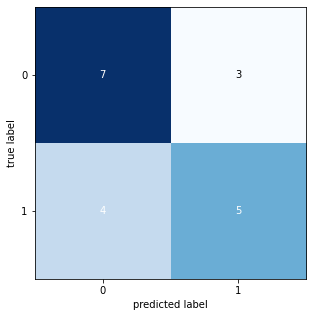

Running Time:  1.584167999999977
gene : [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



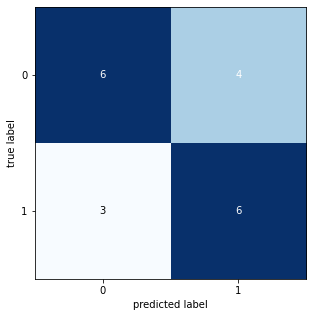

Running Time:  1.5896443999999974
gene : [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5043478260869565
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.50      0.33      0.40         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.50        19
weighted avg       0.52      0.53      0.51        19



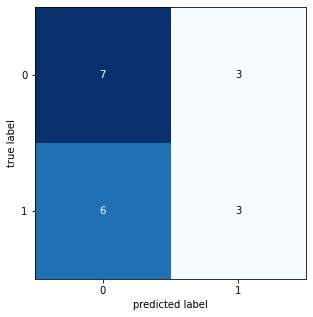

Running Time:  1.7721622000000252
gene : [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.4602272727272727
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.43      0.33      0.38         9

    accuracy                           0.47        19
   macro avg       0.46      0.47      0.46        19
weighted avg       0.47      0.47      0.46        19



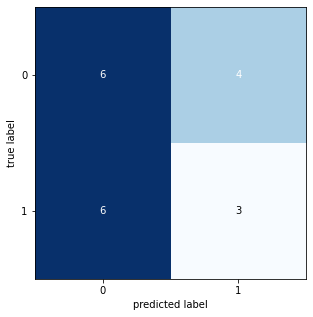

Running Time:  1.5874761000000035
gene : [1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



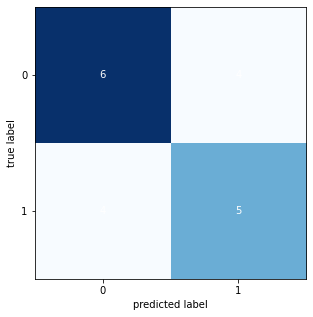

Running Time:  1.5804197000001068
gene : [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



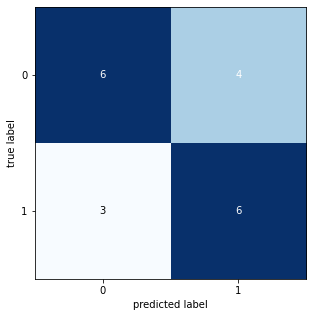

Running Time:  1.5832176999999774
gene : [0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



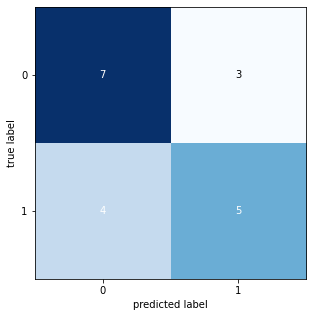

Running Time:  1.587620300000026
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



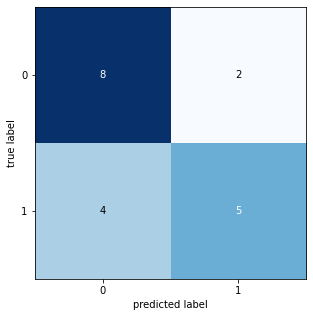

Running Time:  1.567252799999892
gene : [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.67      0.44      0.53         9

    accuracy                           0.63        19
   macro avg       0.64      0.62      0.61        19
weighted avg       0.64      0.63      0.62        19



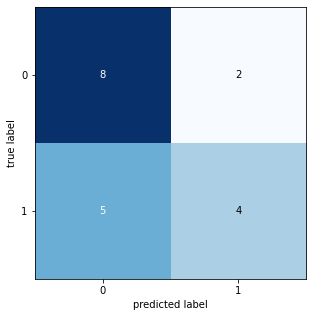

Running Time:  1.5857466999999588
gene : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



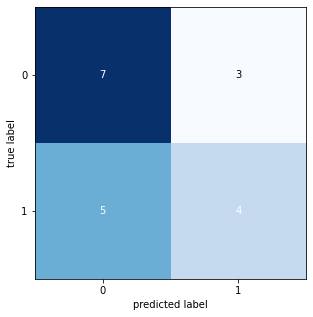

Running Time:  1.7837388000000374
gen terbaik : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.6761363636363636  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 51

Generation : 1
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akuras

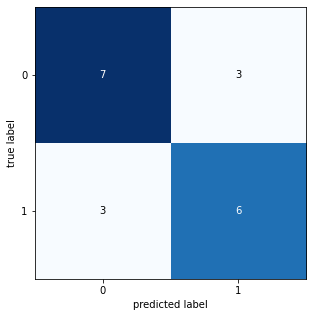

Running Time:  1.5744874000000664
gene : [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



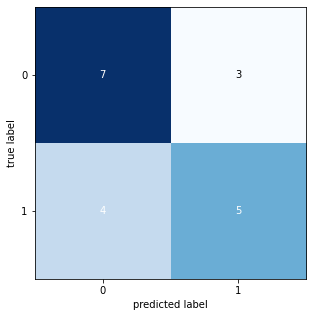

Running Time:  1.58010969999998
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



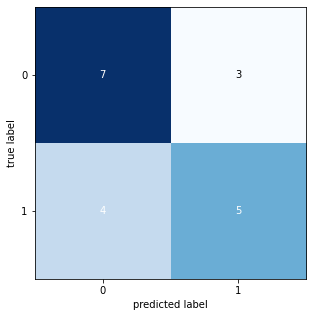

Running Time:  1.5755523999999923
gene : [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



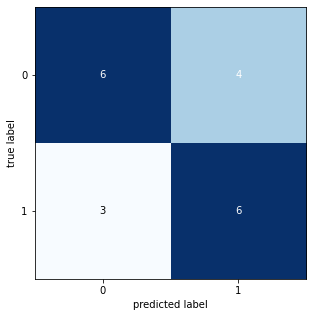

Running Time:  1.5798306000000366
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



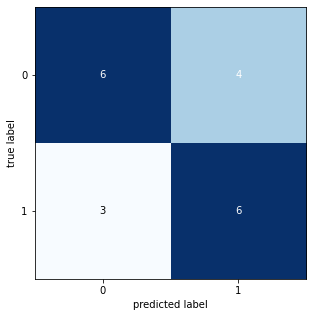

Running Time:  1.6187532999999803
gene : [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613445
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.50      0.44      0.47         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



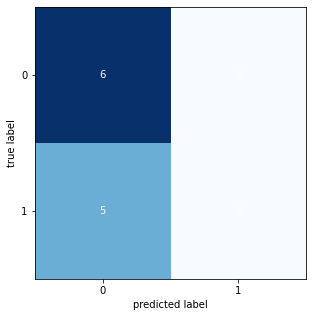

Running Time:  1.5964222000000063
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



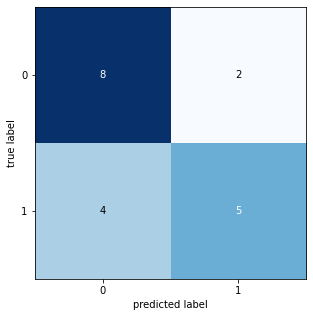

Running Time:  1.5808339999999816
gene : [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



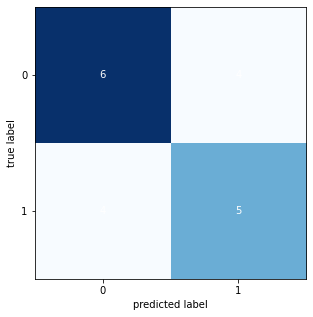

Running Time:  1.774685599999998
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



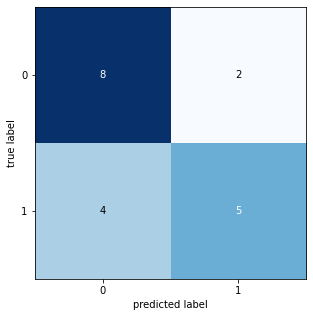

Running Time:  1.5853498000000172
gene : [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



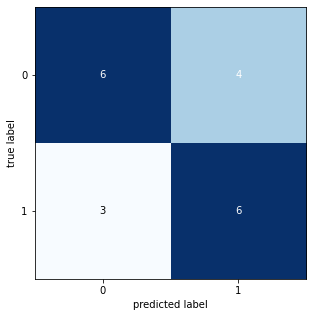

Running Time:  1.5789096000000882
gen terbaik : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 49

Generation : 2
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akuras

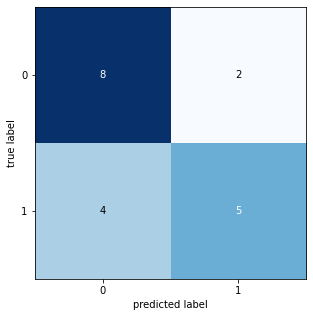

Running Time:  1.5836010000000442
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



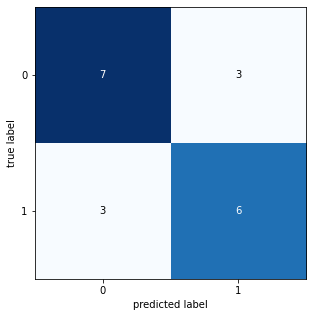

Running Time:  1.598771499999998
gene : [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.62      0.56      0.59         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.63      0.63      0.63        19



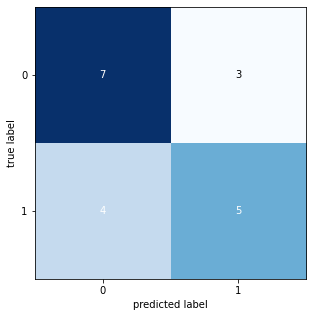

Running Time:  1.5756129999999757
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



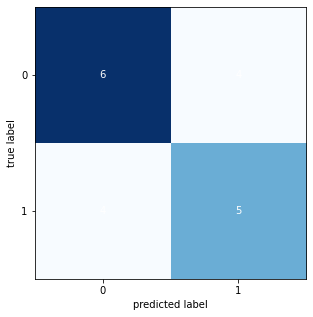

Running Time:  1.6183086999999432
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.67      0.44      0.53         9

    accuracy                           0.63        19
   macro avg       0.64      0.62      0.61        19
weighted avg       0.64      0.63      0.62        19



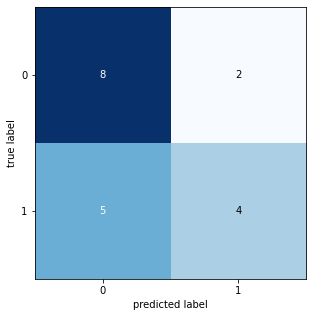

Running Time:  1.5812336000000187
gene : [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



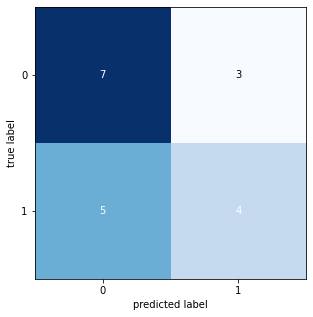

Running Time:  1.7734292999999752
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.67      0.44      0.53         9

    accuracy                           0.63        19
   macro avg       0.64      0.62      0.61        19
weighted avg       0.64      0.63      0.62        19



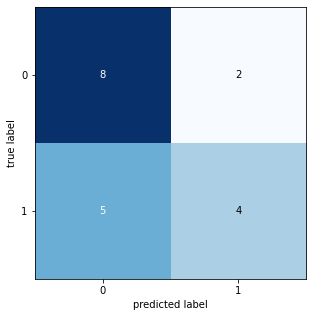

Running Time:  1.5799184999999625
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



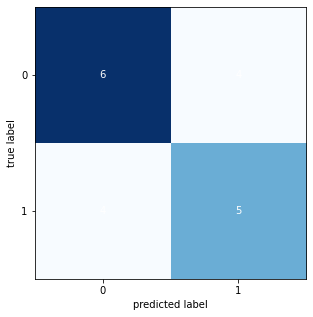

Running Time:  1.586615199999983
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



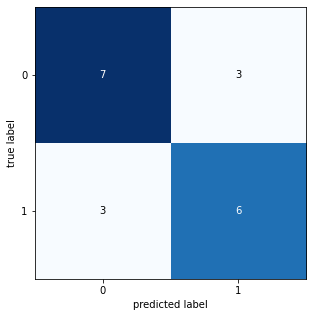

Running Time:  1.5734764999999697
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



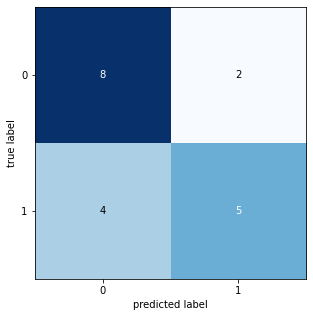

Running Time:  1.587330599999973
gen terbaik : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 49

Generation : 3
gene : [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi

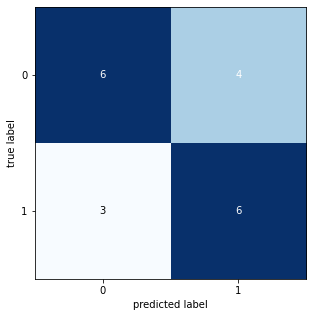

Running Time:  1.5739842999998928
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



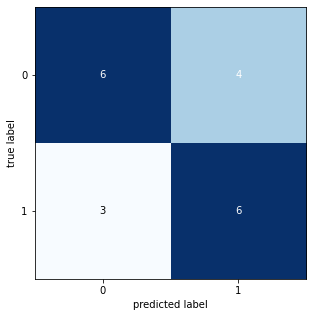

Running Time:  1.5684608000000253
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



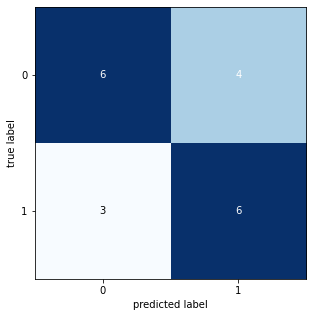

Running Time:  1.5715134000000717
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



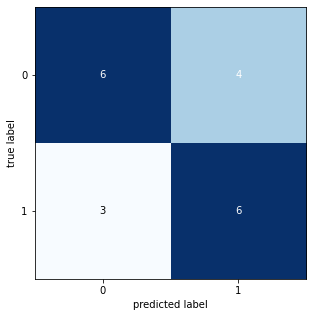

Running Time:  1.7500504999999293
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



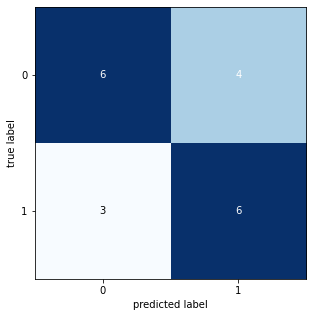

Running Time:  1.563267699999983
gene : [1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



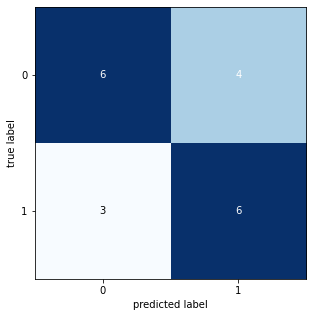

Running Time:  1.5790967000000364
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



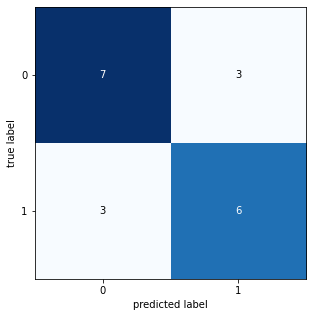

Running Time:  1.5900263999999424
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



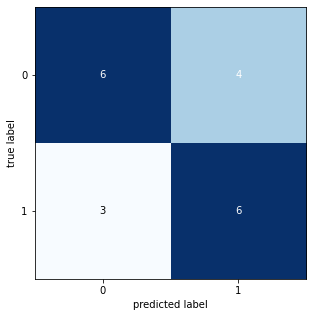

Running Time:  1.5860552000000325
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



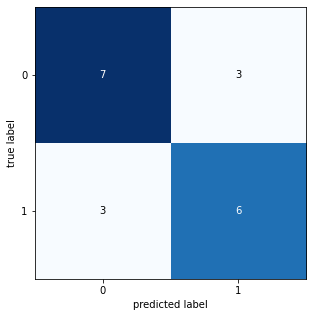

Running Time:  1.563131300000009
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



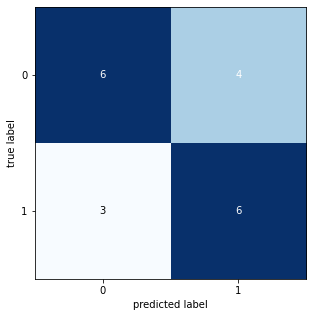

Running Time:  1.5590247999999747
gen terbaik : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 48

Generation : 4
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akuras

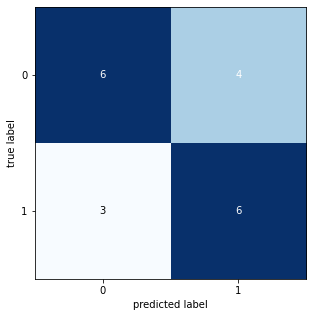

Running Time:  1.5754997999999887
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



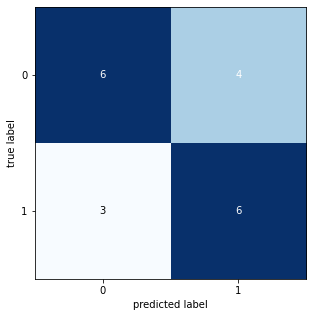

Running Time:  1.7848463000000265
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



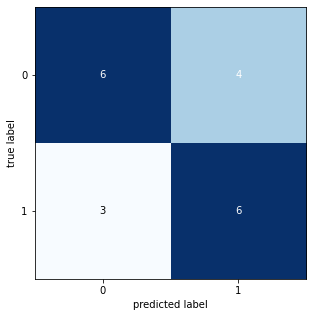

Running Time:  1.5660236999999597
gene : [1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



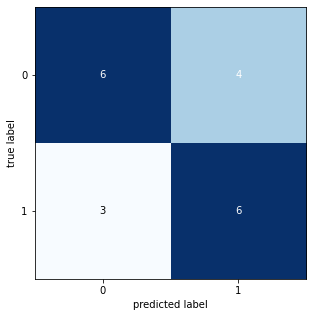

Running Time:  1.5746198000000504
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



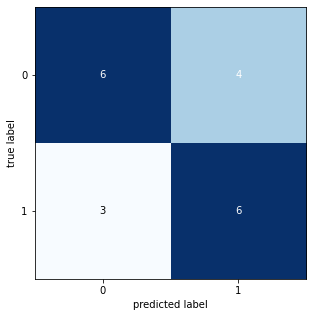

Running Time:  1.5666251000000102
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



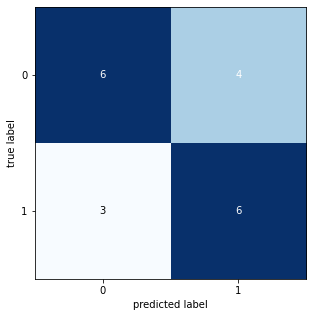

Running Time:  1.576994500000069
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



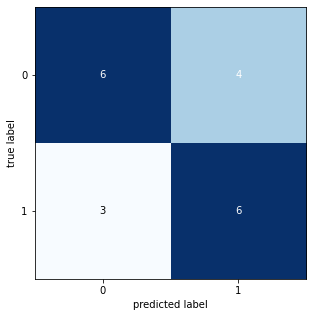

Running Time:  1.5584274000000278
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



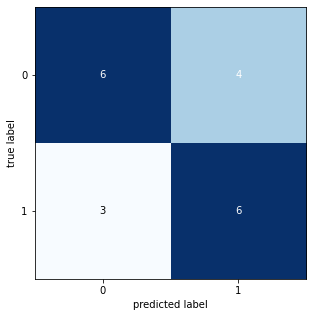

Running Time:  1.5708660999999893
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



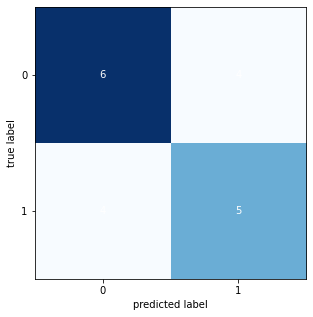

Running Time:  1.569962900000064
gene : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



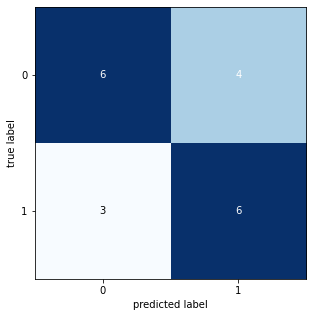

Running Time:  1.769593900000018
gen terbaik : [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
F-1 Score terbaik : 0.6833333333333333  || Akurasi terbaik : 0.6842105263157895  || jumlah fitur : 48

Running Time:  81.28551449999998
Train :  [ 1  2  5  6  7  8  9 10 11 12 13 14 17 18 20 21 22 23 24 25 27 28 29 30
 31 32 33 34 35 36 37 39 40 41 42 43 44 45 47 49 50 52 53 56 57 58 59 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 78 79 82 83 84 85 87 89 90
 91 92 93 94 95 96] Test :  [ 0  3  4 15 16 19 26 38 46 48 51 54 55 60 77 80 81 86 88]
train:  (78, 101)
test:  (19, 101)
Running Time:  23.797797800000012
breast + IG Orde 2
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0

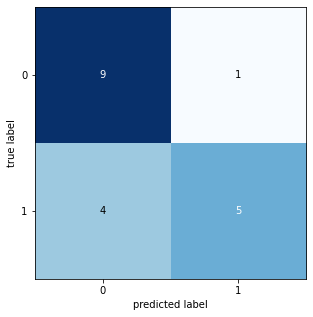

Running Time:  1.5762356999999838
breast + IG Orde 3
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



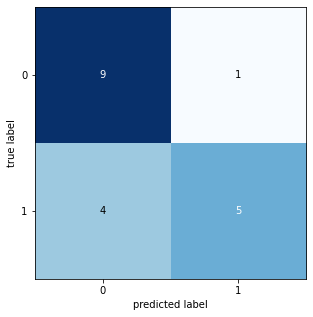

Running Time:  1.6207971000000043
breast + IG Orde 4
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



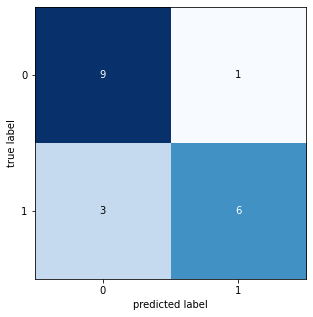

Running Time:  1.6400856000000203
breast + IG + GA Orde 2
Generation : 0
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



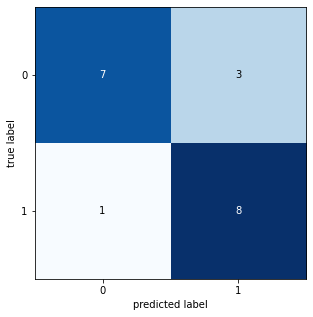

Running Time:  1.5579122999999981
gene : [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613446
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        10
           1       0.50      0.67      0.57         9

    accuracy                           0.53        19
   macro avg       0.54      0.53      0.52        19
weighted avg       0.54      0.53      0.52        19



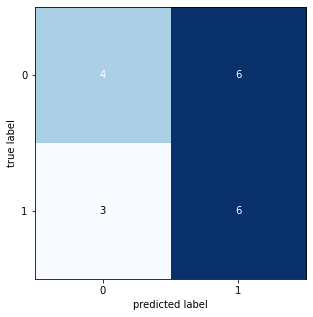

Running Time:  1.5411273999999366
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



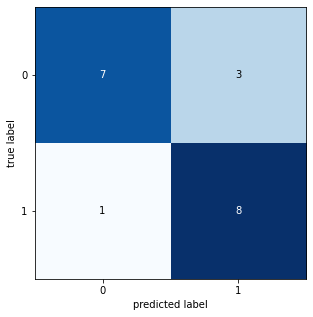

Running Time:  1.5441090000000486
gene : [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



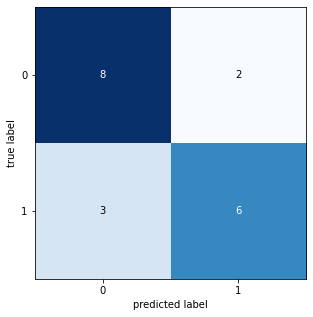

Running Time:  1.7028327000000445
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



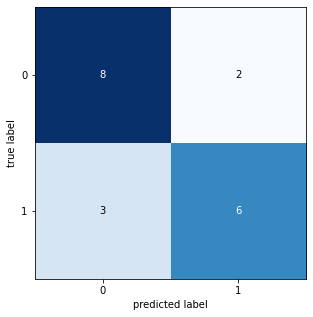

Running Time:  1.5427998999999772
gene : [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



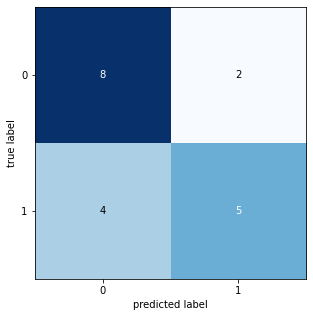

Running Time:  1.5477968000000146
gene : [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



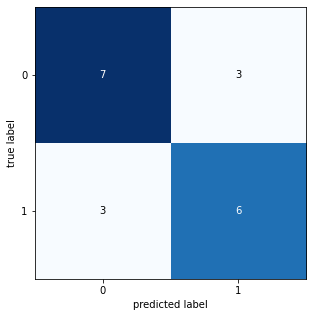

Running Time:  1.5469383999999309
gene : [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



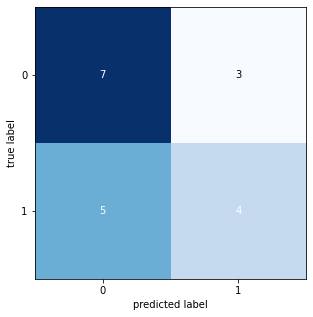

Running Time:  1.5461991999999327
gene : [1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818182
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.57      0.44      0.50         9

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19



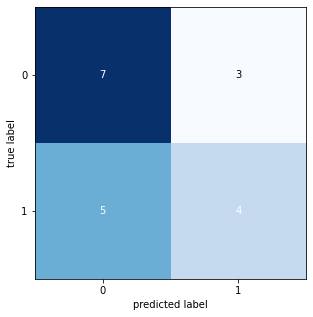

Running Time:  1.5502463000000262
gene : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



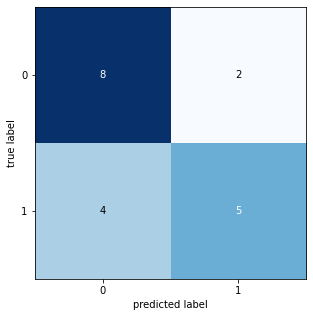

Running Time:  1.548481299999935
gen terbaik : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0]
F-1 Score terbaik : 0.7888888888888888  || Akurasi terbaik : 0.7894736842105263  || jumlah fitur : 54

Generation : 1
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi

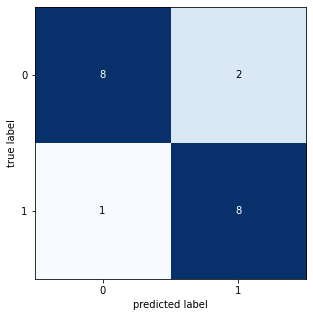

Running Time:  1.723823599999946
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



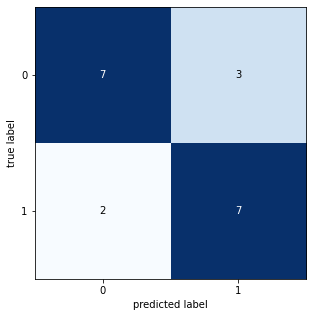

Running Time:  1.543694999999957
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



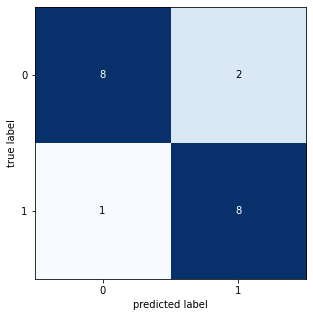

Running Time:  1.5548767999999882
gene : [1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



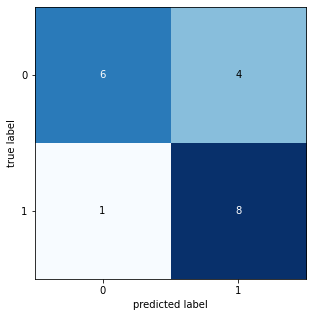

Running Time:  1.5463020000000824
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



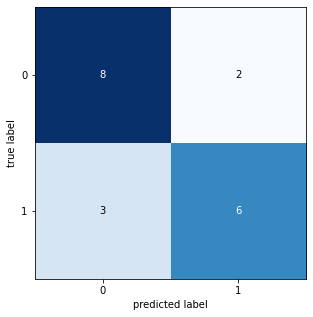

Running Time:  1.5535442999999987
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



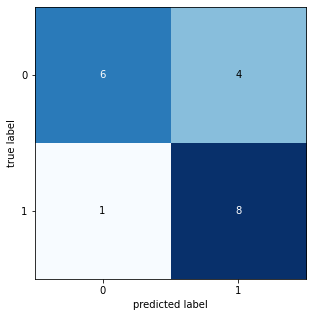

Running Time:  1.5498873999999887
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



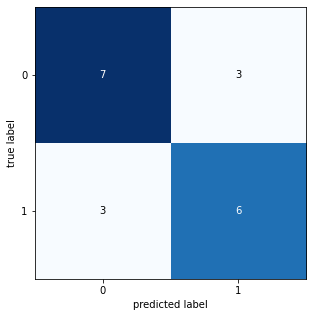

Running Time:  1.5360362000000123
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



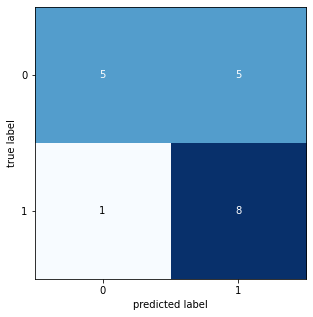

Running Time:  1.5478409999999485
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



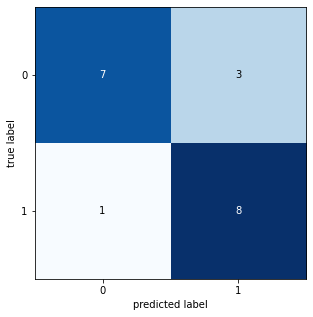

Running Time:  1.7185038000000077
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



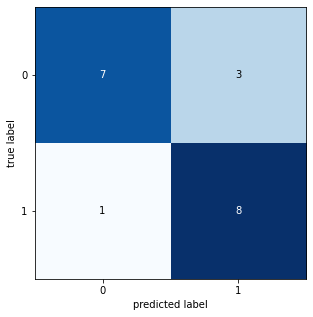

Running Time:  1.5348301999999876
gen terbaik : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
F-1 Score terbaik : 0.8421052631578948  || Akurasi terbaik : 0.8421052631578947  || jumlah fitur : 55

Generation : 2
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akuras

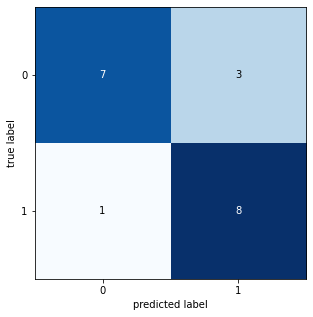

Running Time:  1.5362837000000127
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



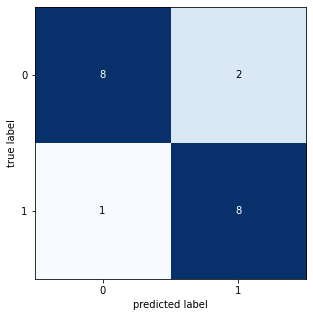

Running Time:  1.5491313999999647
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



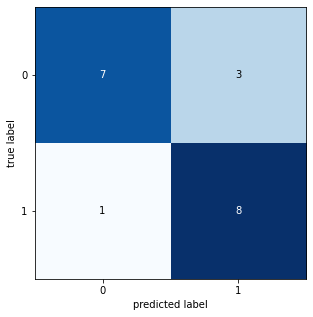

Running Time:  1.5402091999999357
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



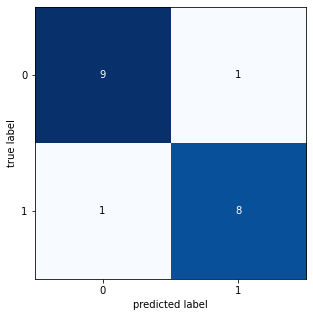

Running Time:  1.5487629000000425
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



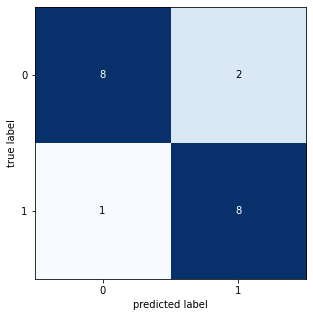

Running Time:  1.5422276000000466
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



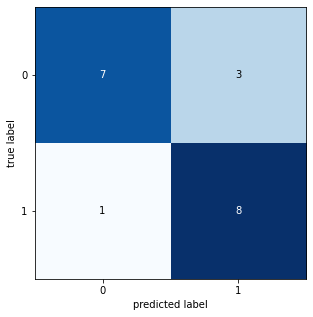

Running Time:  1.5382065000000011
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



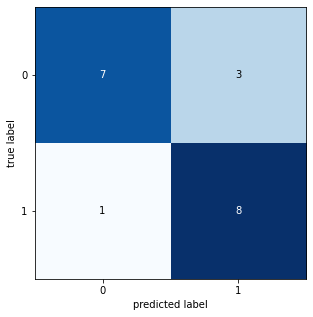

Running Time:  1.723883600000022
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



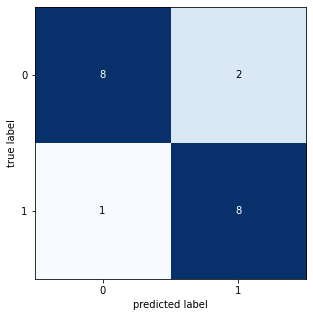

Running Time:  1.5396898999999848
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



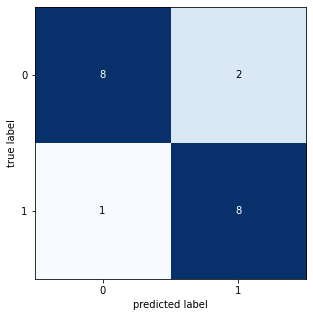

Running Time:  1.5360531000000037
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



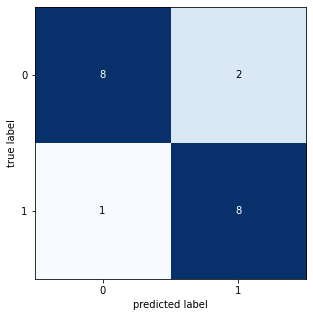

Running Time:  1.5363135000000057
gen terbaik : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
F-1 Score terbaik : 0.8944444444444444  || Akurasi terbaik : 0.8947368421052632  || jumlah fitur : 57

Generation : 3
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akuras

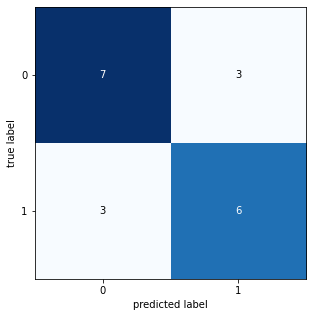

Running Time:  1.5633033000000296
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



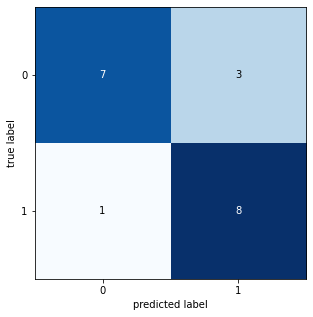

Running Time:  1.541505999999913
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



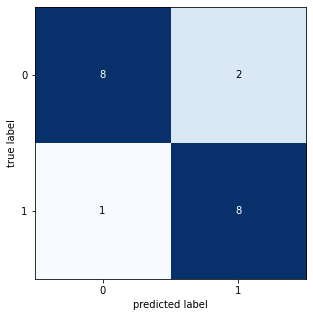

Running Time:  1.5450200000000223
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



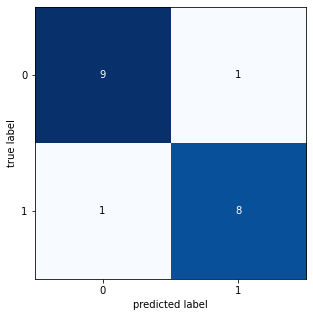

Running Time:  1.5496977000000243
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



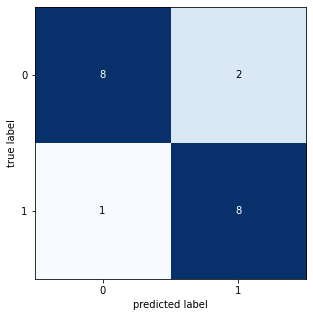

Running Time:  1.7349325999999792
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



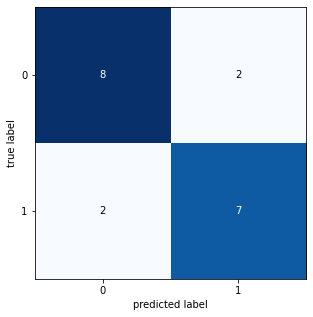

Running Time:  1.5479878999999528
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



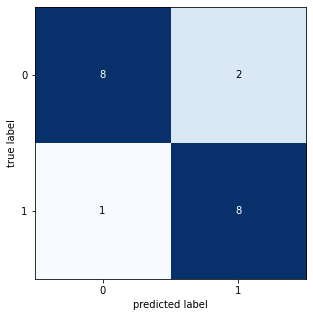

Running Time:  1.5423582000000806
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



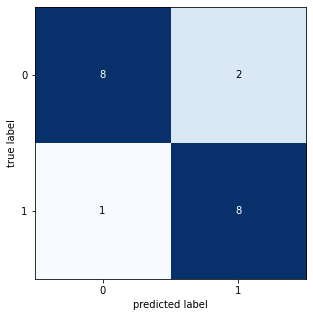

Running Time:  1.5498355999999376
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



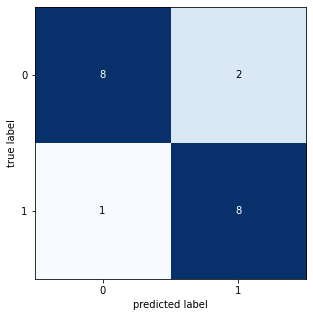

Running Time:  1.537563299999988
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



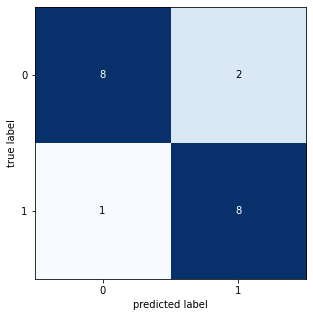

Running Time:  1.537945200000081
gen terbaik : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]
F-1 Score terbaik : 0.8944444444444444  || Akurasi terbaik : 0.8947368421052632  || jumlah fitur : 55

Generation : 4
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi

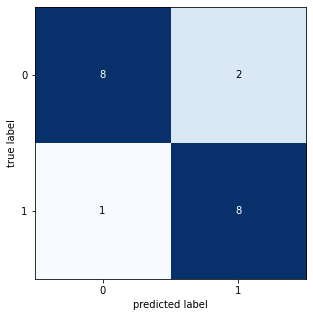

Running Time:  1.5477710000000116
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



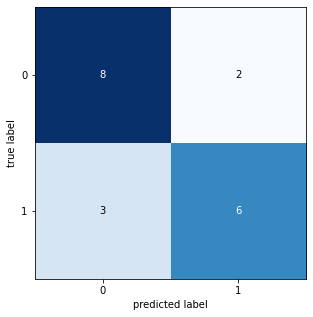

Running Time:  1.5424249999999802
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



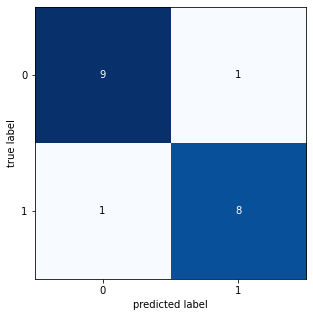

Running Time:  1.7120782999999165
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537816
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.88      0.78      0.82         9

    accuracy                           0.84        19
   macro avg       0.85      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



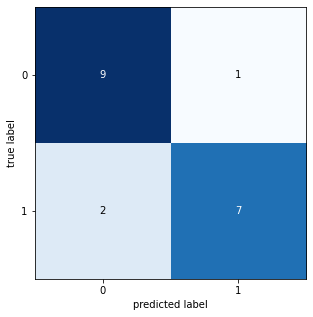

Running Time:  1.5419690999999602
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



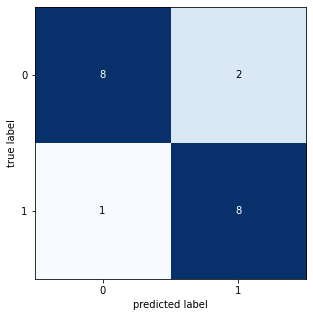

Running Time:  1.5481528000000253
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



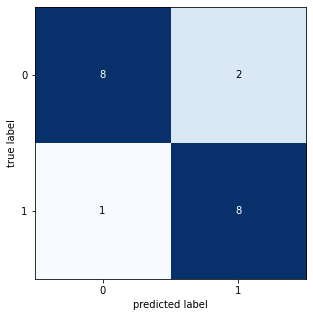

Running Time:  1.5441032999999607
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



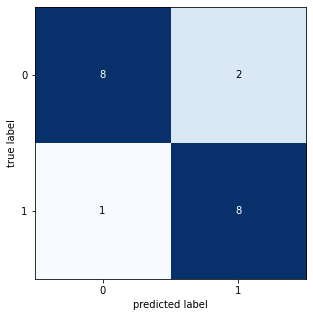

Running Time:  1.5857195000000956
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



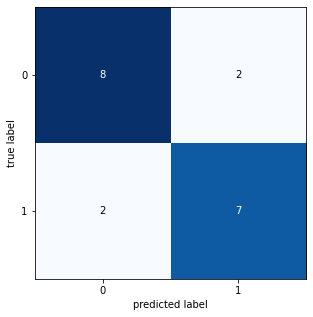

Running Time:  1.5422014000000672
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



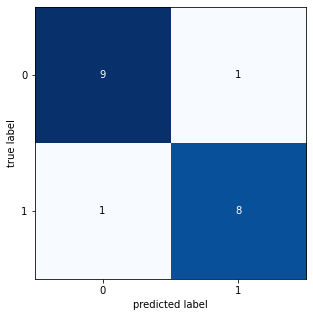

Running Time:  1.5522343999999748
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



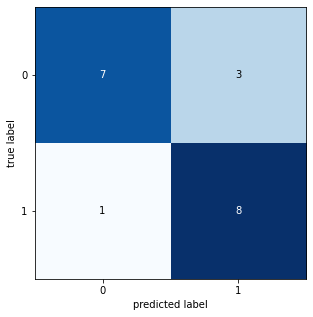

Running Time:  1.5320451000000048
gen terbaik : [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]
F-1 Score terbaik : 0.8944444444444444  || Akurasi terbaik : 0.8947368421052632  || jumlah fitur : 55

Running Time:  79.35089289999996
breast + IG + GA Orde 3
Generation : 0
gene : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

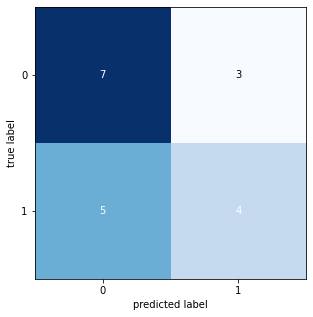

Running Time:  1.735591099999965
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.5907692307692308
              precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.75      0.33      0.46         9

    accuracy                           0.63        19
   macro avg       0.68      0.62      0.59        19
weighted avg       0.67      0.63      0.60        19



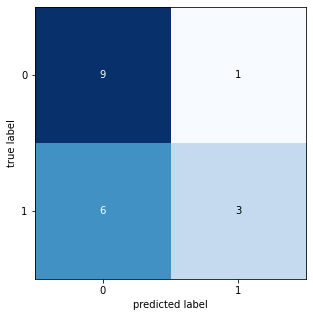

Running Time:  1.5579072000000451
gene : [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



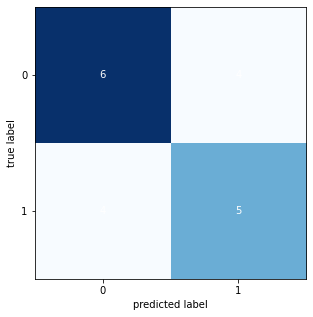

Running Time:  1.5572098999999753
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



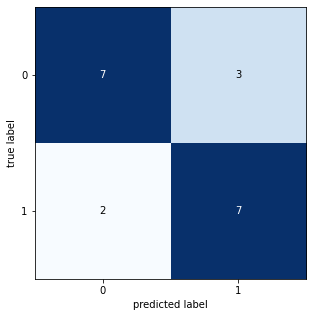

Running Time:  1.560105599999929
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



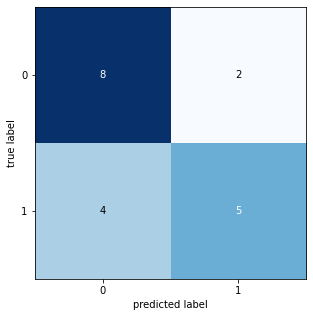

Running Time:  1.5640657000000147
gene : [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



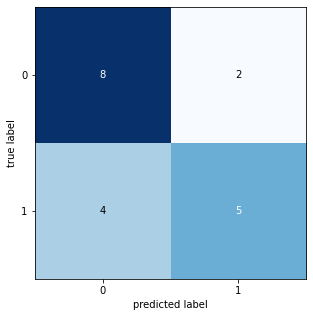

Running Time:  1.57308450000005
gene : [0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



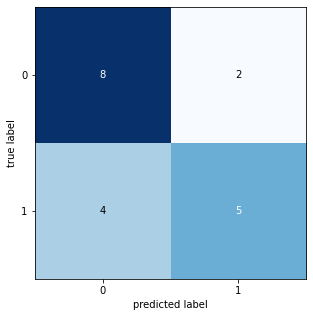

Running Time:  1.5684342000000697
gene : [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613445
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.50      0.44      0.47         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



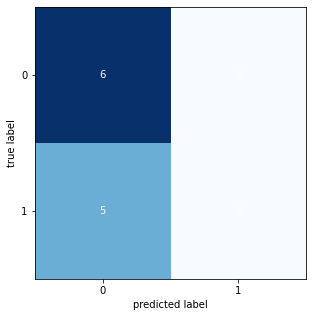

Running Time:  1.7621922999999242
gene : [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



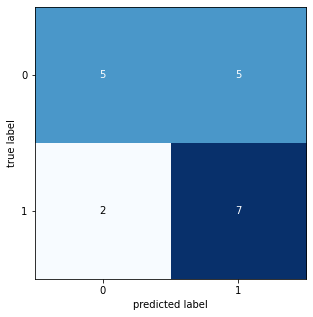

Running Time:  1.5555941999999732
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



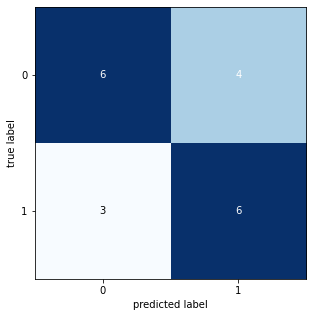

Running Time:  1.5685234000000037
gen terbaik : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.7368421052631577  || Akurasi terbaik : 0.7368421052631579  || jumlah fitur : 42

Generation : 1
gene : [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akuras

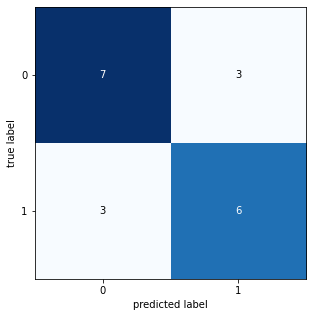

Running Time:  1.5653861999999208
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



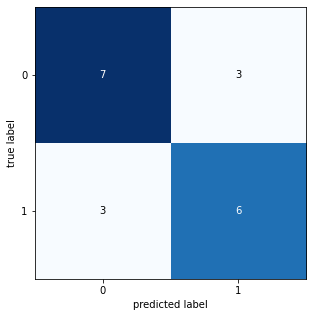

Running Time:  1.5520490999999765
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



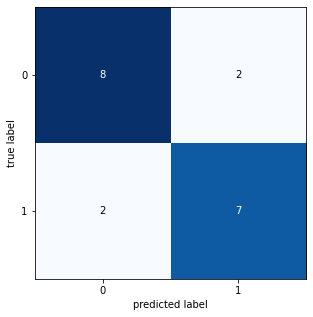

Running Time:  1.5416991999999254
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



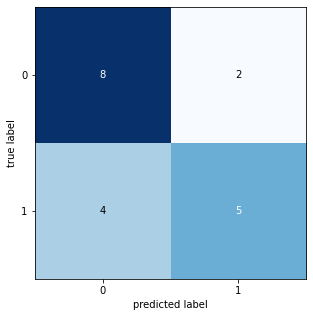

Running Time:  1.56482189999997
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



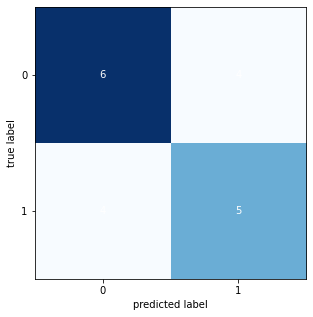

Running Time:  1.554167399999983
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



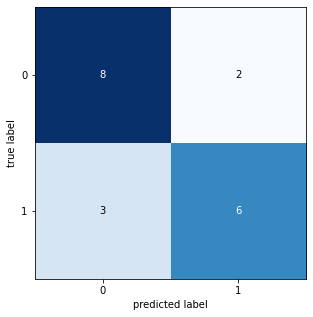

Running Time:  1.7578711999999541
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



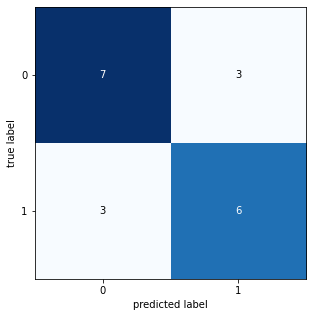

Running Time:  1.5653555999999753
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



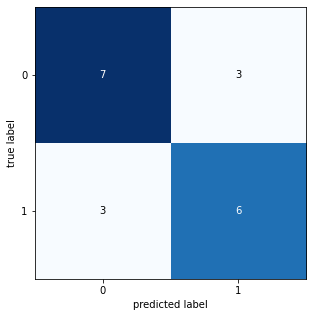

Running Time:  1.5505128999999442
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



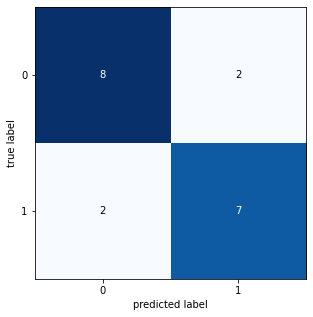

Running Time:  1.5456427000000303
gene : [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



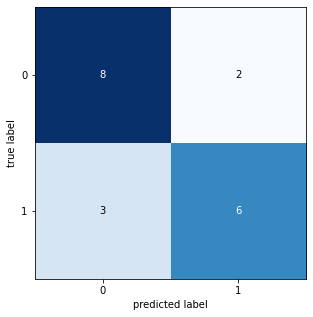

Running Time:  1.5593963999999687
gen terbaik : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.788888888888889  || Akurasi terbaik : 0.7894736842105263  || jumlah fitur : 40

Generation : 2
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi

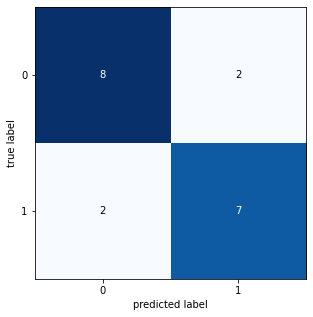

Running Time:  1.5569938999999522
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



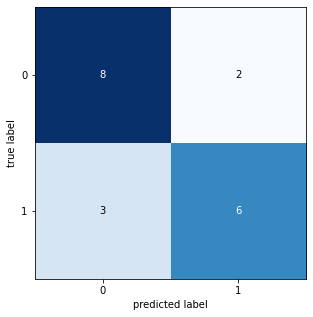

Running Time:  1.5346223000000236
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



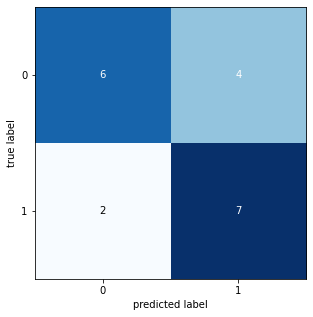

Running Time:  1.5421109000000115
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



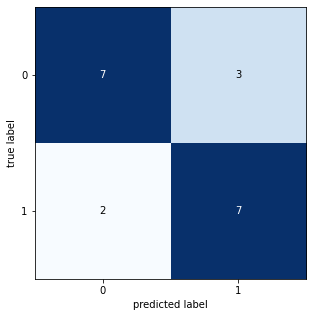

Running Time:  1.7580405999999584
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



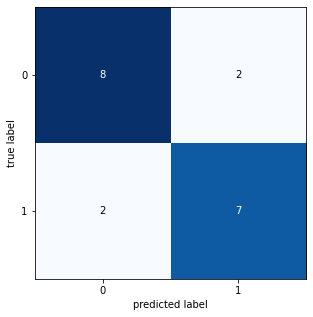

Running Time:  1.5430259999999407
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



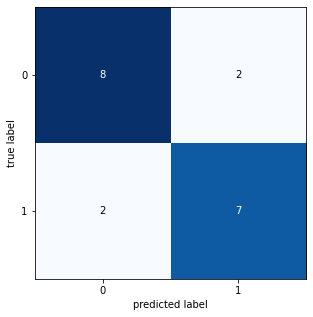

Running Time:  1.536595899999952
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



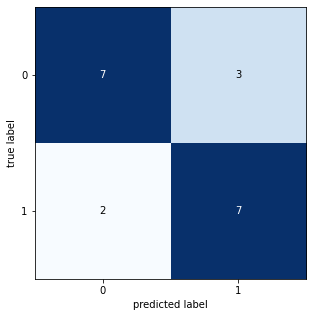

Running Time:  1.549349799999959
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



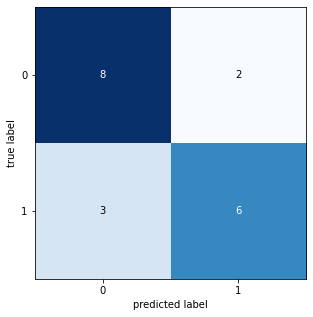

Running Time:  1.5528408000000127
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



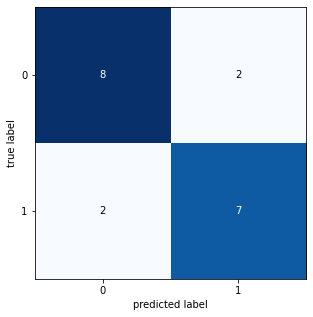

Running Time:  1.5525571999999102
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



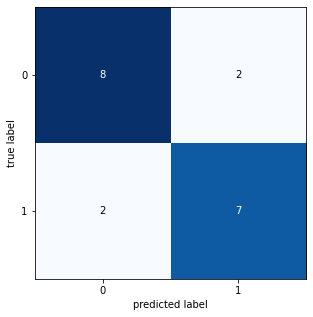

Running Time:  1.5480022000000417
gen terbaik : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.788888888888889  || Akurasi terbaik : 0.7894736842105263  || jumlah fitur : 40

Generation : 3
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi

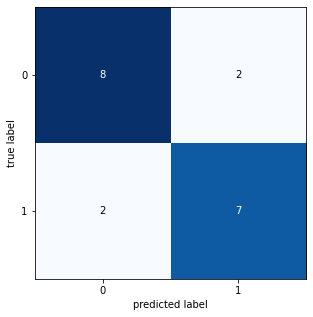

Running Time:  1.5564470000000483
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



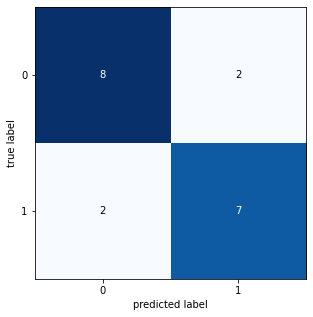

Running Time:  1.709560799999963
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



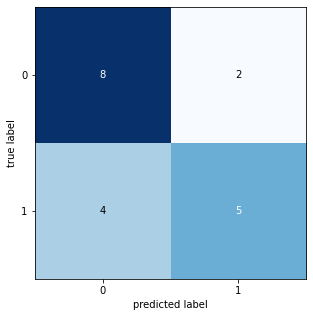

Running Time:  1.5443850999999995
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



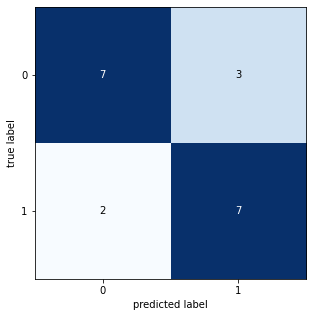

Running Time:  1.5427468999999974
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



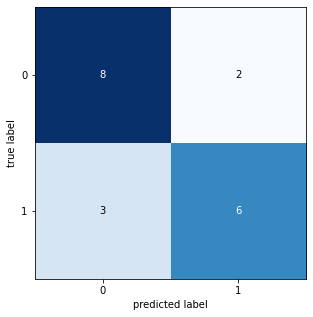

Running Time:  1.5472929000000022
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



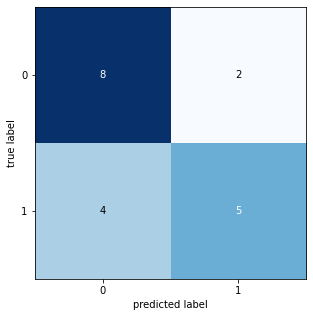

Running Time:  1.5561507999999549
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



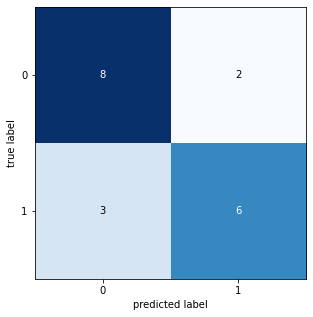

Running Time:  1.5494853999999805
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



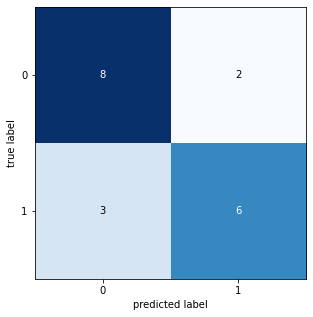

Running Time:  1.5457616999999573
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



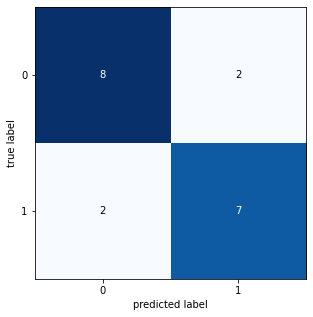

Running Time:  1.5505609000000504
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



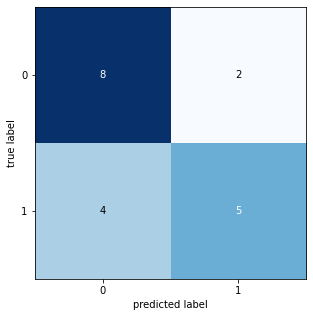

Running Time:  1.7297793000000183
gen terbaik : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
F-1 Score terbaik : 0.788888888888889  || Akurasi terbaik : 0.7894736842105263  || jumlah fitur : 40

Generation : 4
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi

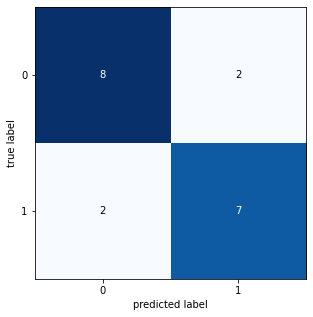

Running Time:  1.5474586999999929
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



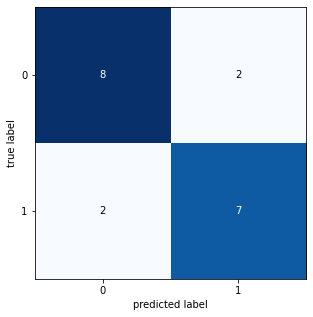

Running Time:  1.5410144999999602
gene : [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



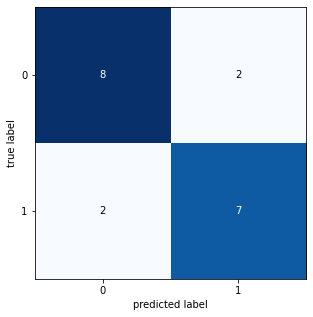

Running Time:  1.541554499999961
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



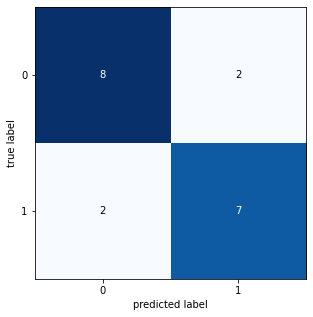

Running Time:  1.5559101999999712
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



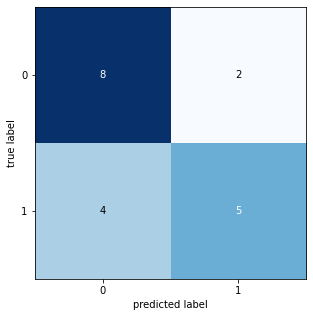

Running Time:  1.5457033000000138
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



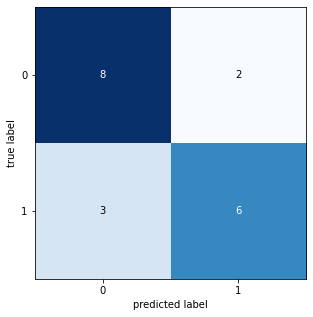

Running Time:  1.56182960000001
gene : [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



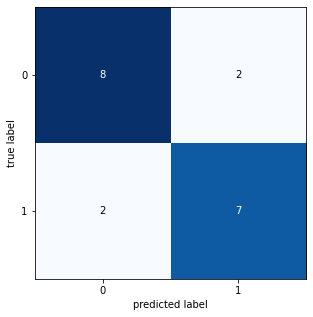

Running Time:  1.5470172999999932
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



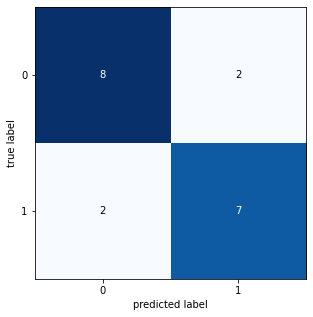

Running Time:  1.7179559999999583
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



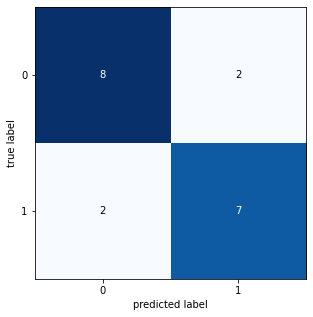

Running Time:  1.5519107999999733
gene : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



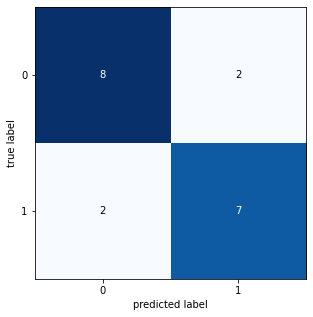

Running Time:  1.552884199999994
gen terbaik : [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]
F-1 Score terbaik : 0.788888888888889  || Akurasi terbaik : 0.7894736842105263  || jumlah fitur : 41

Running Time:  79.78126299999997
breast + IG + GA Orde 4
Generation : 0
gene : [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


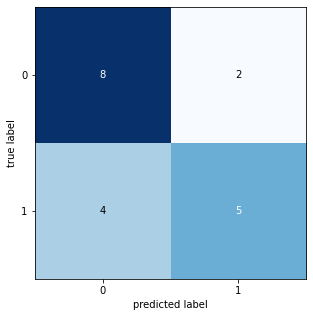

Running Time:  1.561274899999944
gene : [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



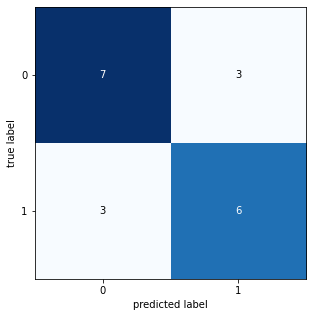

Running Time:  1.5610762999999679
gene : [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



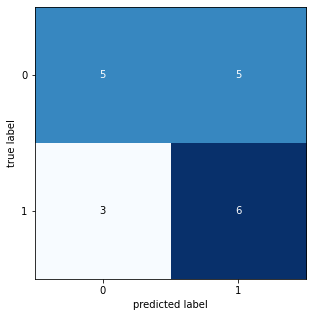

Running Time:  1.5942962999999963
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



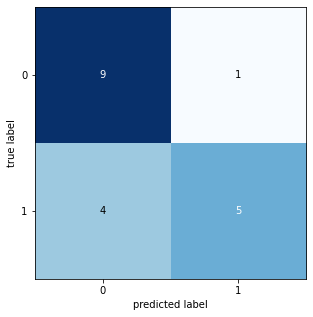

Running Time:  1.5716822000000548
gene : [0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



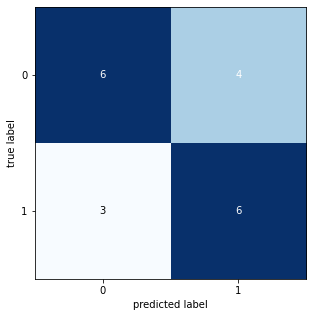

Running Time:  1.7311326000000236
gene : [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



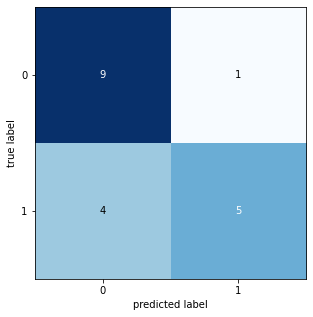

Running Time:  1.5832861000000094
gene : [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



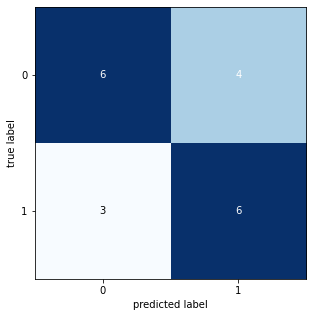

Running Time:  1.5635416000000077
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



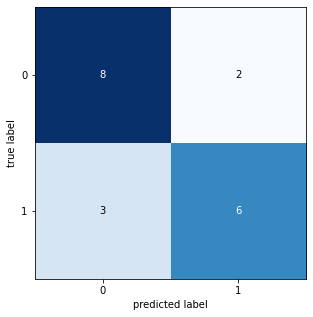

Running Time:  1.5621098999999958
gene : [1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.42105263157894735
F1_Score :  0.35692307692307695
              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.44      0.78      0.56         9

    accuracy                           0.42        19
   macro avg       0.39      0.44      0.36        19
weighted avg       0.38      0.42      0.35        19



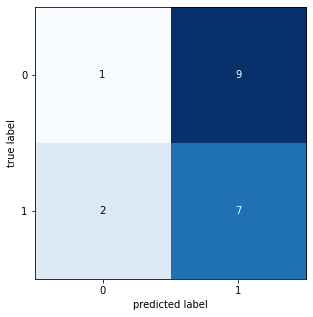

Running Time:  1.5798172999999451
gene : [1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



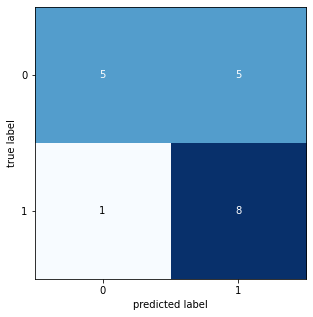

Running Time:  1.5749090000000479
gen terbaik : [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
F-1 Score terbaik : 0.7338935574229692  || Akurasi terbaik : 0.7368421052631579  || jumlah fitur : 49

Generation : 1
gene : [0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akuras

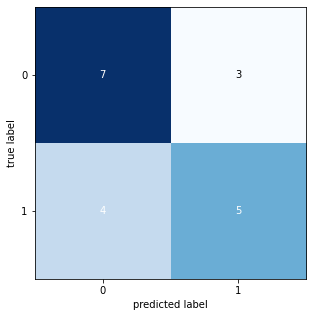

Running Time:  1.5609130999999934
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



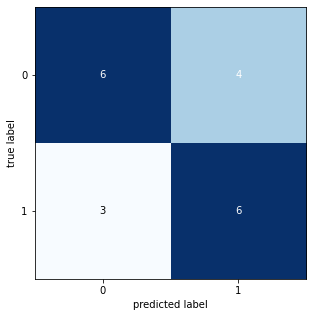

Running Time:  1.5817453999999316
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5476190476190476
              precision    recall  f1-score   support

           0       0.57      0.80      0.67        10
           1       0.60      0.33      0.43         9

    accuracy                           0.58        19
   macro avg       0.59      0.57      0.55        19
weighted avg       0.58      0.58      0.55        19



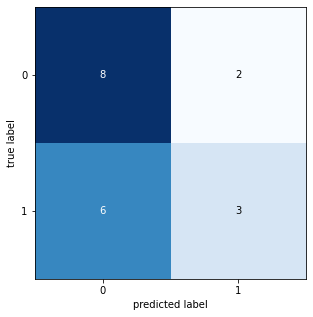

Running Time:  1.7453252999999904
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



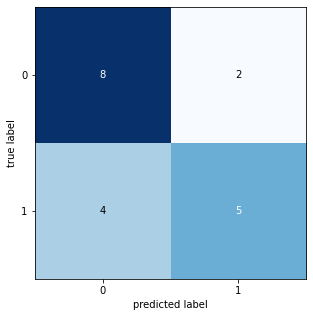

Running Time:  1.5790620000000217
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7076923076923076
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.44      0.62         9

    accuracy                           0.74        19
   macro avg       0.83      0.72      0.71        19
weighted avg       0.82      0.74      0.71        19



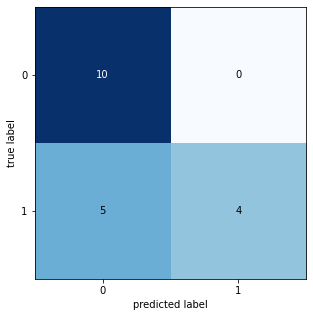

Running Time:  1.5853457999999137
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



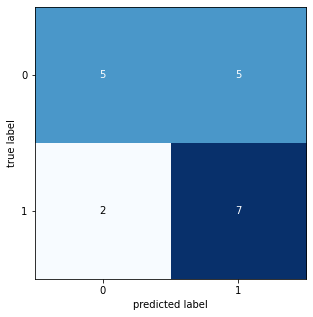

Running Time:  1.5796221000000514
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



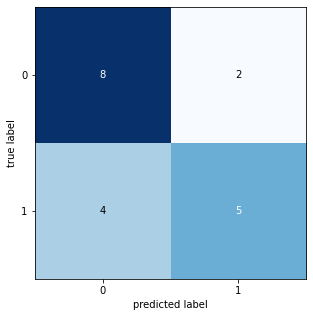

Running Time:  1.5705384000000322
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



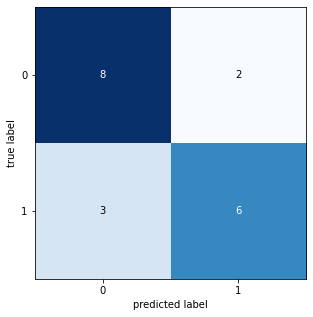

Running Time:  1.5753609999999298
gene : [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



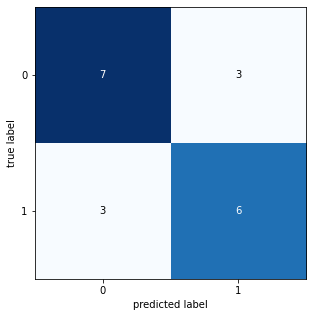

Running Time:  1.561709399999927
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



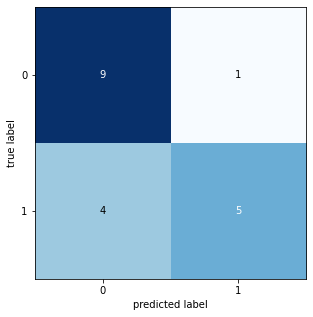

Running Time:  1.5732789999999568
gen terbaik : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
F-1 Score terbaik : 0.7338935574229692  || Akurasi terbaik : 0.7368421052631579  || jumlah fitur : 55

Generation : 2
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akuras

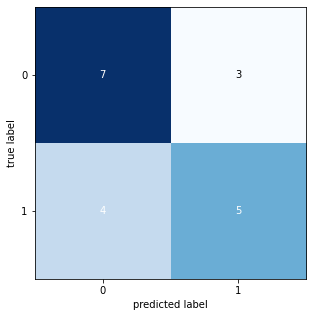

Running Time:  1.8149407000000792
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



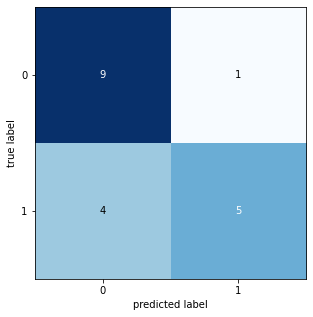

Running Time:  1.5766698999999562
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.80      0.44      0.57         9

    accuracy                           0.68        19
   macro avg       0.72      0.67      0.66        19
weighted avg       0.72      0.68      0.67        19



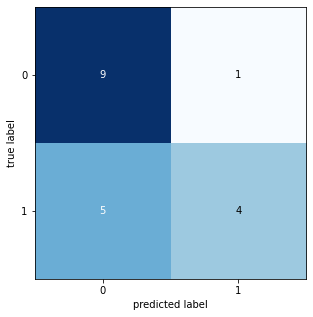

Running Time:  1.5758062999999538
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



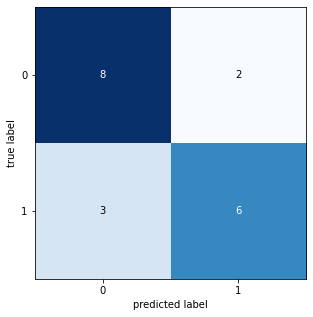

Running Time:  1.582860299999993
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



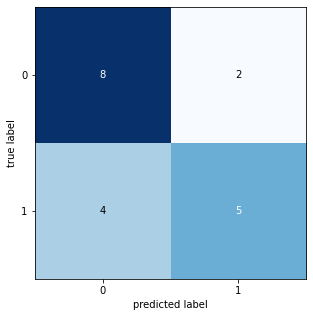

Running Time:  1.5806648000000223
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



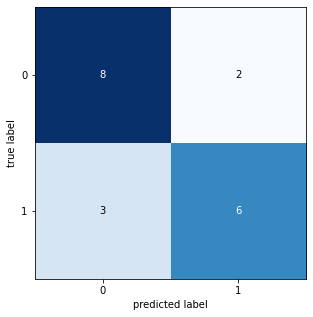

Running Time:  1.5766396000000213
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



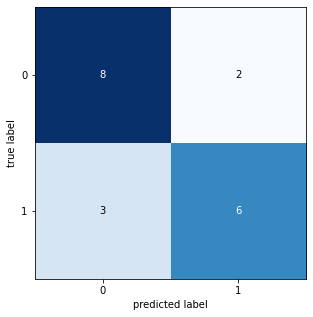

Running Time:  1.596073199999978
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



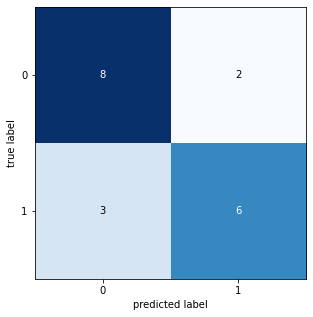

Running Time:  1.571735100000069
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



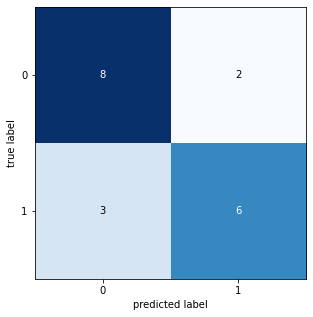

Running Time:  1.767978200000016
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.80      0.44      0.57         9

    accuracy                           0.68        19
   macro avg       0.72      0.67      0.66        19
weighted avg       0.72      0.68      0.67        19



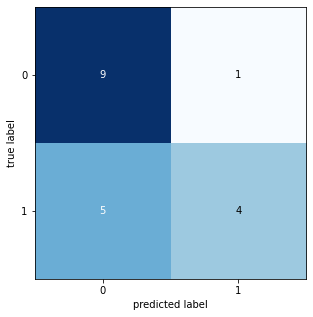

Running Time:  1.5772028999999748
gen terbaik : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
F-1 Score terbaik : 0.7338935574229692  || Akurasi terbaik : 0.7368421052631579  || jumlah fitur : 55

Generation : 3
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akuras

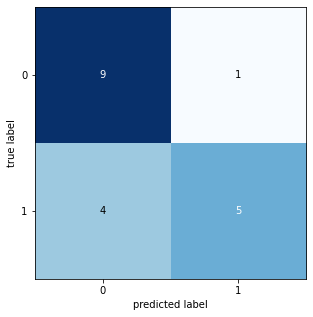

Running Time:  1.5708647999998675
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5476190476190477
              precision    recall  f1-score   support

           0       0.75      0.30      0.43        10
           1       0.53      0.89      0.67         9

    accuracy                           0.58        19
   macro avg       0.64      0.59      0.55        19
weighted avg       0.65      0.58      0.54        19



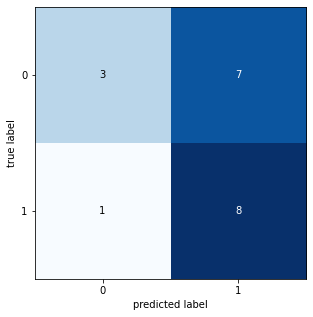

Running Time:  1.5805341000000226
gene : [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



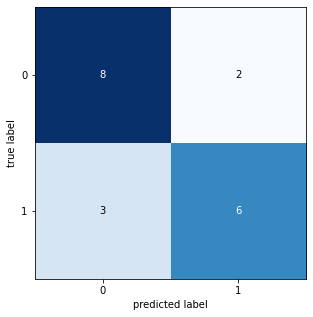

Running Time:  1.5787116999999853
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



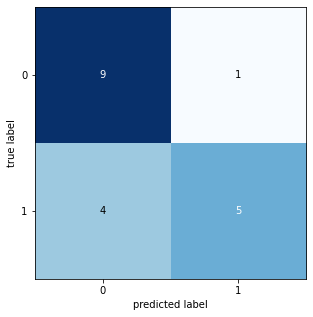

Running Time:  1.5804164999999557
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



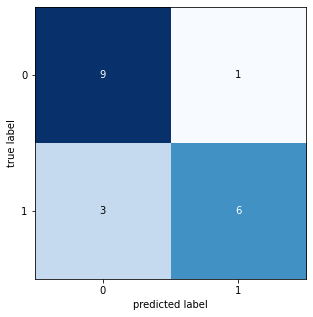

Running Time:  1.5774117999999362
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



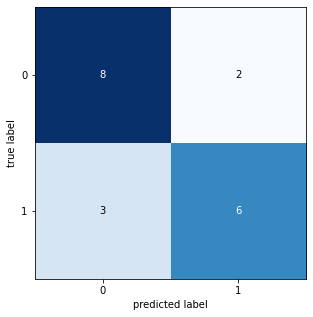

Running Time:  1.5811792999998033
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



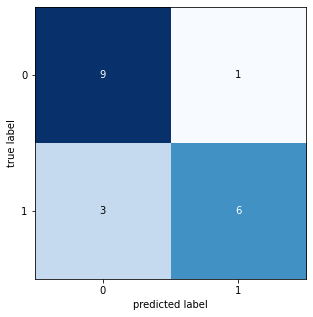

Running Time:  1.757608800000071
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



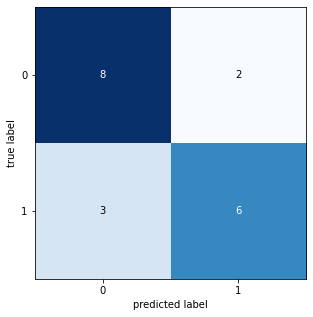

Running Time:  1.5749739999998837
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



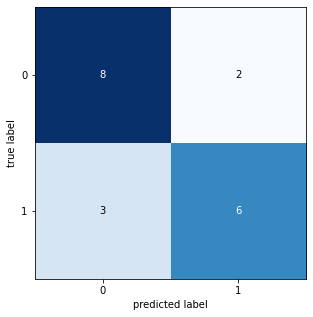

Running Time:  1.5884185999998408
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.83      0.56      0.67         9

    accuracy                           0.74        19
   macro avg       0.76      0.73      0.72        19
weighted avg       0.76      0.74      0.73        19



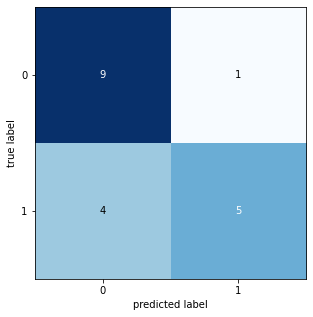

Running Time:  1.583270099999936
gen terbaik : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
F-1 Score terbaik : 0.7840909090909092  || Akurasi terbaik : 0.7894736842105263  || jumlah fitur : 57

Generation : 4
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi

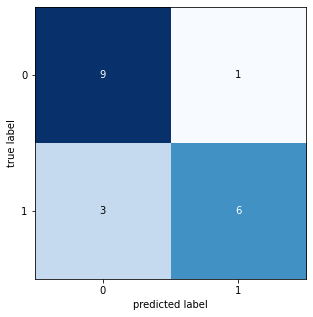

Running Time:  1.5865754999999808
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.80      0.44      0.57         9

    accuracy                           0.68        19
   macro avg       0.72      0.67      0.66        19
weighted avg       0.72      0.68      0.67        19



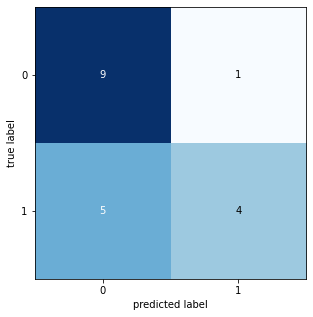

Running Time:  1.58354589999999
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.80      0.44      0.57         9

    accuracy                           0.68        19
   macro avg       0.72      0.67      0.66        19
weighted avg       0.72      0.68      0.67        19



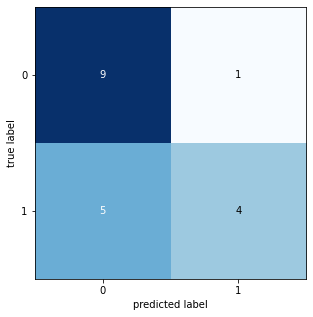

Running Time:  1.5775876000000153
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



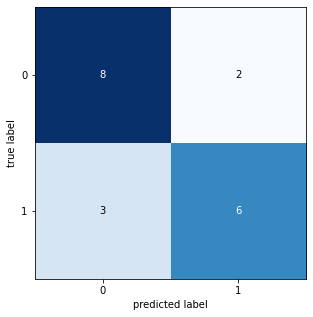

Running Time:  1.5841600999999628
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



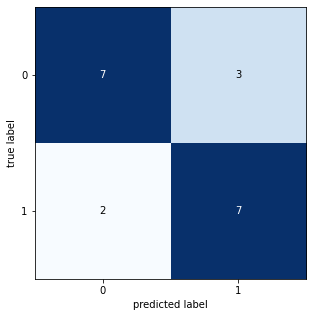

Running Time:  1.7766923000001498
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7840909090909092
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.86      0.67      0.75         9

    accuracy                           0.79        19
   macro avg       0.80      0.78      0.78        19
weighted avg       0.80      0.79      0.79        19



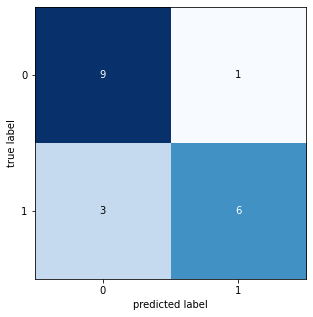

Running Time:  1.5799150999998801
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363636
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.71      0.56      0.63         9

    accuracy                           0.68        19
   macro avg       0.69      0.68      0.68        19
weighted avg       0.69      0.68      0.68        19



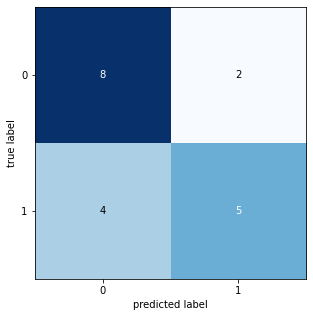

Running Time:  1.5785307000001012
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



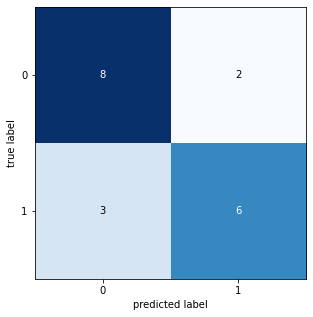

Running Time:  1.5904516000000513
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.80      0.44      0.57         9

    accuracy                           0.68        19
   macro avg       0.72      0.67      0.66        19
weighted avg       0.72      0.68      0.67        19



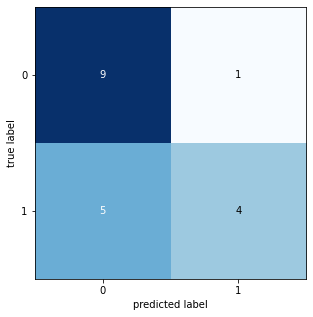

Running Time:  1.5791686000000027
gene : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6607142857142857
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.80      0.44      0.57         9

    accuracy                           0.68        19
   macro avg       0.72      0.67      0.66        19
weighted avg       0.72      0.68      0.67        19



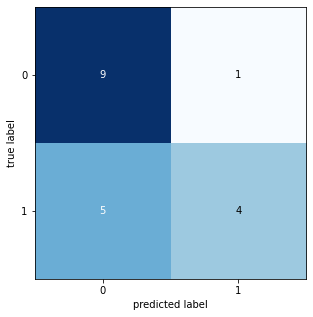

Running Time:  1.5729472999998961
gen terbaik : [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]
F-1 Score terbaik : 0.7840909090909092  || Akurasi terbaik : 0.7894736842105263  || jumlah fitur : 57

Running Time:  81.02525670000011
Train :  [ 0  1  2  3  4  6  7  9 10 11 12 13 15 16 17 18 19 20 24 25 26 27 28 29
 30 31 32 33 34 36 37 38 39 40 41 44 46 47 48 49 50 51 52 54 55 56 57 58
 59 60 61 62 63 64 66 67 68 70 71 72 73 74 75 77 78 79 80 81 83 84 86 87
 88 89 93 94 95 96] Test :  [ 5  8 14 21 22 23 35 42 43 45 53 65 69 76 82 85 90 91 92]
train:  (78, 101)
test:  (19, 101)
Running Time:  23.837514099999908
breast + IG Orde 2
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 

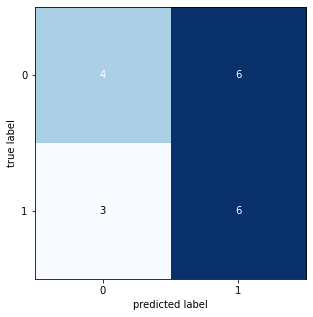

Running Time:  1.5920576999999412
breast + IG Orde 3
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



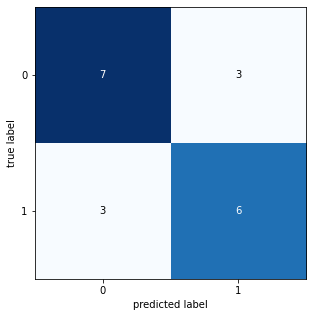

Running Time:  1.8067179999998189
breast + IG Orde 4
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



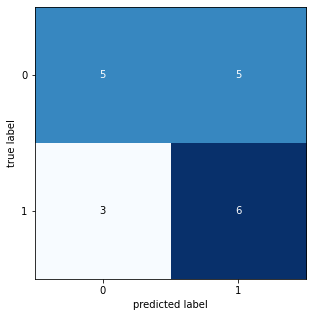

Running Time:  1.638754199999994
breast + IG + GA Orde 2
Generation : 0
gene : [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



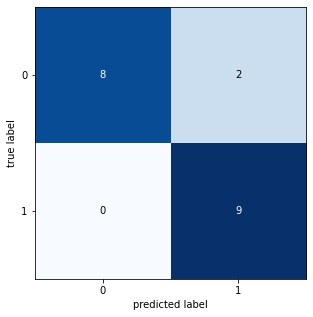

Running Time:  1.543764900000042
gene : [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



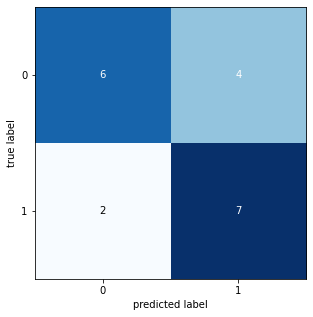

Running Time:  1.5530590999999276
gene : [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



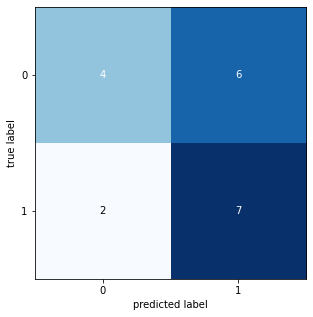

Running Time:  1.5426641999999902
gene : [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613446
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        10
           1       0.50      0.67      0.57         9

    accuracy                           0.53        19
   macro avg       0.54      0.53      0.52        19
weighted avg       0.54      0.53      0.52        19



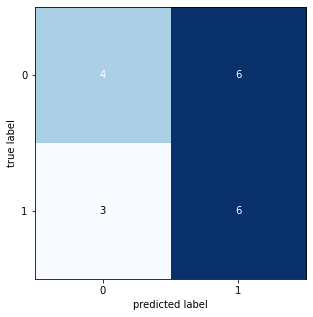

Running Time:  1.5373501999999917
gene : [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



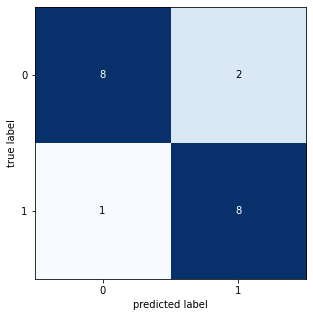

Running Time:  1.5432034000000385
gene : [1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



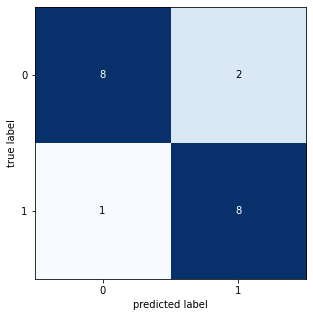

Running Time:  1.6947649000001093
gene : [0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



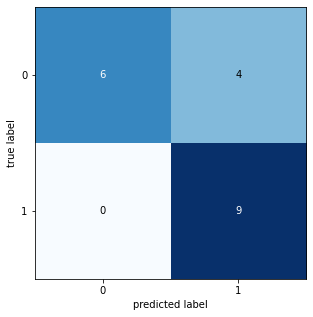

Running Time:  1.5462878000000728
gene : [1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



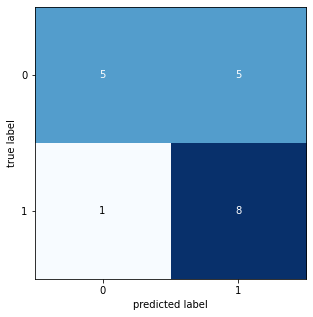

Running Time:  1.5450682000000597
gene : [0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



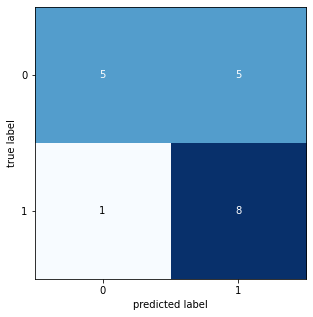

Running Time:  1.5397943000000396
gene : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



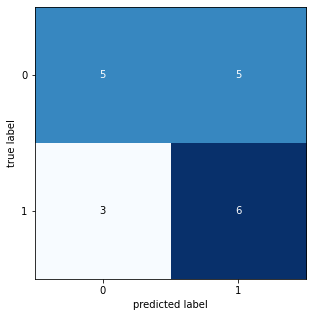

Running Time:  1.5426967999999306
gen terbaik : [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
F-1 Score terbaik : 0.8944444444444445  || Akurasi terbaik : 0.8947368421052632  || jumlah fitur : 54

Generation : 1
gene : [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akuras

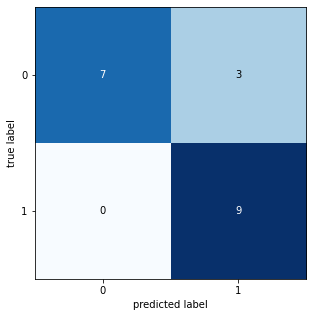

Running Time:  1.5486716000000342
gene : [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



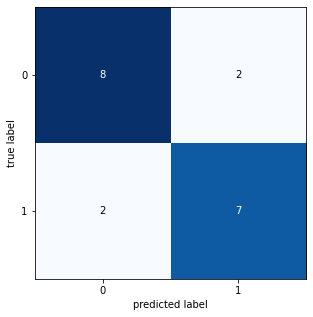

Running Time:  1.5590829000000213
gene : [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



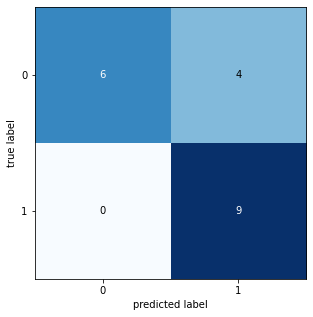

Running Time:  1.5435964000000695
gene : [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



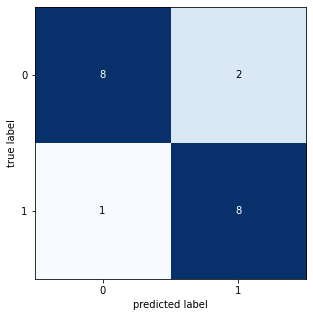

Running Time:  1.7150910000000295
gene : [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



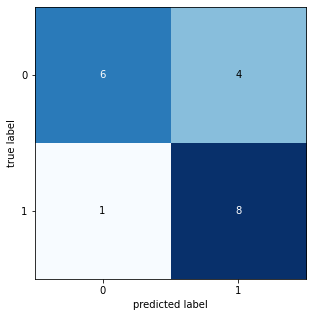

Running Time:  1.5465845999999601
gene : [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.9473684210526315
F1_Score :  0.9473684210526316
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.90      1.00      0.95         9

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



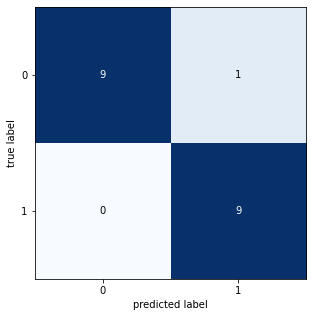

Running Time:  1.5405820000000858
gene : [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



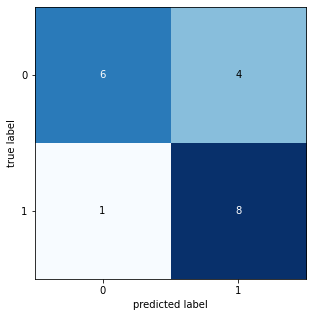

Running Time:  1.5547962000000553
gene : [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



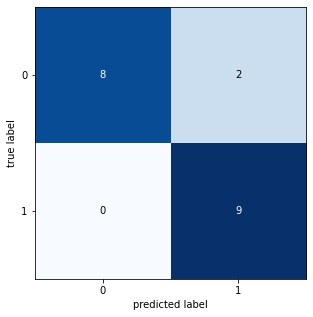

Running Time:  1.5396843999999419
gene : [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



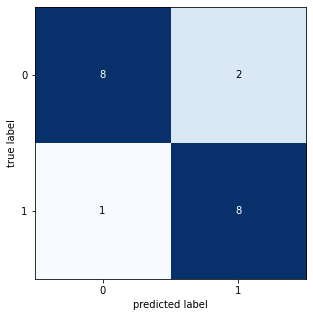

Running Time:  1.542024000000083
gene : [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



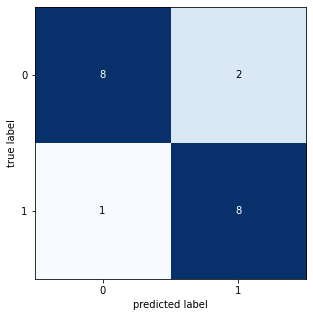

Running Time:  1.5553217000001496
gen terbaik : [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
F-1 Score terbaik : 0.9473684210526316  || Akurasi terbaik : 0.9473684210526315  || jumlah fitur : 52

Running Time:  31.626252699999895
breast + IG + GA Orde 3
Generation : 0
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 

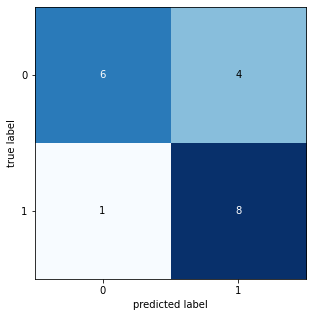

Running Time:  1.555101200000081
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



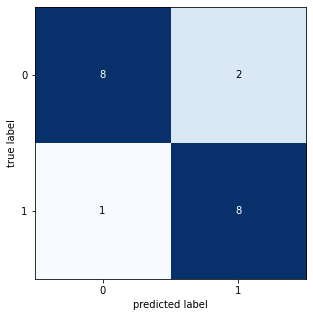

Running Time:  1.5660310000000663
gene : [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5681818181818181
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.54      0.78      0.64         9

    accuracy                           0.58        19
   macro avg       0.60      0.59      0.57        19
weighted avg       0.61      0.58      0.56        19



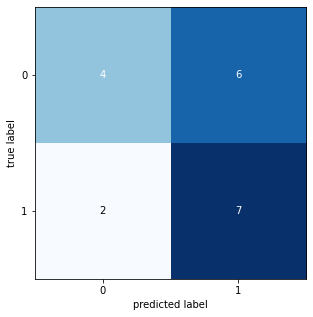

Running Time:  1.5600317000000814
gene : [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.42105263157894735
F1_Score :  0.4145658263305322
              precision    recall  f1-score   support

           0       0.43      0.30      0.35        10
           1       0.42      0.56      0.48         9

    accuracy                           0.42        19
   macro avg       0.42      0.43      0.41        19
weighted avg       0.42      0.42      0.41        19



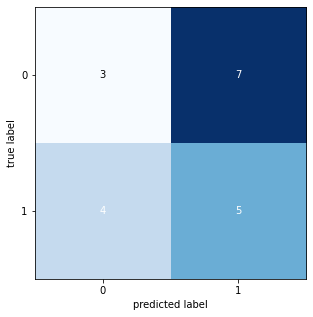

Running Time:  1.5664094000001114
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



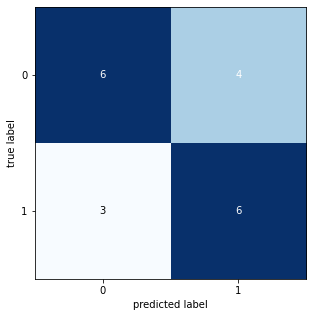

Running Time:  1.5715187000000697
gene : [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.4722222222222222
              precision    recall  f1-score   support

           0       0.50      0.40      0.44        10
           1       0.45      0.56      0.50         9

    accuracy                           0.47        19
   macro avg       0.48      0.48      0.47        19
weighted avg       0.48      0.47      0.47        19



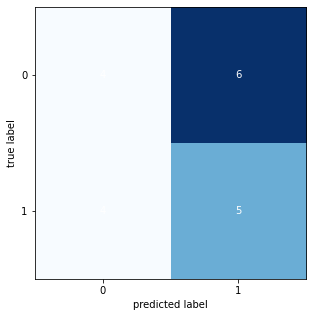

Running Time:  1.553183099999842
gene : [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



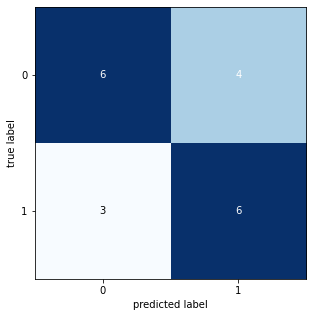

Running Time:  1.5662219000000732
gene : [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



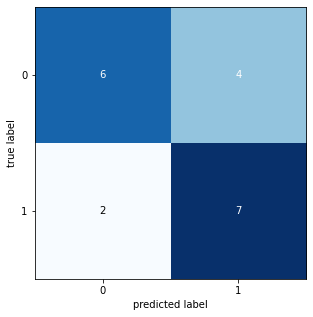

Running Time:  1.5703955999999835
gene : [1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5210084033613445
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.50      0.44      0.47         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.52        19
weighted avg       0.52      0.53      0.52        19



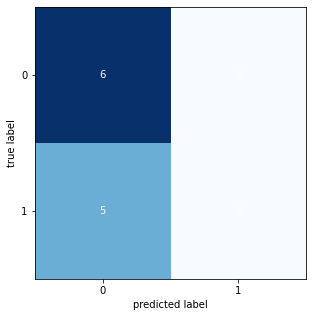

Running Time:  1.7549371999998584
gene : [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



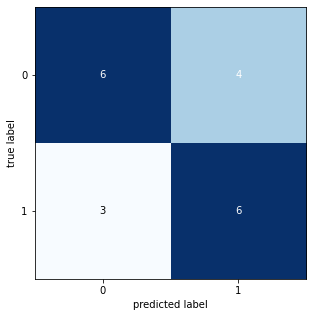

Running Time:  1.5779960999998366
gen terbaik : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
F-1 Score terbaik : 0.8421052631578948  || Akurasi terbaik : 0.8421052631578947  || jumlah fitur : 52

Generation : 1
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akuras

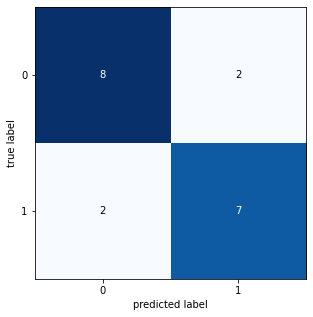

Running Time:  1.5638142000000244
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



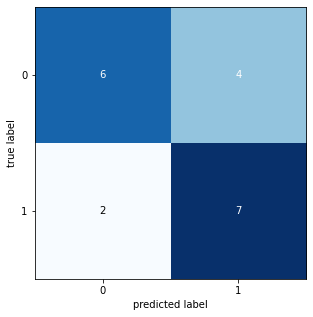

Running Time:  1.5618469000000914
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



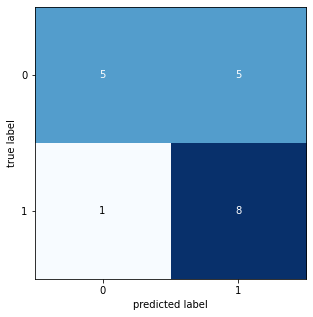

Running Time:  1.55141639999988
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



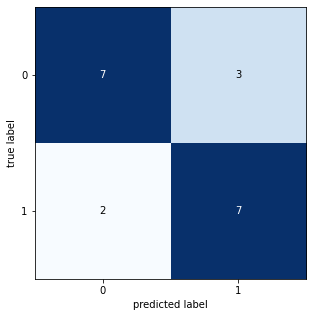

Running Time:  1.5647973000000093
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



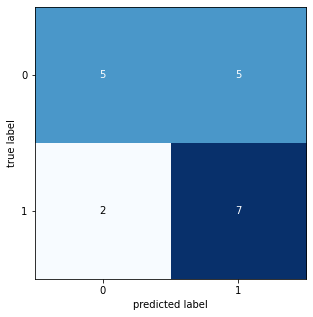

Running Time:  1.5643525999998928
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



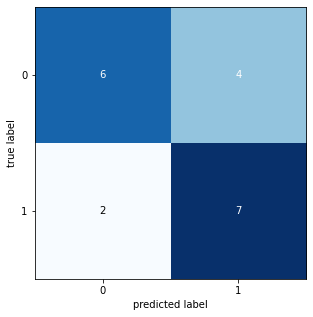

Running Time:  1.5584676999999374
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



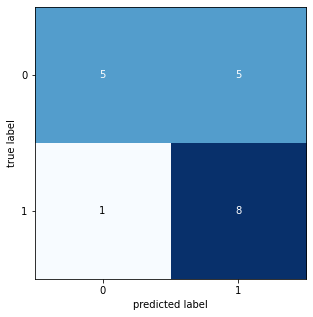

Running Time:  1.7491844999999557
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



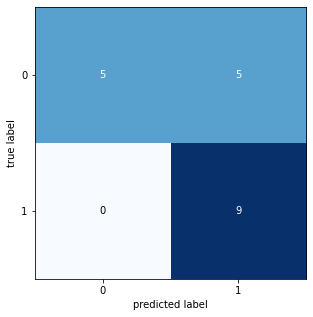

Running Time:  1.5680343999999877
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



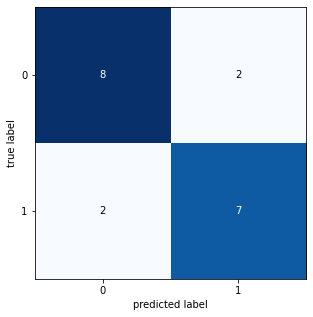

Running Time:  1.5616743999999017
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



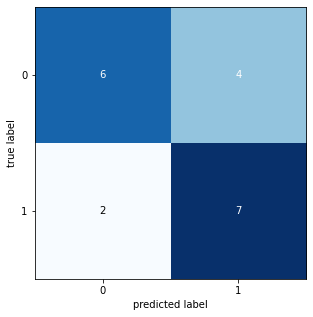

Running Time:  1.6338101999999708
gen terbaik : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
F-1 Score terbaik : 0.8421052631578948  || Akurasi terbaik : 0.8421052631578947  || jumlah fitur : 52

Generation : 2
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akuras

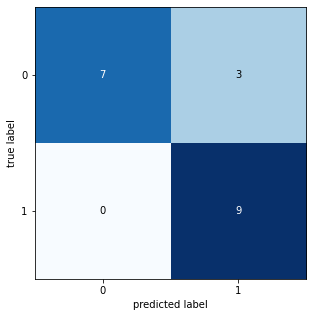

Running Time:  1.5681904999999006
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6144927536231883
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.57      0.89      0.70         9

    accuracy                           0.63        19
   macro avg       0.69      0.64      0.61        19
weighted avg       0.69      0.63      0.61        19



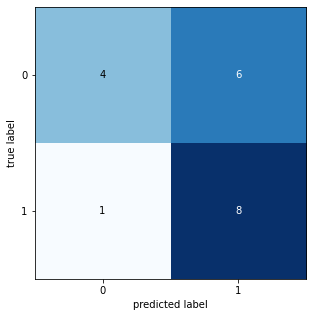

Running Time:  1.5696292000000085
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



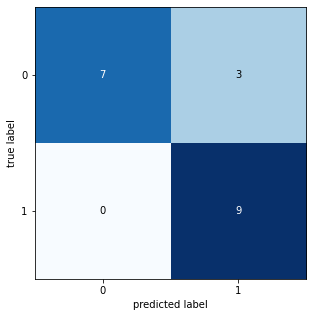

Running Time:  1.573848800000178
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



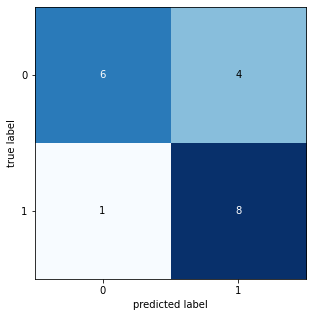

Running Time:  1.543703300000061
gene : [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6761363636363638
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19



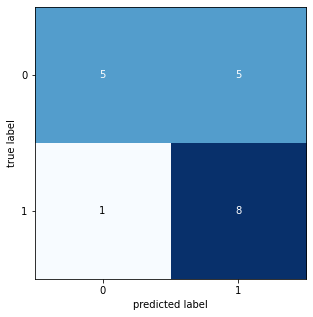

Running Time:  1.7516226000000188
gene : [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



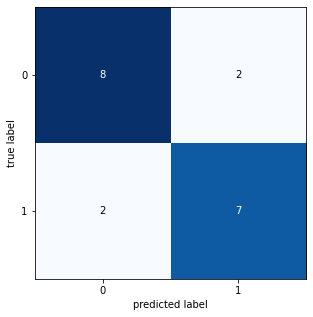

Running Time:  1.574737000000141
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



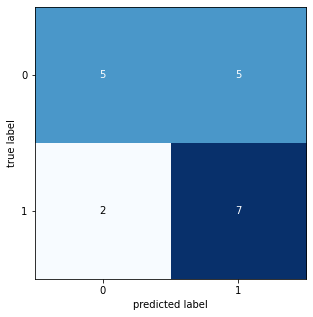

Running Time:  1.565854599999966
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



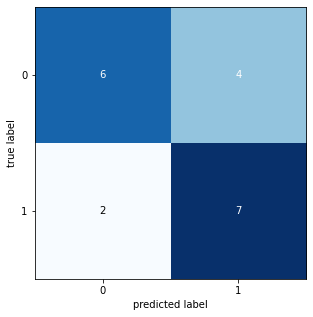

Running Time:  1.580214900000101
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



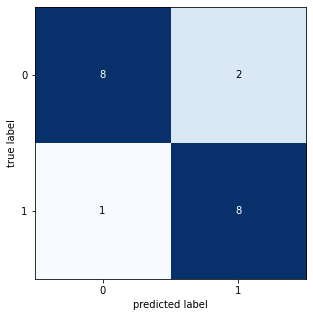

Running Time:  1.5718239999998787
gene : [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



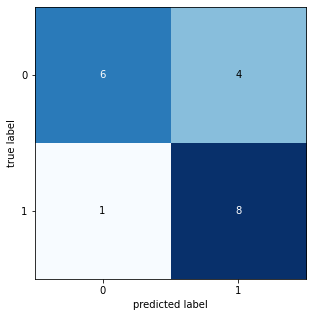

Running Time:  1.5584059000000252
gen terbaik : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
F-1 Score terbaik : 0.8421052631578948  || Akurasi terbaik : 0.8421052631578947  || jumlah fitur : 52

Generation : 3
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akuras

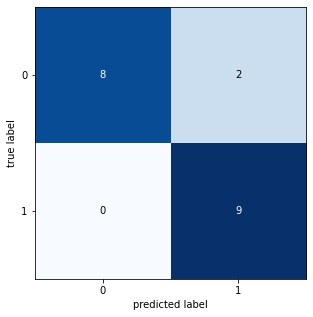

Running Time:  1.5636091999999735
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



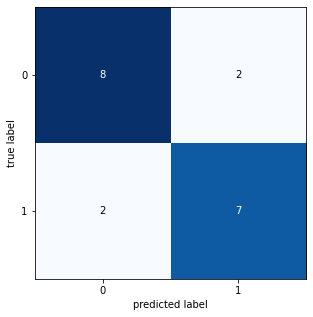

Running Time:  1.5605820000000676
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



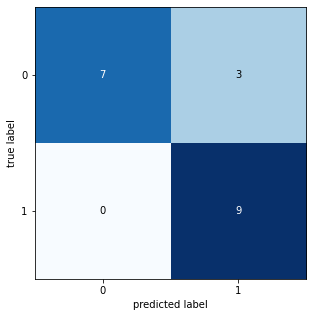

Running Time:  1.7574620000000323
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



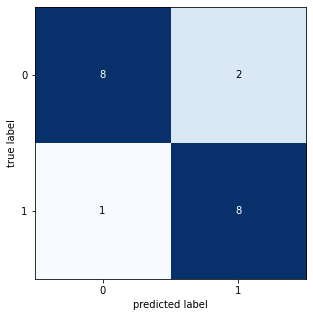

Running Time:  1.5752683000000616
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



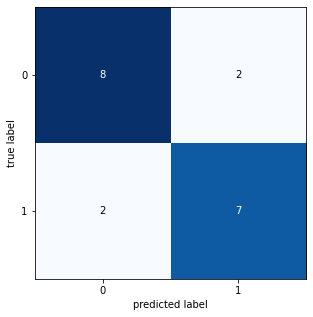

Running Time:  1.5660219000001234
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



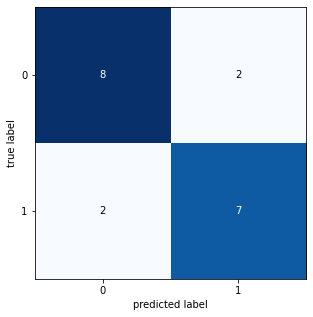

Running Time:  1.5653601999999864
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444445
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.82      1.00      0.90         9

    accuracy                           0.89        19
   macro avg       0.91      0.90      0.89        19
weighted avg       0.91      0.89      0.89        19



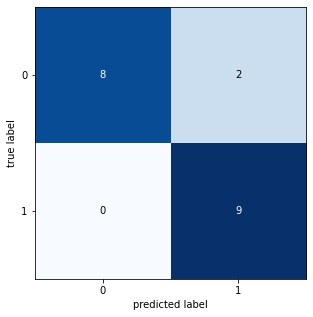

Running Time:  1.563336100000015
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



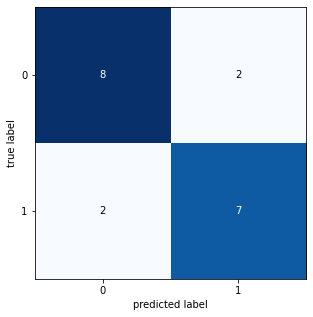

Running Time:  1.5848860000000968
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



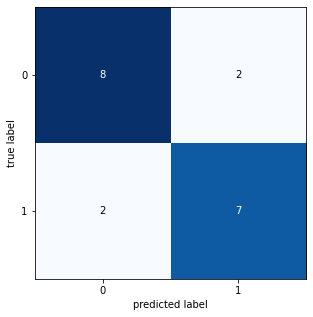

Running Time:  1.579328900000064
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



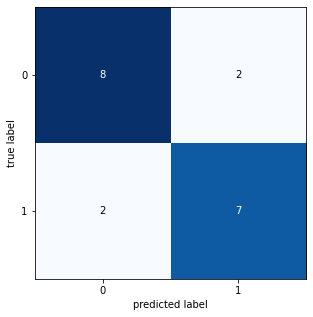

Running Time:  1.5622763999999734
gen terbaik : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
F-1 Score terbaik : 0.8944444444444445  || Akurasi terbaik : 0.8947368421052632  || jumlah fitur : 51

Generation : 4
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akuras

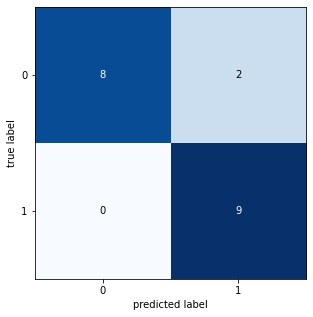

Running Time:  1.7441219000002093
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



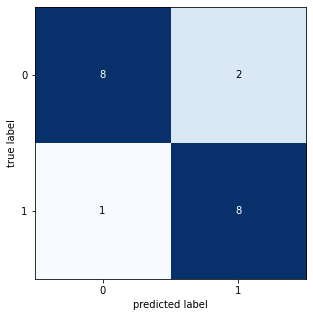

Running Time:  1.5640768999999182
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



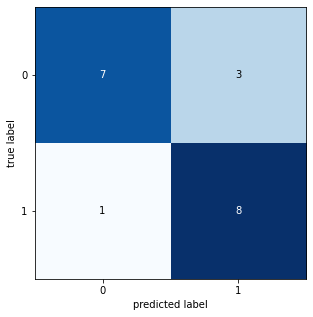

Running Time:  1.5594886000001225
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



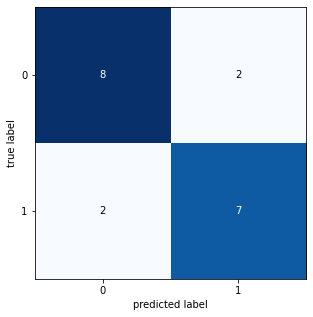

Running Time:  1.571882799999912
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.7888888888888888
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19



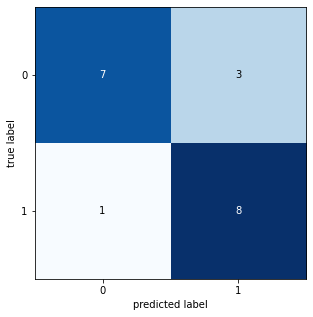

Running Time:  1.5683197999999265
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.784090909090909
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.69      1.00      0.82         9

    accuracy                           0.79        19
   macro avg       0.85      0.80      0.78        19
weighted avg       0.85      0.79      0.78        19



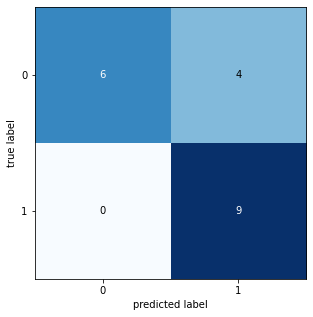

Running Time:  1.5644163000001754
gene : [1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8403361344537814
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.75      1.00      0.86         9

    accuracy                           0.84        19
   macro avg       0.88      0.85      0.84        19
weighted avg       0.88      0.84      0.84        19



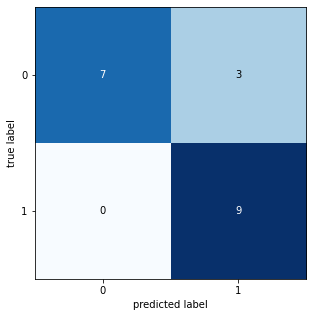

Running Time:  1.5692825000000994
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



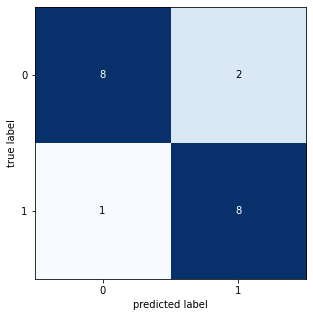

Running Time:  1.5648468000001685
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7246376811594203
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.64      1.00      0.78         9

    accuracy                           0.74        19
   macro avg       0.82      0.75      0.72        19
weighted avg       0.83      0.74      0.72        19



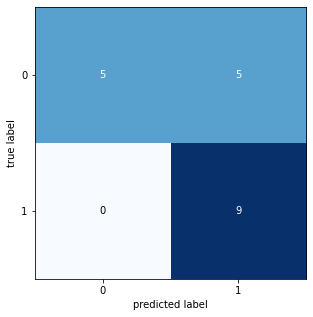

Running Time:  1.761289799999986
gene : [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



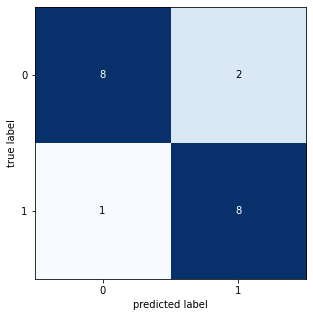

Running Time:  1.5573841000000357
gen terbaik : [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]
F-1 Score terbaik : 0.8944444444444445  || Akurasi terbaik : 0.8947368421052632  || jumlah fitur : 51

Running Time:  80.61197650000008
breast + IG + GA Orde 4
Generation : 0
gene : [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

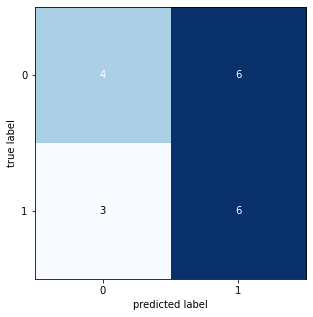

Running Time:  1.5692715999998654
gene : [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.75      0.67      0.71         9

    accuracy                           0.74        19
   macro avg       0.74      0.73      0.73        19
weighted avg       0.74      0.74      0.74        19



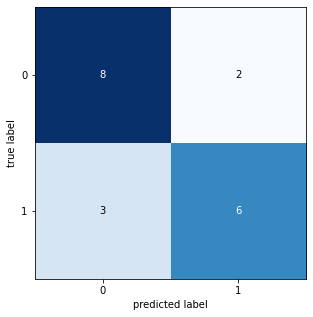

Running Time:  1.5836432999999488
gene : [0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



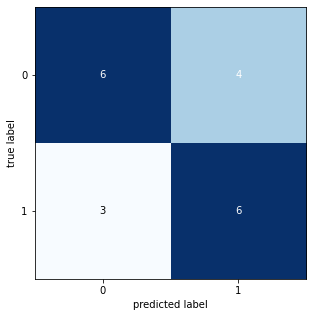

Running Time:  1.5853151999999682
gene : [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5043478260869565
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.50      0.33      0.40         9

    accuracy                           0.53        19
   macro avg       0.52      0.52      0.50        19
weighted avg       0.52      0.53      0.51        19



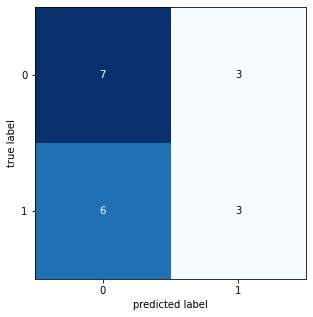

Running Time:  1.578265999999985
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



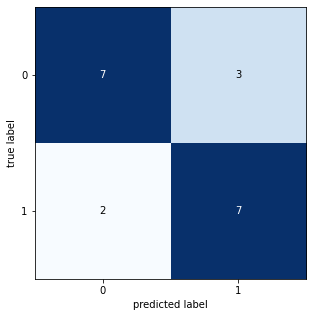

Running Time:  1.567815899999914
gene : [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



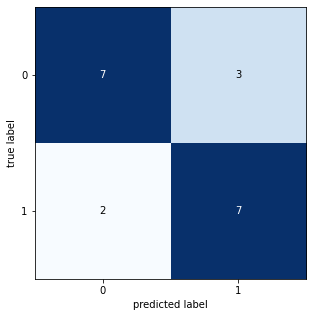

Running Time:  1.7534774000000652
gene : [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



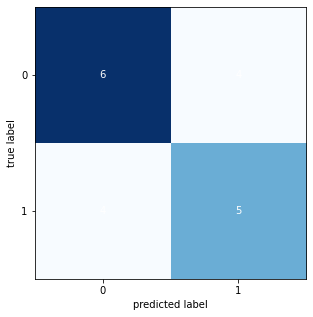

Running Time:  1.5763002000001052
gene : [1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.47368421052631576
F1_Score :  0.4602272727272727
              precision    recall  f1-score   support

           0       0.50      0.30      0.37        10
           1       0.46      0.67      0.55         9

    accuracy                           0.47        19
   macro avg       0.48      0.48      0.46        19
weighted avg       0.48      0.47      0.46        19



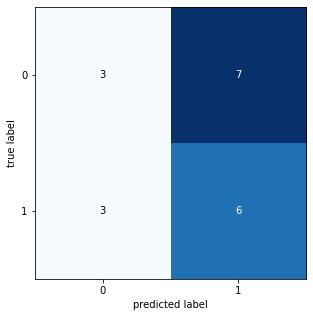

Running Time:  1.587181800000053
gene : [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5263157894736842
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.50      0.56      0.53         9

    accuracy                           0.53        19
   macro avg       0.53      0.53      0.53        19
weighted avg       0.53      0.53      0.53        19



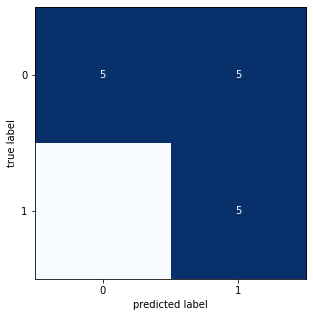

Running Time:  1.5882650999999441
gene : [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.56      0.56      0.56         9

    accuracy                           0.58        19
   macro avg       0.58      0.58      0.58        19
weighted avg       0.58      0.58      0.58        19



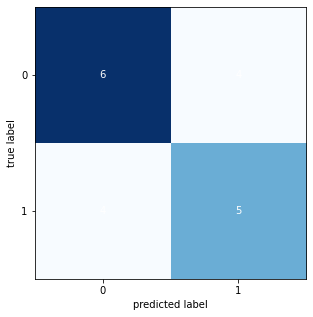

Running Time:  1.5835402000000158
gen terbaik : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.7368421052631577  || Akurasi terbaik : 0.7368421052631579  || jumlah fitur : 47

Generation : 1
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akuras

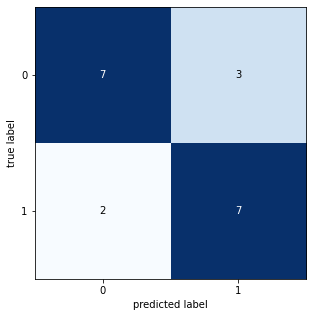

Running Time:  1.5873897999999826
gene : [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



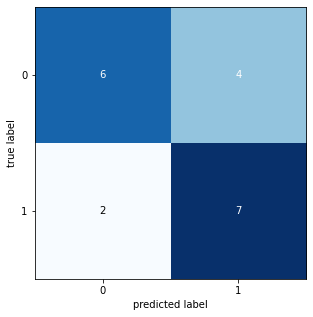

Running Time:  1.5841510000000198
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



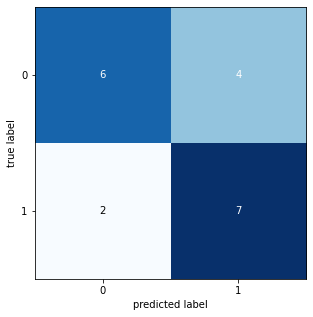

Running Time:  1.5848766000001433
gene : [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5263157894736842
F1_Score :  0.5263157894736842
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.50      0.56      0.53         9

    accuracy                           0.53        19
   macro avg       0.53      0.53      0.53        19
weighted avg       0.53      0.53      0.53        19



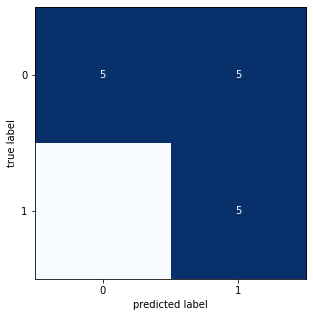

Running Time:  1.7794937999999547
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



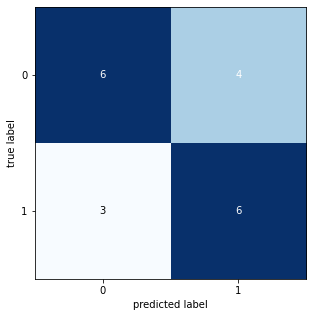

Running Time:  1.5853466999999455
gene : [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



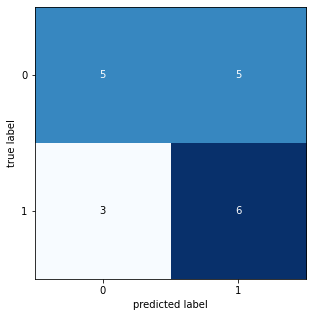

Running Time:  1.5816761000000952
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.5789473684210527
F1_Score :  0.5777777777777777
              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.67      0.60         9

    accuracy                           0.58        19
   macro avg       0.59      0.58      0.58        19
weighted avg       0.59      0.58      0.58        19



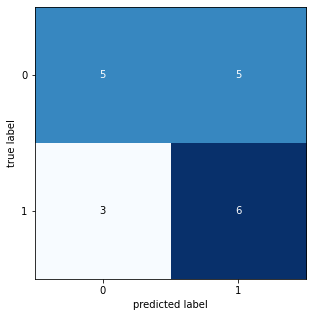

Running Time:  1.5851279000000886
gene : [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.67      0.67      0.67         9

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



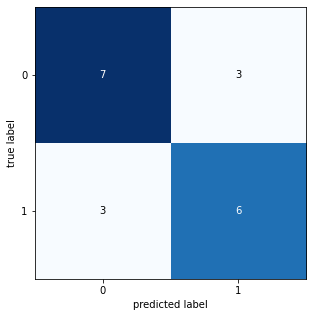

Running Time:  1.5801111000000674
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



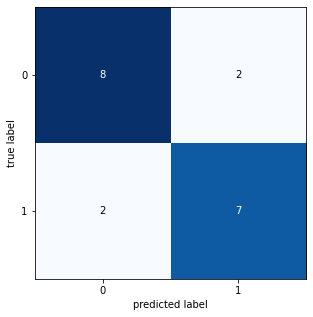

Running Time:  1.5780895999998847
gene : [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



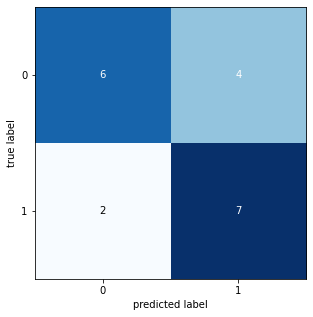

Running Time:  1.579570399999966
gen terbaik : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.788888888888889  || Akurasi terbaik : 0.7894736842105263  || jumlah fitur : 47

Generation : 2
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi 

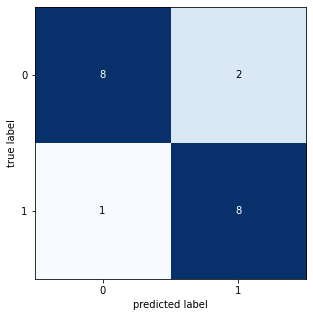

Running Time:  1.5785663000001477
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



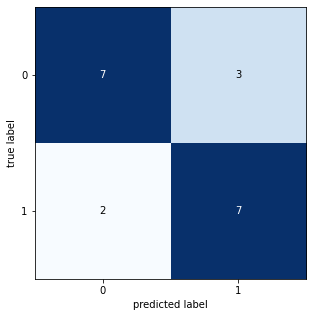

Running Time:  1.7757314999998925
gene : [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



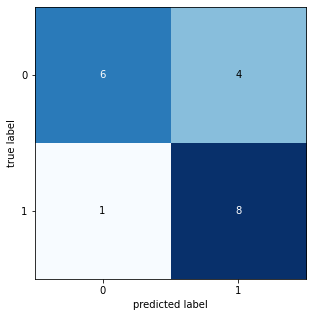

Running Time:  1.573239699999931
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



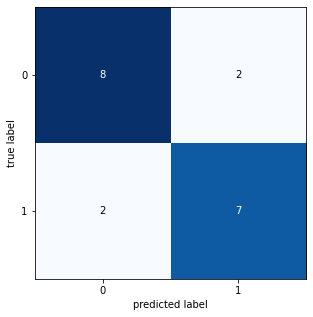

Running Time:  1.5700713000001087
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



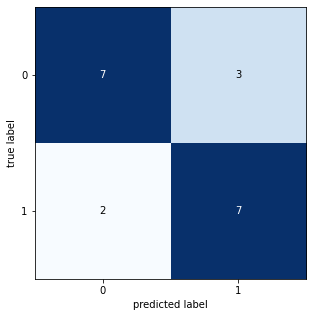

Running Time:  1.5712981000001491
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



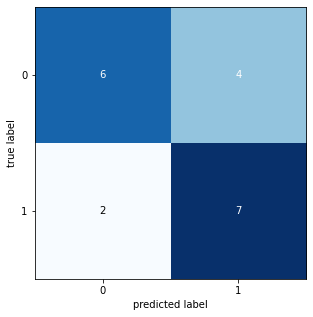

Running Time:  1.588548400000036
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



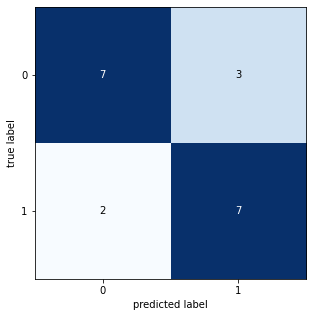

Running Time:  1.5766481000000567
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



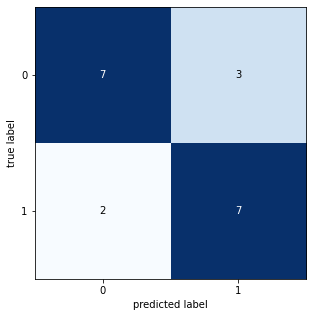

Running Time:  1.570951100000002
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.6842105263157895
F1_Score :  0.6833333333333333
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.64      0.78      0.70         9

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.68        19



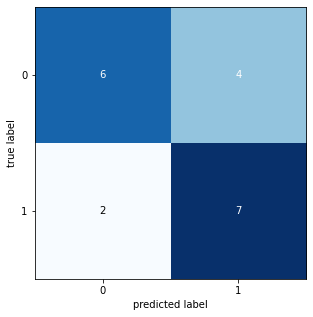

Running Time:  1.583677600000101
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



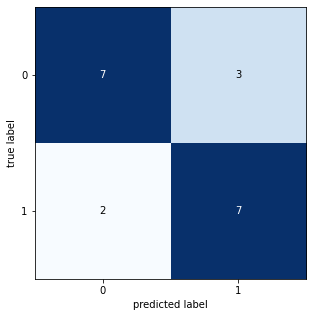

Running Time:  1.764986399999998
gen terbaik : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
F-1 Score terbaik : 0.8421052631578948  || Akurasi terbaik : 0.8421052631578947  || jumlah fitur : 45

Generation : 3
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi

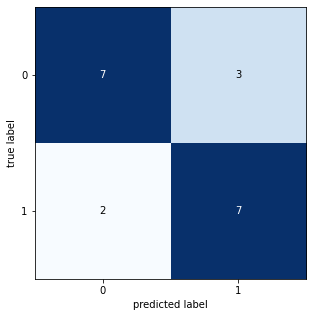

Running Time:  1.595706199999995
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



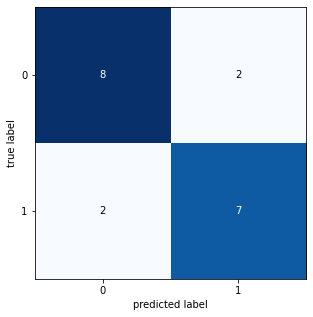

Running Time:  1.5674733999999262
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



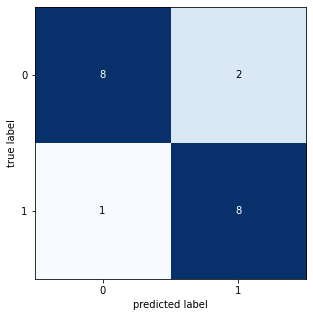

Running Time:  1.5779025000001639
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.631578947368421
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.60      0.67      0.63         9

    accuracy                           0.63        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.64      0.63      0.63        19



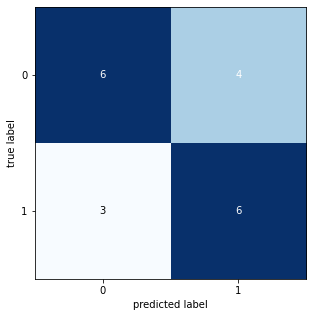

Running Time:  1.6331748000000061
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



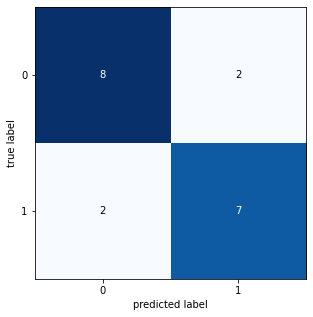

Running Time:  1.5766551000001527
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



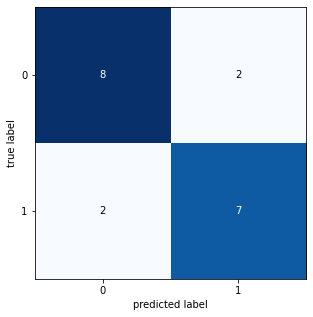

Running Time:  1.5896485000000666
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



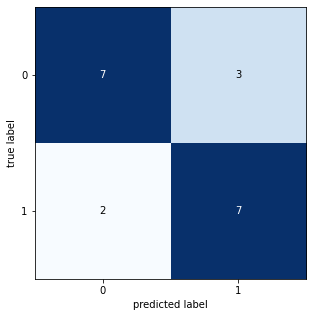

Running Time:  1.6250996000001123
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



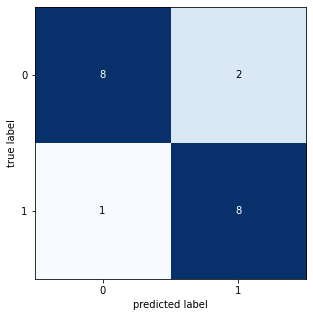

Running Time:  1.7888264000000618
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



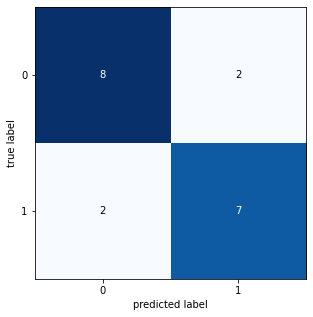

Running Time:  1.5809533999999985
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7368421052631577
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19



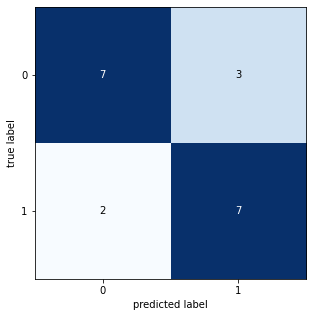

Running Time:  1.572164599999951
gen terbaik : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.8421052631578948  || Akurasi terbaik : 0.8421052631578947  || jumlah fitur : 47

Generation : 4
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi

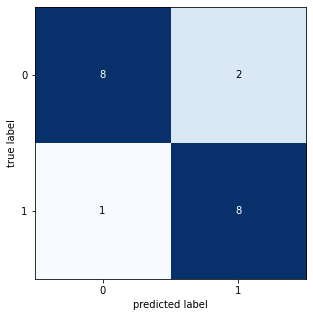

Running Time:  1.5831228999998075
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



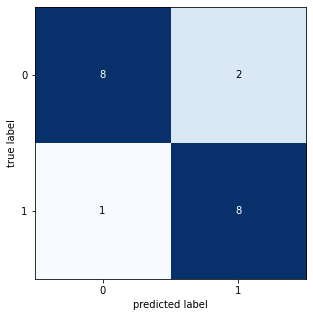

Running Time:  1.5814370999999028
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.631578947368421
F1_Score :  0.6274509803921569
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.58      0.78      0.67         9

    accuracy                           0.63        19
   macro avg       0.65      0.64      0.63        19
weighted avg       0.65      0.63      0.63        19



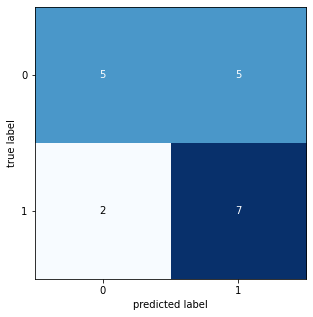

Running Time:  1.5814084999999523
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



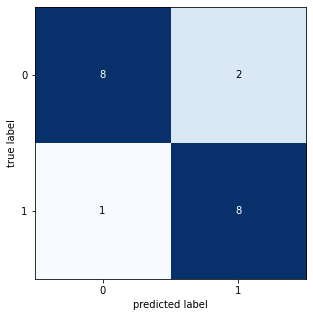

Running Time:  1.5776089999999385
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7894736842105263
F1_Score :  0.788888888888889
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.78      0.78         9

    accuracy                           0.79        19
   macro avg       0.79      0.79      0.79        19
weighted avg       0.79      0.79      0.79        19



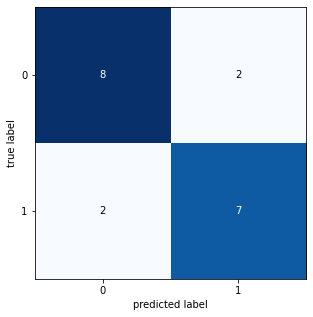

Running Time:  1.5668299999999817
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



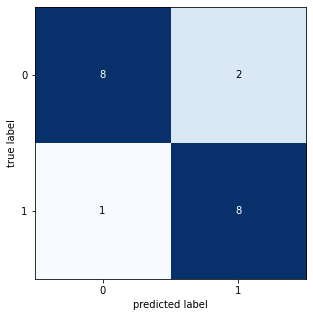

Running Time:  1.7561169000000518
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8947368421052632
F1_Score :  0.8944444444444444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.89      0.89      0.89         9

    accuracy                           0.89        19
   macro avg       0.89      0.89      0.89        19
weighted avg       0.89      0.89      0.89        19



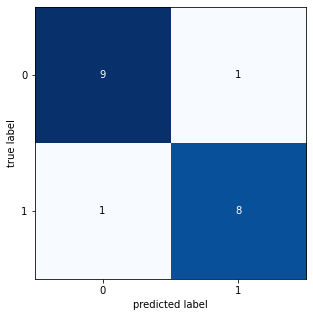

Running Time:  1.5764782000001105
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.7368421052631579
F1_Score :  0.7338935574229692
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19



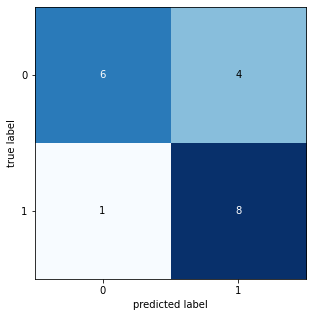

Running Time:  1.5853041000000303
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



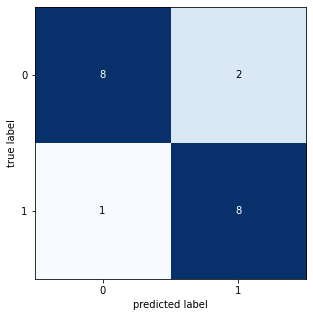

Running Time:  1.5757575000000088
gene : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Y_Train : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Y_Test : [1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Akurasi :  0.8421052631578947
F1_Score :  0.8421052631578948
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.80      0.89      0.84         9

    accuracy                           0.84        19
   macro avg       0.84      0.84      0.84        19
weighted avg       0.85      0.84      0.84        19



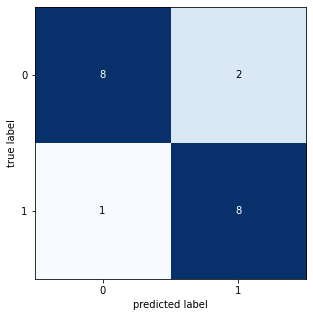

Running Time:  1.5681873999999425
gen terbaik : [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
F-1 Score terbaik : 0.8944444444444444  || Akurasi terbaik : 0.8947368421052632  || jumlah fitur : 47

Running Time:  81.14110679999999
Avg accuracy breast cancer + IG orde 2 :  0.6484210526315789
Avg F1 score breast cancer + IG orde 2 :  0.6402908330657692
Avg running time breast cancer + IG orde 2 :  25.378810599999966
Avg accuracy breast cancer + IG orde 3 :  0.6905263157894737
Avg F1 score breast cancer + IG orde 3 :  0.6854177323103154
Avg running time breast cancer + IG orde 3 :  25.41830061999994
Avg accuracy breast cancer + IG orde 4 :  0.6494736842105263
Avg F1 score breast cancer + IG orde 4 :  0.6465528338788534
Avg running time bre

In [9]:
start = timeit.default_timer()
akurasi_IG_2,f1_IG_2,rt_IG_2 = [],[],[]
akurasi_IG_3,f1_IG_3,rt_IG_3 = [],[],[]
akurasi_IG_4,f1_IG_4,rt_IG_4 = [],[],[]

akurasi_IG_GA_2,f1_IG_GA_2,fitur_IG_GA_2,rt_IG_GA_2 = [],[],[],[]
akurasi_IG_GA_3,f1_IG_GA_3,fitur_IG_GA_3,rt_IG_GA_3 = [],[],[],[]
akurasi_IG_GA_4,f1_IG_GA_4,fitur_IG_GA_4,rt_IG_GA_4 = [],[],[],[]

#Melakukan proses K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
kf.get_n_splits(data_new_breast)
X = data_new_breast.copy().iloc[:, 0:len(data_new_breast.columns)-1].values
Y = data_new_breast.copy().iloc[:, len(data_new_breast.columns)-1].values
for train_index, test_index in kf.split(X,Y):
    print("Train : ", train_index, "Test : ", test_index)
    data_train, data_test, y_train, y_test = pd.DataFrame(X[train_index]), pd.DataFrame(X[test_index]), Y[train_index], Y[test_index]
    data_train['label'] = y_train
    data_test['label'] = y_test
    data_train, data_test, rt_ig = InformationGain(data_train.copy(), data_test.copy())
    print("breast + IG Orde 2")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), "breast cancer", 2)
    akurasi_IG_2.append(acc)
    f1_IG_2.append(f1)
    rt_IG_2.append(rt+rt_ig)
    print("breast + IG Orde 3")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), "breast cancer", 3)
    akurasi_IG_3.append(acc)
    f1_IG_3.append(f1)
    rt_IG_3.append(rt+rt_ig)
    print("breast + IG Orde 4")
    acc,f1,rt = FLNN_Classifier(data_train.copy(), data_test.copy(), "breast cancer", 4)
    akurasi_IG_4.append(acc)
    f1_IG_4.append(f1)
    rt_IG_4.append(rt+rt_ig)
    
    print("breast + IG + GA Orde 2")
    acc,f1,fitur,rt = GeneticAlgorithm(data_train.copy(), data_test.copy(), 2)
    akurasi_IG_GA_2.append(acc)
    f1_IG_GA_2.append(f1)
    fitur_IG_GA_2.append(fitur)
    rt_IG_GA_2.append(rt+rt_ig)
    print("breast + IG + GA Orde 3")
    acc,f1,fitur,rt = GeneticAlgorithm(data_train.copy(), data_test.copy(), 3)
    akurasi_IG_GA_3.append(acc)
    f1_IG_GA_3.append(f1)
    fitur_IG_GA_3.append(fitur)
    rt_IG_GA_3.append(rt+rt_ig)
    print("breast + IG + GA Orde 4")
    acc,f1,fitur,rt = GeneticAlgorithm(data_train.copy(), data_test.copy(), 4)
    akurasi_IG_GA_4.append(acc)
    f1_IG_GA_4.append(f1)
    fitur_IG_GA_4.append(fitur)
    rt_IG_GA_4.append(rt+rt_ig)
    
akurasi_IG_2,f1_IG_2,rt_IG_2 = np.array(akurasi_IG_2),np.array(f1_IG_2),np.array(rt_IG_2)
akurasi_IG_3,f1_IG_3,rt_IG_3 = np.array(akurasi_IG_3),np.array(f1_IG_3),np.array(rt_IG_3)
akurasi_IG_4,f1_IG_4,rt_IG_4 = np.array(akurasi_IG_4),np.array(f1_IG_4),np.array(rt_IG_4)

akurasi_IG_GA_2,f1_IG_GA_2,fitur_IG_GA_2,rt_IG_GA_2 = np.array(akurasi_IG_GA_2),np.array(f1_IG_GA_2),np.array(fitur_IG_GA_2),np.array(rt_IG_GA_2)
akurasi_IG_GA_3,f1_IG_GA_3,fitur_IG_GA_3,rt_IG_GA_3 = np.array(akurasi_IG_GA_3),np.array(f1_IG_GA_3),np.array(fitur_IG_GA_3),np.array(rt_IG_GA_3)
akurasi_IG_GA_4,f1_IG_GA_4,fitur_IG_GA_4,rt_IG_GA_4 = np.array(akurasi_IG_GA_4),np.array(f1_IG_GA_4),np.array(fitur_IG_GA_4),np.array(rt_IG_GA_4)

#Print Result
print('===============================================================================================================================================================================================================')
print('Avg accuracy breast cancer + IG orde 2 : ', akurasi_IG_2.mean())
print('Avg F1 score breast cancer + IG orde 2 : ', f1_IG_2.mean())
print('Avg running time breast cancer + IG orde 2 : ', rt_IG_2.mean())
print('Avg accuracy breast cancer + IG orde 3 : ', akurasi_IG_3.mean())
print('Avg F1 score breast cancer + IG orde 3 : ', f1_IG_3.mean())
print('Avg running time breast cancer + IG orde 3 : ', rt_IG_3.mean())
print('Avg accuracy breast cancer + IG orde 4 : ', akurasi_IG_4.mean())
print('Avg F1 score breast cancer + IG orde 4 : ', f1_IG_4.mean())
print('Avg running time breast cancer + IG orde 4 : ', rt_IG_4.mean())
print('===============================================================================================================================================================================================================')
print('Avg accuracy breast cancer + IG + GA orde 2 : ', akurasi_IG_GA_2.mean())
print('Avg F1 score breast cancer + IG + GA orde 2 : ', f1_IG_GA_2.mean())
print('Avg Features breast cancer + IG + GA orde 2 : ', fitur_IG_GA_2.mean())
print('Avg running time breast cancer + IG + GA orde 2 : ', rt_IG_GA_2.mean())
print('Avg accuracy breast cancer + IG + GA orde 3 : ', akurasi_IG_GA_3.mean())
print('Avg F1 score breast cancer + IG + GA orde 3 : ', f1_IG_GA_3.mean())
print('Avg Features breast cancer + IG + GA orde 3 : ', fitur_IG_GA_3.mean())
print('Avg running time breast cancer + IG + GA orde 3 : ', rt_IG_GA_3.mean())
print('Avg accuracy breast cancer + IG + GA orde 4 : ', akurasi_IG_GA_4.mean())
print('Avg F1 score breast cancer + IG + GA orde 4 : ', f1_IG_GA_4.mean())
print('Avg Features breast cancer + IG + GA orde 4 : ', fitur_IG_GA_4.mean())
print('Avg running time breast cancer + IG + GA orde 4 : ', rt_IG_GA_4.mean())
print()
stop = timeit.default_timer()
print("Overall Running Time : ", stop-start)